# Predicting the IMDb rating of Arrow (American TV Serie) through scripts
## From the site: https://subslikescript.com/ 
## by: Anna Luiza Gomes and Getúlio Vianna

##Parte 1 - Merge de datasets

**No caso de já ter o dataset_final.csv, pular para a parte 2 - modelagem**

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV # para o grid search
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

In [2]:
# configuração para não exibir os warnings

import warnings
warnings.filterwarnings("ignore")

# ignorando future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [5]:
#Caminho que utilizamos onde o dataset final resultado do lda e os scripts
scripts = pd.read_csv('Data/scripts.csv', sep=";")

In [6]:
#Retirando uma coluna que não será utilizada
scripts.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
scripts.head()

nome_ep  \
0     /series/Arrow-2193021/season-1/episode-1-Pilot   
1  /series/Arrow-2193021/season-1/episode-2-Honor...   
2  /series/Arrow-2193021/season-1/episode-3-Lone_...   
3  /series/Arrow-2193021/season-1/episode-4-An_In...   
4   /series/Arrow-2193021/season-1/episode-5-Damaged   

                                           Episodios  \
0  The name of the islandthey found me on is Lian...   
1  [PANTING][GRUNTS][SPEAKING IN FOREIGN LANGUAGE...   
2  My name is Oliver Queen.To my family, I am the...   
3  My name is Oliver Queen.For 5 years, I was str...   
4  OLIVER:My name is Oliver Queen.For five years,...   

                                      text_processed         0         1  \
0  the name of the islandthey found me on is lian...  0.015196  0.191026   
1  [panting][grunts][speaking in foreign language...  0.014313  0.947105   
2  my name is oliver queen to my family  i am the...  0.049773  0.876113   
3  my name is oliver queen for 5 years  i was str...  0.110172  0.204996   
4  oliver:my name is oliver queen for five years ...  0.067190  0.908645   

          2  nota_imdb  qtd_reviews  Topic  
0  0.793778        8.5         7572      2  
1  0.038582        8.2         5731      1  
2  0.074114        8.4         5367      1  
3  0.684832        8.3         5071      2  
4  0.024165        8.6         5011      1

In [8]:
scripts.shape

(165, 9)

In [9]:
#Carregando os resultados da wikipedia de nota
wiki = pd.read_csv('Data/wikipedia.csv', sep=";")

In [10]:
#Retirando uma coluna que não será utilizada
wiki.drop('Unnamed: 0', axis=1, inplace=True)

In [11]:
# the script is missing the episodes 12,13,14 from season 7 and episode 4 from season 3
# plus episode 18 from season 2 which is in portuguese
wiki.loc[[40,49,149,150,151]]  

No.overall  No. inseason                 Title    Directed by  \
40           41            18         "Deathstroke"        Guy Bee   
49           50             4        "The Magician"   John Behring   
149         150            12      "Emerald Archer"    Glen Winter   
150         151            13    "Star City Slayer"  Gregory Smith   
151         152            14  "Brothers & Sisters"  Marcus Stokes   

                                  Written by  Original air date  Prod.code  \
40       Marc Guggenheim & Drew Z. Greenberg      April 2, 2014     2J7468   
49           Marc Guggenheim & Wendy Mericle   October 29, 2014     3J5154   
149  Marc Guggenheim & Emilio Ortega Aldrich   February 4, 2019  T27.13662   
150         Beth Schwartz & Jill Blankenship  February 11, 2019  T27.13663   
151            Rebecca Bellotto & Jeane Wong      March 4, 2019  T27.13664   

    U.S. viewers(millions)  
40                2.32[49]  
49                2.49[58]  
149              1.07[159]  
150              1.09[160]  
151              0.89[161]

In [12]:
wiki = wiki.drop(wiki.index[[40,49,149,150,151]]) #removing lines from the wiki that do not have in the scripts

In [13]:
#Reseting os índices
wiki = wiki.reset_index(drop=True)

In [14]:
wiki.shape

(165, 8)

In [15]:
#Unindo os dois datasets (scripts + wiki)
dataset = pd.concat([wiki, scripts], axis=1) 

In [16]:
dataset.columns

Index(['No.overall', 'No. inseason', 'Title', 'Directed by', 'Written by',
       'Original air date', 'Prod.code', 'U.S. viewers(millions)', 'nome_ep',
       'Episodios', 'text_processed', '0', '1', '2', 'nota_imdb',
       'qtd_reviews', 'Topic'],
      dtype='object')

In [17]:
dataset.head()

No.overall  No. inseason               Title      Directed by  \
0           1             1             "Pilot"     David Nutter   
1           2             2  "Honor Thy Father"    David Barrett   
2           3             3       "Lone Gunmen"          Guy Bee   
3           4             4   "An Innocent Man"    Vince Misiano   
4           5             5           "Damaged"  Michael Schultz   

                                          Written by Original air date  \
0  Story by : Greg Berlanti & Marc GuggenheimTele...  October 10, 2012   
1  Story by : Greg Berlanti & Marc GuggenheimTele...  October 17, 2012   
2  Story by : Greg Berlanti & Andrew KreisbergTel...  October 24, 2012   
3                           Moira Kirland & Lana Cho  October 31, 2012   
4                     Wendy Mericle & Ben Sokolowski  November 7, 2012   

  Prod.code U.S. viewers(millions)  \
0    296818                4.14[9]   
1    2J7302               3.55[10]   
2    2J7303               3.51[11]   
3    2J7304               3.05[12]   
4    2J7305               3.75[13]   

                                             nome_ep  \
0     /series/Arrow-2193021/season-1/episode-1-Pilot   
1  /series/Arrow-2193021/season-1/episode-2-Honor...   
2  /series/Arrow-2193021/season-1/episode-3-Lone_...   
3  /series/Arrow-2193021/season-1/episode-4-An_In...   
4   /series/Arrow-2193021/season-1/episode-5-Damaged   

                                           Episodios  \
0  The name of the islandthey found me on is Lian...   
1  [PANTING][GRUNTS][SPEAKING IN FOREIGN LANGUAGE...   
2  My name is Oliver Queen.To my family, I am the...   
3  My name is Oliver Queen.For 5 years, I was str...   
4  OLIVER:My name is Oliver Queen.For five years,...   

                                      text_processed         0         1  \
0  the name of the islandthey found me on is lian...  0.015196  0.191026   
1  [panting][grunts][speaking in foreign language...  0.014313  0.947105   
2  my name is oliver queen to my family  i am the...  0.049773  0.876113   
3  my name is oliver queen for 5 years  i was str...  0.110172  0.204996   
4  oliver:my name is oliver queen for five years ...  0.067190  0.908645   

          2  nota_imdb  qtd_reviews  Topic  
0  0.793778        8.5         7572      2  
1  0.038582        8.2         5731      1  
2  0.074114        8.4         5367      1  
3  0.684832        8.3         5071      2  
4  0.024165        8.6         5011      1

In [18]:
#Processo de limpeza do dataset
dataset[['viewers(millions)','residual']] = dataset['U.S. viewers(millions)'].str.split('[',expand=True)

In [19]:
dataset.drop(['U.S. viewers(millions)','residual','Title','text_processed','nome_ep','Topic','Episodios', 'No.overall', 'No. inseason', 'Written by', 'Prod.code', 'Original air date'], axis = 1 ,inplace = True)

In [20]:
dataset = dataset[[ 'Directed by', 'qtd_reviews', '0','1','2', 'viewers(millions)',  'nota_imdb']]

In [21]:
dataset.columns = ['Directed_by',  'qtd_reviews', '0','1','2','viewers(millions)',  'nota_imdb']

In [22]:
dataset.head()

Directed_by  qtd_reviews         0         1         2  \
0     David Nutter         7572  0.015196  0.191026  0.793778   
1    David Barrett         5731  0.014313  0.947105  0.038582   
2          Guy Bee         5367  0.049773  0.876113  0.074114   
3    Vince Misiano         5071  0.110172  0.204996  0.684832   
4  Michael Schultz         5011  0.067190  0.908645  0.024165   

  viewers(millions)  nota_imdb  
0              4.14        8.5  
1              3.55        8.2  
2              3.51        8.4  
3              3.05        8.3  
4              3.75        8.6

In [23]:
#Transformando os viewers em número
dataset["viewers(millions)"] = pd.to_numeric(dataset["viewers(millions)"])

In [24]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Directed_by        165 non-null    object 
 1   qtd_reviews        165 non-null    int64  
 2   0                  165 non-null    float64
 3   1                  165 non-null    float64
 4   2                  165 non-null    float64
 5   viewers(millions)  165 non-null    float64
 6   nota_imdb          165 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 9.1+ KB


In [25]:
#Renomeando as colunas
columns_dataset = ['Directed_by','reviews', 'Cluster 0', 'Cluster 1', 'Cluster 2', 'viewers(millions)', 'IMDB rating'  ]
dataset.columns = columns_dataset

In [26]:
dataset.head()

Directed_by  reviews  Cluster 0  Cluster 1  Cluster 2  \
0     David Nutter     7572   0.015196   0.191026   0.793778   
1    David Barrett     5731   0.014313   0.947105   0.038582   
2          Guy Bee     5367   0.049773   0.876113   0.074114   
3    Vince Misiano     5071   0.110172   0.204996   0.684832   
4  Michael Schultz     5011   0.067190   0.908645   0.024165   

   viewers(millions)  IMDB rating  
0               4.14          8.5  
1               3.55          8.2  
2               3.51          8.4  
3               3.05          8.3  
4               3.75          8.6

In [28]:
dataset.to_csv('Data/dataset_final.csv',  sep=';')

## Parte 2 - Modeling

###A) Data Discovery

In [29]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV # para o grid search
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from math import sqrt
from sklearn.metrics import mean_squared_error

In [34]:
#In case having dataset_final.csv, please run this cell
dataset = pd.read_csv('Data/dataset_final.csv', sep=';')

In [35]:
dataset.head()

Unnamed: 0      Directed_by  reviews  Cluster 0  Cluster 1  Cluster 2  \
0           0     David Nutter     7572   0.015196   0.191026   0.793778   
1           1    David Barrett     5731   0.014313   0.947105   0.038582   
2           2          Guy Bee     5367   0.049773   0.876113   0.074114   
3           3    Vince Misiano     5071   0.110172   0.204996   0.684832   
4           4  Michael Schultz     5011   0.067190   0.908645   0.024165   

   viewers(millions)  IMDB rating  
0               4.14          8.5  
1               3.55          8.2  
2               3.51          8.4  
3               3.05          8.3  
4               3.75          8.6

In [36]:
from sklearn.preprocessing import OrdinalEncoder

# definindo a transformação ordinal encoding
encoder = OrdinalEncoder()

# transformando os dados de Diretores para ordinais
dataset[["Directed_by"]] = encoder.fit_transform(dataset[["Directed_by"]])

In [37]:
dataset.head()

Unnamed: 0  Directed_by  reviews  Cluster 0  Cluster 1  Cluster 2  \
0           0          9.0     7572   0.015196   0.191026   0.793778   
1           1          7.0     5731   0.014313   0.947105   0.038582   
2           2         18.0     5367   0.049773   0.876113   0.074114   
3           3         49.0     5071   0.110172   0.204996   0.684832   
4           4         40.0     5011   0.067190   0.908645   0.024165   

   viewers(millions)  IMDB rating  
0               4.14          8.5  
1               3.55          8.2  
2               3.51          8.4  
3               3.05          8.3  
4               3.75          8.6

In [38]:
#Retirando uma coluna que não será utilizada
dataset.drop('Unnamed: 0', axis=1, inplace=True)

In [39]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Directed_by        165 non-null    float64
 1   reviews            165 non-null    int64  
 2   Cluster 0          165 non-null    float64
 3   Cluster 1          165 non-null    float64
 4   Cluster 2          165 non-null    float64
 5   viewers(millions)  165 non-null    float64
 6   IMDB rating        165 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 9.1 KB


In [40]:
dataset.describe().T

count         mean          std          min          25%  \
Directed_by        165.0    25.375758    13.623577     0.000000    16.000000   
reviews            165.0  3471.806061  1449.607428  1370.000000  2239.000000   
Cluster 0          165.0     0.324964     0.355285     0.010112     0.044557   
Cluster 1          165.0     0.320396     0.362446     0.000000     0.027515   
Cluster 2          165.0     0.352760     0.381668     0.000000     0.000000   
viewers(millions)  165.0     2.113758     0.858646     0.620000     1.340000   
IMDB rating        165.0     8.323636     0.639635     5.500000     8.000000   

                           50%          75%           max  
Directed_by          22.000000    37.000000     50.000000  
reviews            3355.000000  4355.000000  11347.000000  
Cluster 0             0.138817     0.604985      0.999569  
Cluster 1             0.135334     0.618074      0.989588  
Cluster 2             0.136325     0.770144      0.972641  
viewers(millions)     2.270000     2.800000      4.140000  
IMDB rating           8.300000     8.700000      9.700000

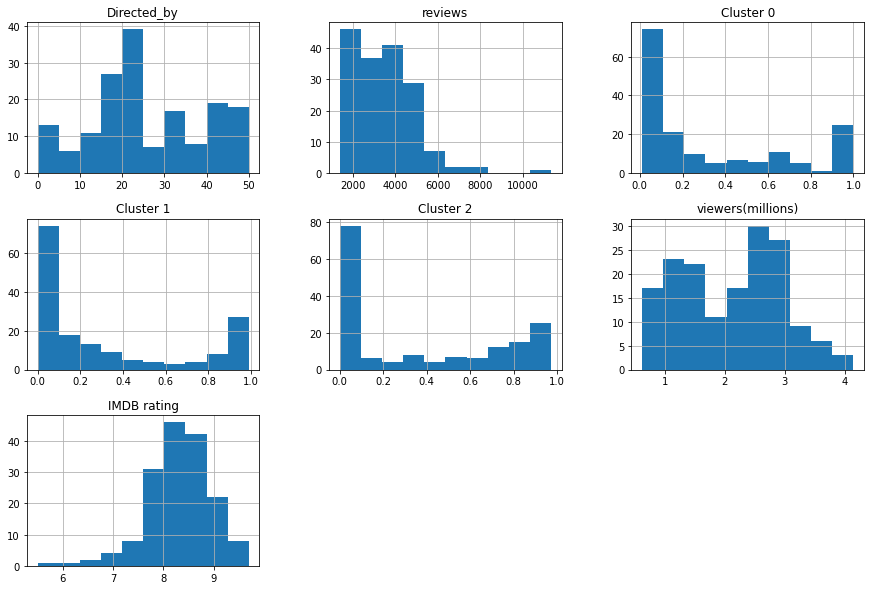

In [41]:
#Visualização dos histogramas
dataset.hist(figsize = (15,10))
plt.show()

Text(0, 0.5, 'Frequency')

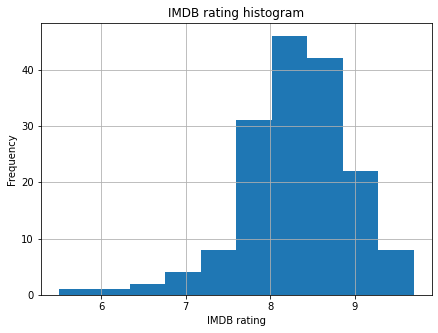

In [42]:
#Visualização do histograma da variável a ser predita (Y)
dataset['IMDB rating'].hist(figsize=(7,5))
plt.title('IMDB rating histogram')
plt.xlabel('IMDB rating')
plt.ylabel('Frequency')

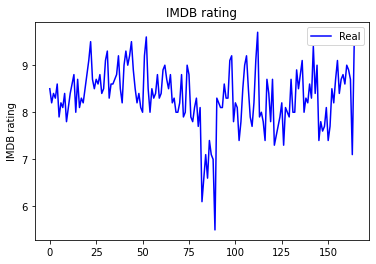

In [43]:
#Olhando a variável a ser predita no espaço de tempo pois o dataset é organizado cronologicamente
plt.plot(dataset['IMDB rating'], color = 'blue', label = 'Real')
plt.title('IMDB rating')
plt.ylabel('IMDB rating')
plt.legend()
plt.show()

<AxesSubplot:>

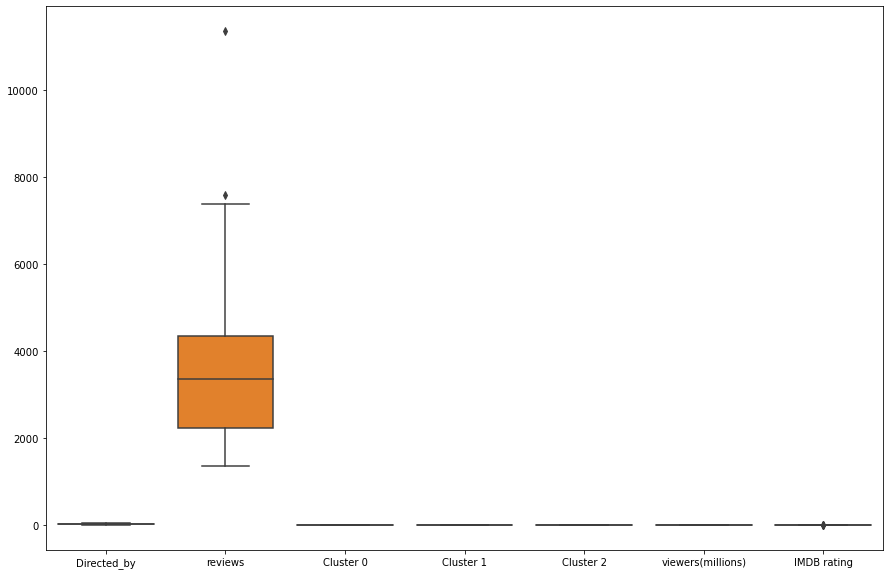

In [44]:
#Boxplot para verificação mas tem uma variável maior que outra, é preciso normalizar
import seaborn as sns
# boxplot com seaborn

fig, ax = plt.subplots(1, figsize= (15,10))
sns.boxplot(ax = ax, data = dataset)

Need to normalize o Directed_by, qtd_reviews e viewers(millions)

<AxesSubplot:>

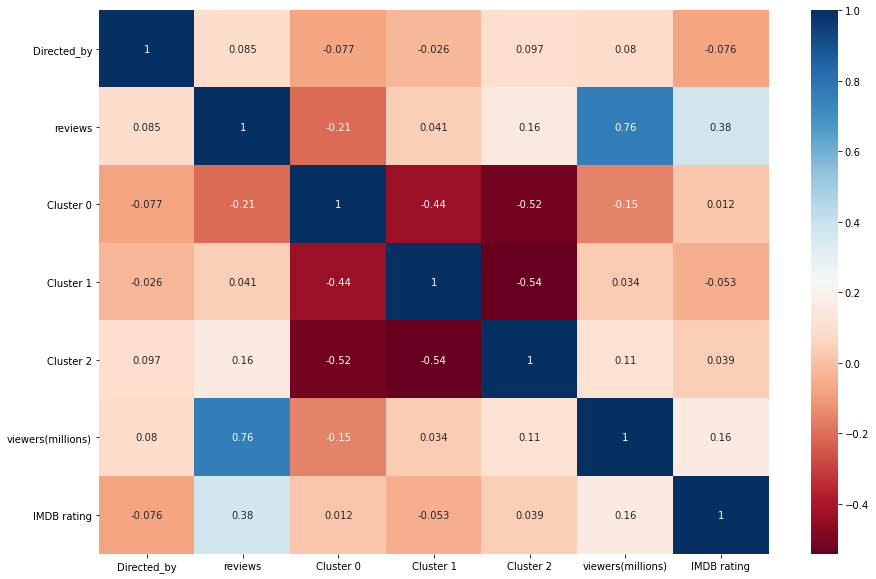

In [45]:
#Verificação da correlação de Pearson para todas as variáveis
#Heat map - pela correlação de pearson
fig, ax = plt.subplots(1,figsize=(15,10))
sns.heatmap(dataset.corr(),ax=ax, annot=True, cmap='RdBu')

In [46]:
from sklearn.preprocessing import MinMaxScaler  
#primeiro fazer uma normalização em todo dataset e depois faremos os testes com os 2 datasets
dataset_scaler = MinMaxScaler()

rescaled_dataset = dataset_scaler.fit_transform(dataset)
rescaled_dataset = pd.DataFrame(rescaled_dataset, columns = dataset.columns) 

In [47]:
rescaled_dataset.describe().T

count      mean       std  min       25%       50%  \
Directed_by        165.0  0.507515  0.272472  0.0  0.320000  0.440000   
reviews            165.0  0.210665  0.145295  0.0  0.087100  0.198958   
Cluster 0          165.0  0.318207  0.359070  0.0  0.034812  0.130077   
Cluster 1          165.0  0.323767  0.366260  0.0  0.027804  0.136758   
Cluster 2          165.0  0.362683  0.392404  0.0  0.000000  0.140160   
viewers(millions)  165.0  0.424363  0.243934  0.0  0.204545  0.468750   
IMDB rating        165.0  0.672294  0.152294  0.0  0.595238  0.666667   

                        75%  max  
Directed_by        0.740000  1.0  
reviews            0.299188  1.0  
Cluster 0          0.601212  1.0  
Cluster 1          0.624577  1.0  
Cluster 2          0.791807  1.0  
viewers(millions)  0.619318  1.0  
IMDB rating        0.761905  1.0

<AxesSubplot:>

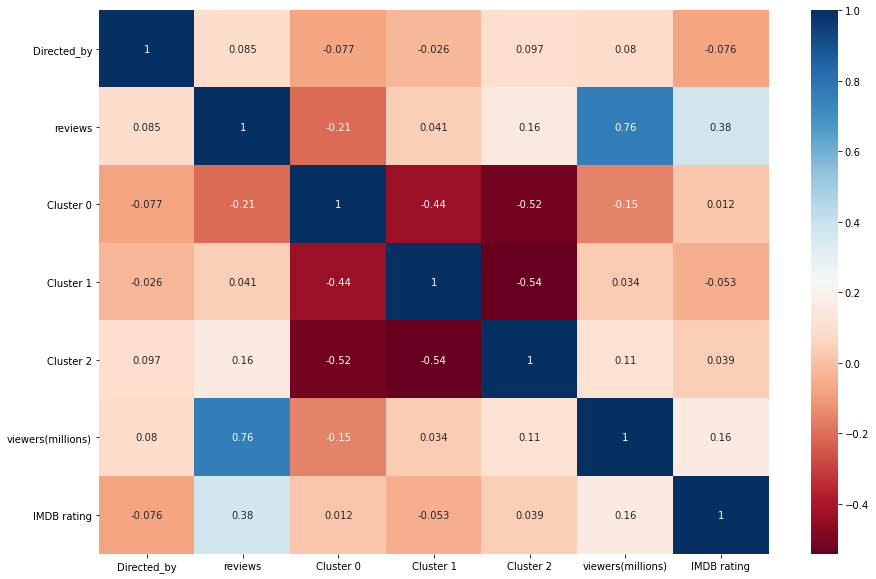

In [48]:
#Heat map - pela correlação de pearson para o Dataframe normalizado
fig, ax = plt.subplots(1,figsize=(15,10))
sns.heatmap(rescaled_dataset.corr(),ax=ax, annot=True, cmap='RdBu')

Mesmo com o dataset normalizado, não foi possível melhorar a correlação das variáveis com o que queremos predizer (nota_imdb). Vamos seguir na composição dos modelos para verificação.

<AxesSubplot:>

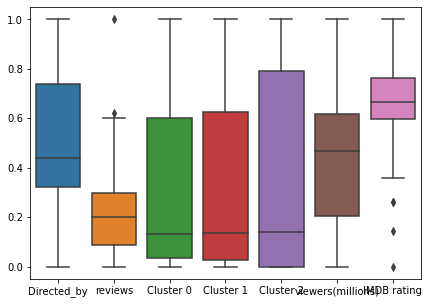

In [49]:
#Boxplot com dados normalizados
fig, ax = plt.subplots(1, figsize= (7,5))
sns.boxplot(ax = ax, data = rescaled_dataset)

In [50]:
#Verificação do kurtosis do dataset normalizado
#https://www.analyticsvidhya.com/blog/2021/05/shape-of-data-skewness-and-kurtosis/
from scipy.stats import norm, kurtosis
kurtosis(rescaled_dataset)

array([-0.87390838,  4.43295921, -0.72854419, -0.90910147, -1.56879455,
       -1.0224282 ,  2.35440014])

In [51]:
#Verificação do skewness do dataset normalizado
#https://www.analyticsvidhya.com/blog/2021/05/shape-of-data-skewness-and-kurtosis/
from scipy.stats import skew
skew(rescaled_dataset)

array([ 0.16534667,  1.33550959,  0.90638177,  0.853924  ,  0.41691668,
        0.01131822, -0.90079333])


It is important to note that the kurtosis of the variable to be predicted is positive and greater than 1, so there is a very large concentration of values in a given range and it also has a slightly negative skewness so most of the data are on the right (as seen in the histogram) .

In [52]:
# separando os atributos e a classe do dataset
array = dataset.values
X = array[:,0:6]
Y = array[:,6]

# definindo o tamanho do conjunto de teste
test_size = 0.20 

# A semente (seed) pode ser qualquer número, e garante que os resultados possam ser reproduzidos de forma idêntica toda vez que o script for rodado. 
# Isto é muito importante quando trabalhamos com modelos ou métodos que utilizam de algum tipo de aleatoriedade.
seed = 7

# particionando em conjuntos de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [53]:
#Criando um dataset para a variável a ser predita para facilitar o plot
Y_pd = pd.DataFrame(Y, columns = ['IMDB rating'])

In [54]:
dataset.head(20)

Directed_by  reviews  Cluster 0  Cluster 1  Cluster 2  viewers(millions)  \
0           9.0     7572   0.015196   0.191026   0.793778               4.14   
1           7.0     5731   0.014313   0.947105   0.038582               3.55   
2          18.0     5367   0.049773   0.876113   0.074114               3.51   
3          49.0     5071   0.110172   0.204996   0.684832               3.05   
4          40.0     5011   0.067190   0.908645   0.024165               3.75   
5          24.0     4749   0.694027   0.239949   0.066024               3.83   
6           8.0     4664   0.370087   0.495097   0.134817               3.74   
7          28.0     4539   0.097401   0.365292   0.537307               3.35   
8          25.0     4353   0.044557   0.627575   0.327868               3.11   
9          14.0     4454   0.010379   0.290684   0.698937               3.06   
10         41.0     4255   0.622315   0.228677   0.149008               3.14   
11         50.0     4295   0.052728   0.016578   0.930695               2.97   
12         18.0     4393   0.027321   0.969068   0.000000               2.96   
13         24.0     4678   0.675816   0.321618   0.000000               3.29   
14         14.0     4183   0.011332   0.137231   0.851437               3.15   
15         15.0     4364   0.439826   0.027487   0.532687               3.17   
16         18.0     4193   0.119365   0.872208   0.000000               3.02   
17         41.0     4086   0.800099   0.199779   0.000000               2.65   
18         39.0     4023   0.482060   0.087375   0.430566               2.92   
19         28.0     4090   0.996796   0.000000   0.000000               3.10   

    IMDB rating  
0           8.5  
1           8.2  
2           8.4  
3           8.3  
4           8.6  
5           7.9  
6           8.2  
7           8.1  
8           8.4  
9           7.8  
10          8.1  
11          8.4  
12          8.6  
13          8.8  
14          8.0  
15          8.7  
16          8.1  
17          8.3  
18          8.2  
19          8.5

In [55]:
#Reseting index do dataframe de Y
Y_pd = Y_pd.reset_index()

In [56]:
Y_pd.head()

index  IMDB rating
0      0          8.5
1      1          8.2
2      2          8.4
3      3          8.3
4      4          8.6

<AxesSubplot:>

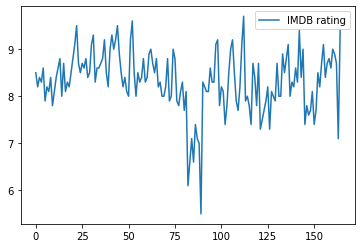

In [57]:
#Visualizando a nota para ver se cria algum insigth na estratégia de modelo
Y_pd.plot(y= 'IMDB rating')

In [58]:
#é preciso fazer reshape do Y_train para que possa ser transformado em rescaledy
Y_train = np.reshape(Y_train, (-1,1))

In [59]:
#Normalizando os datasets a serem utilizados para rescaledx e rescaledy
from sklearn.preprocessing import MinMaxScaler  
#Um scaler para cada (X e y), isso é necessário devido ao fato da transformada reversa de y ao fim
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

rescaledx = x_scaler.fit_transform(X_train) 
rescaledy = y_scaler.fit_transform(Y_train) 

### B) Model 1 - KNN

#### Test for X e Y não normalized

Finding the best K neighbors for the model.

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

scoring = 'neg_root_mean_squared_error'
kfold=10

#create new a knn model
knn2 = KNeighborsRegressor()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 17)} #limitado a 17 - aproximadamente 10% do dataset
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=kfold, scoring=scoring)
#fit model to data
knn_gscv.fit(X_train, Y_train)

# imprime o melhor resultado
print("Melhor: %f usando %s" % (knn_gscv.best_score_, knn_gscv.best_params_)) 

# imprime todos os resultados
means = knn_gscv.cv_results_['mean_test_score']
stds = knn_gscv.cv_results_['std_test_score']
params = knn_gscv.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f): %r" % (mean, stdev, param))

Melhor: -0.594616 usando {'n_neighbors': 16}
-0.737981 (0.262375): {'n_neighbors': 1}
-0.671527 (0.143327): {'n_neighbors': 2}
-0.630405 (0.185924): {'n_neighbors': 3}
-0.613123 (0.189808): {'n_neighbors': 4}
-0.614373 (0.208469): {'n_neighbors': 5}
-0.637474 (0.215789): {'n_neighbors': 6}
-0.629976 (0.216589): {'n_neighbors': 7}
-0.616418 (0.216145): {'n_neighbors': 8}
-0.621677 (0.204061): {'n_neighbors': 9}
-0.623938 (0.198369): {'n_neighbors': 10}
-0.618924 (0.200422): {'n_neighbors': 11}
-0.610675 (0.193647): {'n_neighbors': 12}
-0.607377 (0.196540): {'n_neighbors': 13}
-0.602031 (0.192719): {'n_neighbors': 14}
-0.599151 (0.194248): {'n_neighbors': 15}
-0.594616 (0.190095): {'n_neighbors': 16}


In [61]:
#apresenta os parâmetros do melhor modelo
knn_gscv.best_estimator_

KNeighborsRegressor(n_neighbors=16)

In [62]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

-0.594615636891678

In [63]:
#Predição e treinamento para K = 16

#Caso rode com outro dataset, esse ponto tem que ser atualizado
model_KNN = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=16, p=2,
                    weights='uniform')
model_KNN.fit(X_train, Y_train)  #fit the model
#Rodar um ou outro a depender se o X está sendo utilizado normalizado ou não
#inputs = x_scaler.transform(X_test)
inputs = X_test
pred_KNN = model_KNN.predict(inputs) #make prediction on test set
error = sqrt(mean_squared_error(Y_test,pred_KNN)) #calculate rmse
print('RMSE =', error)

RMSE = 0.6231392756183658


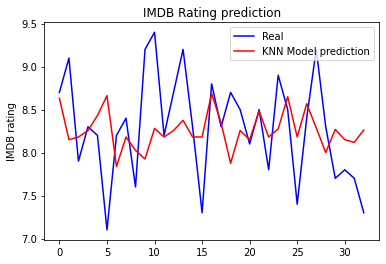

In [64]:
#Plot do modelo 
plt.plot(Y_test, color = 'blue', label = 'Real')
plt.plot(pred_KNN, color = 'red', label = 'KNN Model prediction')
plt.title('IMDB Rating prediction')
plt.ylabel('IMDB rating')
plt.legend()
plt.show()

Values were close to an average, he could not see the changes in values.

#### Tests for X e Y normalized

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

scoring = 'neg_root_mean_squared_error'
kfold=10

#create new a knn model
knn2 = KNeighborsRegressor()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1,17)} #limitado a 17 - aproximadamente 10% do dataset
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=kfold, scoring=scoring)
#fit model to data
knn_gscv.fit(rescaledx, rescaledy)

# imprime o melhor resultado
print("Melhor: %f usando %s" % (knn_gscv.best_score_, knn_gscv.best_params_)) 

# imprime todos os resultados
means = knn_gscv.cv_results_['mean_test_score']
stds = knn_gscv.cv_results_['std_test_score']
params = knn_gscv.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f): %r" % (mean, stdev, param))

Melhor: -0.152558 usando {'n_neighbors': 9}
-0.190680 (0.067347): {'n_neighbors': 1}
-0.165570 (0.046276): {'n_neighbors': 2}
-0.159078 (0.044696): {'n_neighbors': 3}
-0.158816 (0.048747): {'n_neighbors': 4}
-0.157430 (0.045021): {'n_neighbors': 5}
-0.156567 (0.036785): {'n_neighbors': 6}
-0.155415 (0.036252): {'n_neighbors': 7}
-0.153522 (0.037432): {'n_neighbors': 8}
-0.152558 (0.038416): {'n_neighbors': 9}
-0.153565 (0.038453): {'n_neighbors': 10}
-0.155514 (0.037162): {'n_neighbors': 11}
-0.155858 (0.035103): {'n_neighbors': 12}
-0.154558 (0.037522): {'n_neighbors': 13}
-0.153905 (0.036750): {'n_neighbors': 14}
-0.153668 (0.036000): {'n_neighbors': 15}
-0.153096 (0.035133): {'n_neighbors': 16}


In [66]:
#check top performing n_neighbors value
knn_gscv.best_params_


{'n_neighbors': 9}

In [67]:
#apresenta os parâmetros do melhor modelo
knn_gscv.best_estimator_

KNeighborsRegressor(n_neighbors=9)

In [68]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

-0.15255785039236097

In [69]:
#Predição e treinamento para K = 13

#Caso rode com outro dataset, esse ponto tem que ser atualizado
model_KNN = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                    weights='uniform')
model_KNN.fit(rescaledx, rescaledy)  #fit the model
#Rodar um ou outro a depender se o X está sendo utilizado normalizado ou não
inputs = x_scaler.transform(X_test)
#inputs = X_test
pred_KNN = model_KNN.predict(inputs) #make prediction on test set
pred_KNN = y_scaler.inverse_transform(pred_KNN)
error = sqrt(mean_squared_error(Y_test,pred_KNN)) #calculate rmse
print('RMSE =', error)

RMSE = 0.5922153531994744


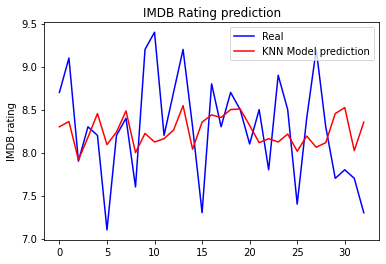

In [70]:
#Plot do modelo 
plt.plot(Y_test, color = 'blue', label = 'Real')
plt.plot(pred_KNN, color = 'red', label = 'KNN Model prediction')
plt.title('IMDB Rating prediction')
plt.ylabel('IMDB rating')
plt.legend()
plt.show()

RMSE improvement but with benefit for normalized X and Y.

Values were close to an average, he could not see the changes in values.




    #### Tests  for X normalized e Y withou modification

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

scoring = 'neg_root_mean_squared_error'
kfold=10

#create new a knn model
knn2 = KNeighborsRegressor(algorithm = 'ball_tree')
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 17)} #limitado a 17 - aproximadamente 10% do dataset
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=kfold, scoring=scoring)
#fit model to data
knn_gscv.fit(rescaledx, Y_train)

# imprime o melhor resultado
print("Melhor: %f usando %s" % (knn_gscv.best_score_, knn_gscv.best_params_)) 

# imprime todos os resultados
means = knn_gscv.cv_results_['mean_test_score']
stds = knn_gscv.cv_results_['std_test_score']
params = knn_gscv.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f): %r" % (mean, stdev, param))

Melhor: -0.640743 usando {'n_neighbors': 9}
-0.800857 (0.282856): {'n_neighbors': 1}
-0.695393 (0.194359): {'n_neighbors': 2}
-0.668127 (0.187725): {'n_neighbors': 3}
-0.667029 (0.204738): {'n_neighbors': 4}
-0.661204 (0.189088): {'n_neighbors': 5}
-0.657581 (0.154496): {'n_neighbors': 6}
-0.652744 (0.152258): {'n_neighbors': 7}
-0.644794 (0.157214): {'n_neighbors': 8}
-0.640743 (0.161346): {'n_neighbors': 9}
-0.644971 (0.161503): {'n_neighbors': 10}
-0.653158 (0.156082): {'n_neighbors': 11}
-0.654606 (0.147434): {'n_neighbors': 12}
-0.649143 (0.157593): {'n_neighbors': 13}
-0.646402 (0.154349): {'n_neighbors': 14}
-0.645407 (0.151201): {'n_neighbors': 15}
-0.643004 (0.147559): {'n_neighbors': 16}


In [72]:
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 9}

In [73]:
#apresenta os parâmetros do melhor modelo
knn_gscv.best_estimator_

KNeighborsRegressor(algorithm='ball_tree', n_neighbors=9)

In [74]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

-0.6407429716479158

In [75]:
#Predição e treinamento para K = 13

model_KNN = KNeighborsRegressor(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                    weights='uniform')
model_KNN.fit(rescaledx, Y_train)  #fit the model
#Rodar um ou outro a depender se o X está sendo utilizado normalizado ou não
inputs = x_scaler.transform(X_test)
#inputs = X_test
pred_KNN = model_KNN.predict(inputs) #make prediction on test set
error = sqrt(mean_squared_error(Y_test,pred_KNN)) #calculate rmse
print('RMSE =', error)

RMSE = 0.5922153531994748


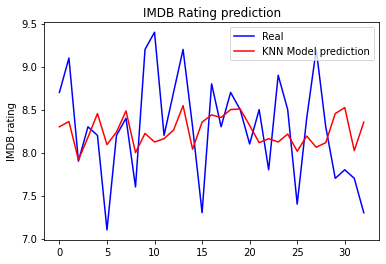

In [76]:
#Plot do modelo 
plt.plot(Y_test, color = 'blue', label = 'Real')
plt.plot(pred_KNN, color = 'red', label = 'KNN Model prediction')
plt.title('IMDB Rating prediction')
plt.ylabel('IMDB rating')
plt.legend()
plt.show()

Values were close to an average, he could not see the changes in values. Model was very similar to the process with the two normalized and the RMSE, however it was quite far from both normalized. The normalized values ​​of X and Y (IMDB grade) will be used.

#### Results for  KNN

Datasets with rescaledx and Y_train due to training results for all models are more reliable.

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                    weights='uniform')

In [77]:
#Predição e treinamento para K = 13

model_KNN = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                    weights='uniform')
model_KNN.fit(rescaledx, Y_train)  #fit the model
#Rodar um ou outro a depender se o X está sendo utilizado normalizado ou não
inputs = x_scaler.transform(X_test)
#inputs = X_test
pred_KNN=model_KNN.predict(inputs) #make prediction on test set
#pred_KNN = y_scaler.inverse_transform(pred_KNN)
error = sqrt(mean_squared_error(Y_test,pred_KNN)) #calculate rmse
print('RMSE =', error)

RMSE = 0.5922153531994748


In [78]:
errors = abs(pred_KNN - Y_test)

In [79]:
errors

array([[0.4       , 0.8       , 0.4       , ..., 0.5       , 0.6       ,
        1.        ],
       [0.33846154, 0.73846154, 0.46153846, ..., 0.56153846, 0.66153846,
        1.06153846],
       [0.78461538, 1.18461538, 0.01538462, ..., 0.11538462, 0.21538462,
        0.61538462],
       ...,
       [0.17692308, 0.57692308, 0.62307692, ..., 0.72307692, 0.82307692,
        1.22307692],
       [0.67692308, 1.07692308, 0.12307692, ..., 0.22307692, 0.32307692,
        0.72307692],
       [0.34615385, 0.74615385, 0.45384615, ..., 0.55384615, 0.65384615,
        1.05384615]])

In [80]:
stddev_knn_test = np.std(errors)
print ('Standard deviation Error KNN test: ', stddev_knn_test)

Standard deviation Error KNN test:  0.3608022072864726


In [81]:
len(X_test)

33

In [82]:
#Criando um dummy escolhido como 8.3 devido a mediana da população de nota de IMDB
#Essa criação se faz necessário para comparar a acurácia dos modelos e ter noção da mesma
dummy =[]
for i in range(len(X_test)):
  dummy.append(8.3)

In [83]:
#Erro dummy
error = sqrt(mean_squared_error(Y_test,dummy)) #calculate rmse
print('RMSE =', error)

RMSE = 0.5954371961386478


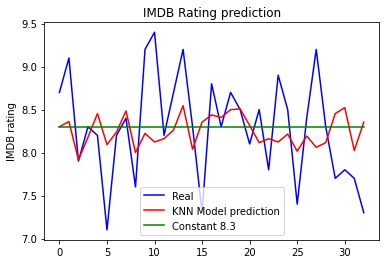

In [84]:
plt.plot(Y_test, color = 'blue', label = 'Real')
plt.plot(pred_KNN, color = 'red', label = 'KNN Model prediction')
plt.plot(dummy, color = 'green', label = 'Constant 8.3')
plt.title('IMDB Rating prediction')
plt.ylabel('IMDB rating')
plt.legend()
plt.show()

In [85]:
pred_KNN

array([[8.3       ],
       [8.36153846],
       [7.91538462],
       [8.17692308],
       [8.45384615],
       [8.09230769],
       [8.23846154],
       [8.48461538],
       [8.        ],
       [8.22307692],
       [8.12307692],
       [8.16153846],
       [8.26153846],
       [8.54615385],
       [8.03846154],
       [8.35384615],
       [8.43846154],
       [8.40769231],
       [8.5       ],
       [8.50769231],
       [8.31538462],
       [8.11538462],
       [8.16153846],
       [8.12307692],
       [8.21538462],
       [8.01538462],
       [8.19230769],
       [8.06153846],
       [8.11538462],
       [8.45384615],
       [8.52307692],
       [8.02307692],
       [8.35384615]])

In [86]:
var_knn = np.var(pred_KNN)
print ('Variância KNN: ', var_knn)

Variância KNN:  0.030654908417146298


In [87]:
mean_knn = np.mean(pred_KNN)
print ('Média KNN: ', mean_knn)

Média KNN:  8.25011655011655


Dummy error pretty much the same compared to the KNN results and the KNN follows without much variance close to an average of 8.3.

KNN test variance = 0.0531

Mean: 8,294



### C) Linear Regression

In [89]:
from sklearn.linear_model import LinearRegression
model_linear = LinearRegression()

#### Test for X and Y normalized

In [90]:
kfold = 10
scoring = 'neg_root_mean_squared_error' 
results = cross_val_score(model_linear, X_train, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0.5714157801362043


In [91]:
results

array([-0.42118834, -0.64117872, -0.86646783, -0.41970168, -0.36710808,
       -0.40253086, -0.48102305, -0.70162145, -0.39349709, -1.0198407 ])

In [92]:
stddev_linear_mod = np.std(results)
print ('Standard deviation Linear Regression: ', stddev_linear_mod)

Standard deviation Linear Regression:  0.21578603139483982


In [93]:
model_linear.fit(X_train, Y_train)  #fit the model
#Rodar um ou outro a depender se o X está sendo utilizado normalizado ou não
#inputs = x_scaler.transform(X_test)
inputs = X_test
pred_linear = model_linear.predict(inputs) #make prediction on test set
error = sqrt(mean_squared_error(Y_test,pred_linear)) #calculate rmse
print('RMSE =', error)

RMSE = 0.5435895663142819


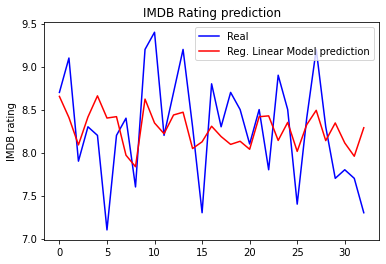

In [159]:
#Plot do modelo 
plt.plot(Y_test, color = 'blue', label = 'Real')
plt.plot(pred_linear, color = 'red', label = 'Reg. Linear Model prediction')
plt.title('IMDB Rating prediction')
plt.ylabel('IMDB rating')
plt.legend()
plt.show()

This model was able to visualize the downtrend a little and improved the RMSE compared to the KNN.

#### Teste for X and Y normalized

In [94]:
kfold = 10
scoring = 'neg_root_mean_squared_error' 
results = cross_val_score(model_linear, rescaledx, rescaledy, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0.1360513762229059


In [95]:
results

array([-0.10028294, -0.1526616 , -0.20630186, -0.09992897, -0.08740669,
       -0.09584068, -0.1145293 , -0.16705273, -0.09368978, -0.24281921])

In [96]:
stddev_linear_mod = np.std(results)
print ('Standard deviation Linear Regression: ', stddev_linear_mod)

Standard deviation Linear Regression:  0.051377626522580926


In [97]:
model_linear.fit(rescaledx, rescaledy)  #fit the model
#Rodar um ou outro a depender se o X está sendo utilizado normalizado ou não
inputs = x_scaler.transform(X_test)
#inputs = X_test
pred_linear = model_linear.predict(inputs) #make prediction on test set
pred_linear = y_scaler.inverse_transform(pred_linear)
error = sqrt(mean_squared_error(Y_test,pred_linear)) #calculate rmse
print('RMSE =', error)

RMSE = 0.5435895663142899


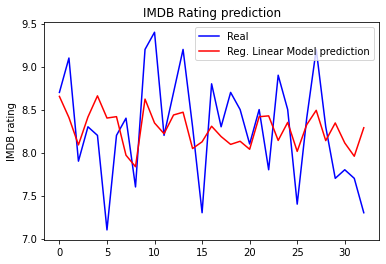

In [164]:
#Plot do modelo 
plt.plot(Y_test, color = 'blue', label = 'Real')
plt.plot(pred_linear, color = 'red', label = 'Reg. Linear Model prediction')
plt.title('IMDB Rating prediction')
plt.ylabel('IMDB rating')
plt.legend()
plt.show()

#### Test for X normalized and Y withou modifications

In [98]:
kfold = 10
scoring = 'neg_root_mean_squared_error' 
results = cross_val_score(model_linear, rescaledx, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0.5714157801362045


In [99]:
stddev_linear_mod = np.std(results)
print ('Standard deviation Linear Regression: ', stddev_linear_mod)

Standard deviation Linear Regression:  0.21578603139483976


In [100]:
model_linear.fit(rescaledx,Y_train)
#Rodar um ou outro a depender se o X está sendo utilizado normalizado ou não
inputs = x_scaler.transform(X_test)
#inputs = X_test
pred_linear=model_linear.predict(inputs) #make prediction on test set
error = sqrt(mean_squared_error(Y_test,pred_linear)) #calculate rmse
print('RMSE =', error)

RMSE = 0.54358956631429


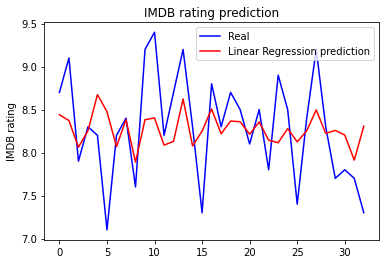

In [101]:
plt.plot(Y_test, color = 'blue', label = 'Real')
plt.plot(pred_linear, color = 'red', label = 'Linear Regression prediction')
plt.title('IMDB rating prediction')
plt.ylabel('IMDB rating')
plt.legend()
plt.show()

No significant changes using non-normalized or normalized data. For comparison purposes, we will use the normalized X and Y variables without modification as the RMSE values ​​are more reliable.

#### Results for linear regression

In [102]:
model_linear.fit(rescaledx, Y_train)  #fit the model
#Rodar um ou outro a depender se o X está sendo utilizado normalizado ou não
inputs = x_scaler.transform(X_test)
#inputs = X_test
pred_linear = model_linear.predict(inputs) #make prediction on test set
#pred_linear = y_scaler.inverse_transform(pred_linear)
error = sqrt(mean_squared_error(Y_test,pred_linear)) #calculate rmse
print('RMSE =', error)

RMSE = 0.54358956631429


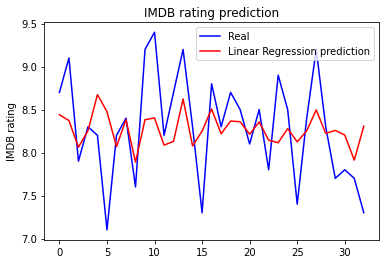

In [103]:
plt.plot(Y_test, color = 'blue', label = 'Real')
plt.plot(pred_linear, color = 'red', label = 'Linear Regression prediction')
plt.title('IMDB rating prediction')
plt.ylabel('IMDB rating')
plt.legend()
plt.show()

In [104]:
var_linear = np.var(pred_linear)
print ('Variância Linear Regression: ', var_linear)

Variância Linear Regression:  0.03234270621726011


In [105]:
mean_linear = np.mean(pred_linear)
print ('Média Linear Regression: ', mean_linear)

Média Linear Regression:  8.269898802050431


In [106]:
errors = abs(pred_linear - Y_test)

In [107]:
errors

array([[0.25948027, 0.65948027, 0.54051973, ..., 0.64051973, 0.74051973,
        1.14051973],
       [0.32767979, 0.72767979, 0.47232021, ..., 0.57232021, 0.67232021,
        1.07232021],
       [0.6372499 , 1.0372499 , 0.1627501 , ..., 0.2627501 , 0.3627501 ,
        0.7627501 ],
       ...,
       [0.49612731, 0.89612731, 0.30387269, ..., 0.40387269, 0.50387269,
        0.90387269],
       [0.78727327, 1.18727327, 0.01272673, ..., 0.11272673, 0.21272673,
        0.61272673],
       [0.39350088, 0.79350088, 0.40649912, ..., 0.50649912, 0.60649912,
        1.00649912]])

In [247]:
stddev_linear_test = np.std(errors)
print ('Standard deviation Error Linear Regression test: ', stddev_linear_test)

Standard deviation Error Linear Regression test:  0.3665240172077678


Linear Regression model error slightly better than Dummy. follows without much variance close to an average at 8.3.

KNN test variance = 0.0425

Average: 8,269

### D) SVM

#### test for X and Y normalized

In the case of SVM, tests will be used only with the X variables normalized due to the execution time.

Running GridSearch for better SVM parameters

In [108]:
#Tuning do SVM
#Gridsearch para Tunning de SVM
from sklearn.svm import SVR

c_values = [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 10.0, 15.0, 20.0]
kernel_values = ['linear', 'rbf', 'poly','sigmoid']  
param_grid = dict(C=c_values, kernel=kernel_values)

# modelo
model_svm = SVR(gamma='auto')
kfold = 10

# busca exaustiva de hiperparâmetros com GridSearchCV
grid = GridSearchCV(estimator=model_svm, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_svm_result = grid.fit(rescaledx, rescaledy)

# imprime o melhor resultado
print("Melhor: %f usando %s" % (grid_svm_result.best_score_, grid_svm_result.best_params_)) 

# imprime todos os resultados
means = grid_svm_result.cv_results_['mean_test_score']
stds = grid_svm_result.cv_results_['std_test_score']
params = grid_svm_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f): %r" % (mean, stdev, param))

Melhor: -0.131988 usando {'C': 5.0, 'kernel': 'sigmoid'}
-0.147699 (0.040958): {'C': 0.01, 'kernel': 'linear'}
-0.149462 (0.040209): {'C': 0.01, 'kernel': 'rbf'}
-0.150044 (0.039784): {'C': 0.01, 'kernel': 'poly'}
-0.149676 (0.040056): {'C': 0.01, 'kernel': 'sigmoid'}
-0.139468 (0.046648): {'C': 0.1, 'kernel': 'linear'}
-0.144293 (0.041664): {'C': 0.1, 'kernel': 'rbf'}
-0.149382 (0.040055): {'C': 0.1, 'kernel': 'poly'}
-0.146312 (0.041301): {'C': 0.1, 'kernel': 'sigmoid'}
-0.133454 (0.052690): {'C': 0.5, 'kernel': 'linear'}
-0.139186 (0.046408): {'C': 0.5, 'kernel': 'rbf'}
-0.147623 (0.041062): {'C': 0.5, 'kernel': 'poly'}
-0.140625 (0.046177): {'C': 0.5, 'kernel': 'sigmoid'}
-0.133143 (0.053201): {'C': 1.0, 'kernel': 'linear'}
-0.137038 (0.049004): {'C': 1.0, 'kernel': 'rbf'}
-0.144995 (0.041481): {'C': 1.0, 'kernel': 'poly'}
-0.138201 (0.047600): {'C': 1.0, 'kernel': 'sigmoid'}
-0.133334 (0.053461): {'C': 2.5, 'kernel': 'linear'}
-0.136116 (0.050957): {'C': 2.5, 'kernel': 'rbf'}
-0.1

In [109]:
grid_svm_result.best_params_

{'C': 5.0, 'kernel': 'sigmoid'}

In [110]:
model_svm = SVR(gamma='auto', C= 5.0, kernel= 'sigmoid')

In [111]:
model_svm

SVR(C=5.0, gamma='auto', kernel='sigmoid')

In [112]:
model_svm.fit(rescaledx,rescaledy)
#Rodar um ou outro a depender se o X está sendo utilizado normalizado ou não
inputs = x_scaler.transform(X_test)
#inputs = X_test
pred_svm = model_svm.predict(inputs) #make prediction on test set
pred_svm = np.reshape(pred_svm, (-1,1))
pred_svm = y_scaler.inverse_transform(pred_svm)
error = sqrt(mean_squared_error(Y_test,pred_svm)) #calculate rmse
print('RMSE =', error)

RMSE = 0.5791293183917154


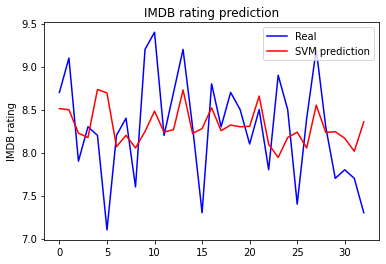

In [113]:
plt.plot(Y_test, color = 'blue', label = 'Real')
plt.plot(pred_svm, color = 'red', label = 'SVM prediction')
plt.title('IMDB rating prediction')
plt.ylabel('IMDB rating')
plt.legend()
plt.show()

####T este para X normalizado e Y sem modificações

In [186]:
#Tuning do SVM
#Gridsearch para Tunning de SVM
from sklearn.svm import SVR

c_values = [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 10.0, 15.0, 20.0]
kernel_values = ['linear', 'rbf', 'poly','sigmoid']  
param_grid = dict(C=c_values, kernel=kernel_values)

# modelo
model_svm = SVR(gamma='auto')
kfold = 10

# busca exaustiva de hiperparâmetros com GridSearchCV
grid = GridSearchCV(estimator=model_svm, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_svm_result = grid.fit(rescaledx, Y_train)

# imprime o melhor resultado
print("Melhor: %f usando %s" % (grid_svm_result.best_score_, grid_svm_result.best_params_)) 

# imprime todos os resultados
means = grid_svm_result.cv_results_['mean_test_score']
stds = grid_svm_result.cv_results_['std_test_score']
params = grid_svm_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f): %r" % (mean, stdev, param))

Melhor: -0.537115 usando {'C': 10.0, 'kernel': 'sigmoid'}
-0.617419 (0.167414): {'C': 0.01, 'kernel': 'linear'}
-0.630169 (0.164007): {'C': 0.01, 'kernel': 'rbf'}
-0.636653 (0.162776): {'C': 0.01, 'kernel': 'poly'}
-0.633040 (0.163499): {'C': 0.01, 'kernel': 'sigmoid'}
-0.589328 (0.177908): {'C': 0.1, 'kernel': 'linear'}
-0.611680 (0.172906): {'C': 0.1, 'kernel': 'rbf'}
-0.633912 (0.163185): {'C': 0.1, 'kernel': 'poly'}
-0.614819 (0.169258): {'C': 0.1, 'kernel': 'sigmoid'}
-0.552463 (0.210210): {'C': 0.5, 'kernel': 'linear'}
-0.587886 (0.180486): {'C': 0.5, 'kernel': 'rbf'}
-0.624515 (0.164345): {'C': 0.5, 'kernel': 'poly'}
-0.592177 (0.177215): {'C': 0.5, 'kernel': 'sigmoid'}
-0.544454 (0.221718): {'C': 1.0, 'kernel': 'linear'}
-0.576489 (0.192518): {'C': 1.0, 'kernel': 'rbf'}
-0.618028 (0.165585): {'C': 1.0, 'kernel': 'poly'}
-0.581558 (0.185324): {'C': 1.0, 'kernel': 'sigmoid'}
-0.542705 (0.232593): {'C': 2.5, 'kernel': 'linear'}
-0.559380 (0.206958): {'C': 2.5, 'kernel': 'rbf'}
-0.

In [188]:
model_svm = SVR(gamma='auto', C= 10.0, kernel= 'sigmoid')

In [189]:
model_svm.fit(rescaledx,Y_train)
#Rodar um ou outro a depender se o X está sendo utilizado normalizado ou não
inputs = x_scaler.transform(X_test)
#inputs = X_test
pred_svm = model_svm.predict(inputs) #make prediction on test set
#pred_svm = np.reshape(pred_svm, (-1,1))
#pred_svm = y_scaler.inverse_transform(pred_svm)
error = sqrt(mean_squared_error(Y_test,pred_svm)) #calculate rmse
print('RMSE =', error)

RMSE = 0.543809301862112


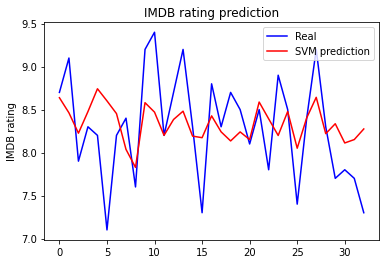

In [190]:
plt.plot(Y_test, color = 'blue', label = 'Real')
plt.plot(pred_svm, color = 'red', label = 'SVM prediction')
plt.title('IMDB rating prediction')
plt.ylabel('IMDB rating')
plt.legend()
plt.show()

Como este será o dataset utilizado para todos, manteremos as informações de variância e média das predições desse modelo.

In [191]:
var_svm = np.var(pred_svm)
print ('Variância SVM: ', var_svm)

Variância SVM:  0.042183678624376


In [193]:
mean_svm = np.mean(pred_svm)
print ('Média SVM: ', mean_svm)

Média SVM:  8.332971039959956


Erro do modelo SVM ligeiramente melhor que o do Dummy. segue sem muita variância próximo de uma média em 8,3.

Variância do teste de KNN = 0,0421

Média: 8,332

###E) CatBoost

#### Test for X normalized and Y withou modifications

In [115]:
import catboost as cb

In [116]:
#model_cat = cb.CatBoostRegressor(loss_function='RMSE', depth= 4, l2_leaf_reg=3, learning_rate= 0.1)

In [117]:
from catboost import CatBoostRegressor
import numpy as np

model_cat = CatBoostRegressor(loss_function='RMSE')

grid = {'learning_rate': [0.03, 0.1, 0.2],
        'depth': [4, 6, 10, 20, 30],
        'l2_leaf_reg': [1, 3, 5, 7, 9, 12, 15]}

grid_search_result = model_cat.grid_search(grid, 
                                       X=rescaledx, 
                                       y=Y_train, 
                                       plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 8.1506429	test: 8.0552787	best: 8.0552787 (0)	total: 46.6ms	remaining: 46.6s
1:	learn: 7.9221376	test: 7.8358774	best: 7.8358774 (1)	total: 47ms	remaining: 23.5s
2:	learn: 7.7031713	test: 7.6219427	best: 7.6219427 (2)	total: 47.2ms	remaining: 15.7s
3:	learn: 7.4904942	test: 7.4267916	best: 7.4267916 (3)	total: 47.4ms	remaining: 11.8s
4:	learn: 7.2817822	test: 7.2185812	best: 7.2185812 (4)	total: 47.7ms	remaining: 9.49s
5:	learn: 7.0827496	test: 7.0191736	best: 7.0191736 (5)	total: 49ms	remaining: 8.12s
6:	learn: 6.8893036	test: 6.8264101	best: 6.8264101 (6)	total: 49.6ms	remaining: 7.04s
7:	learn: 6.7024522	test: 6.6378096	best: 6.6378096 (7)	total: 49.9ms	remaining: 6.19s
8:	learn: 6.5120128	test: 6.4549115	best: 6.4549115 (8)	total: 50.1ms	remaining: 5.52s
9:	learn: 6.3254456	test: 6.2693454	best: 6.2693454 (9)	total: 50.5ms	remaining: 5s
10:	learn: 6.1488834	test: 6.0936325	best: 6.0936325 (10)	total: 51.1ms	remaining: 4.59s
11:	learn: 5.9758775	test: 5.9237202	best: 5.923

40:	learn: 0.5032243	test: 0.8966227	best: 0.8966227 (40)	total: 10.8ms	remaining: 253ms
41:	learn: 0.4957779	test: 0.8965099	best: 0.8965099 (41)	total: 11.4ms	remaining: 261ms
42:	learn: 0.4854134	test: 0.8946782	best: 0.8946782 (42)	total: 12ms	remaining: 266ms
43:	learn: 0.4798806	test: 0.8893953	best: 0.8893953 (43)	total: 12.6ms	remaining: 274ms
44:	learn: 0.4738297	test: 0.8877843	best: 0.8877843 (44)	total: 13.1ms	remaining: 278ms
45:	learn: 0.4552708	test: 0.8912482	best: 0.8877843 (44)	total: 13.6ms	remaining: 283ms
46:	learn: 0.4496767	test: 0.8845201	best: 0.8845201 (46)	total: 13.8ms	remaining: 280ms
47:	learn: 0.4361341	test: 0.8877038	best: 0.8845201 (46)	total: 14ms	remaining: 277ms
48:	learn: 0.4307856	test: 0.8870392	best: 0.8845201 (46)	total: 14.1ms	remaining: 274ms
49:	learn: 0.4253771	test: 0.8819046	best: 0.8819046 (49)	total: 14.3ms	remaining: 271ms
50:	learn: 0.4189050	test: 0.8828470	best: 0.8819046 (49)	total: 14.4ms	remaining: 269ms
51:	learn: 0.4064054	test

695:	learn: 0.0041149	test: 0.8690884	best: 0.8499284 (77)	total: 201ms	remaining: 87.9ms
696:	learn: 0.0040699	test: 0.8690751	best: 0.8499284 (77)	total: 202ms	remaining: 87.8ms
697:	learn: 0.0040404	test: 0.8690818	best: 0.8499284 (77)	total: 202ms	remaining: 87.6ms
698:	learn: 0.0039983	test: 0.8690830	best: 0.8499284 (77)	total: 203ms	remaining: 87.3ms
699:	learn: 0.0039566	test: 0.8690720	best: 0.8499284 (77)	total: 203ms	remaining: 87.1ms
700:	learn: 0.0039349	test: 0.8690788	best: 0.8499284 (77)	total: 204ms	remaining: 86.9ms
701:	learn: 0.0039026	test: 0.8690763	best: 0.8499284 (77)	total: 205ms	remaining: 87.1ms
702:	learn: 0.0038857	test: 0.8690885	best: 0.8499284 (77)	total: 206ms	remaining: 87ms
703:	learn: 0.0038576	test: 0.8690763	best: 0.8499284 (77)	total: 206ms	remaining: 86.8ms
704:	learn: 0.0038412	test: 0.8690769	best: 0.8499284 (77)	total: 207ms	remaining: 86.4ms
705:	learn: 0.0037861	test: 0.8690785	best: 0.8499284 (77)	total: 207ms	remaining: 86.1ms
706:	learn: 

615:	learn: 0.0001015	test: 0.8887948	best: 0.8818291 (179)	total: 102ms	remaining: 63.9ms
616:	learn: 0.0001000	test: 0.8887943	best: 0.8818291 (179)	total: 103ms	remaining: 63.7ms
617:	learn: 0.0000989	test: 0.8887947	best: 0.8818291 (179)	total: 103ms	remaining: 63.5ms
618:	learn: 0.0000967	test: 0.8887971	best: 0.8818291 (179)	total: 103ms	remaining: 63.4ms
619:	learn: 0.0000962	test: 0.8887976	best: 0.8818291 (179)	total: 103ms	remaining: 63.3ms
620:	learn: 0.0000958	test: 0.8887976	best: 0.8818291 (179)	total: 103ms	remaining: 63.1ms
621:	learn: 0.0000933	test: 0.8887984	best: 0.8818291 (179)	total: 104ms	remaining: 63ms
622:	learn: 0.0000922	test: 0.8887989	best: 0.8818291 (179)	total: 104ms	remaining: 62.8ms
623:	learn: 0.0000912	test: 0.8887994	best: 0.8818291 (179)	total: 104ms	remaining: 62.7ms
624:	learn: 0.0000895	test: 0.8887988	best: 0.8818291 (179)	total: 104ms	remaining: 62.5ms
625:	learn: 0.0000883	test: 0.8887988	best: 0.8818291 (179)	total: 104ms	remaining: 62.4ms
6

565:	learn: 0.2150581	test: 0.8804969	best: 0.8804969 (565)	total: 85.6ms	remaining: 65.7ms
566:	learn: 0.2149224	test: 0.8806430	best: 0.8804969 (565)	total: 85.8ms	remaining: 65.5ms
567:	learn: 0.2143416	test: 0.8803431	best: 0.8803431 (567)	total: 86ms	remaining: 65.4ms
568:	learn: 0.2141086	test: 0.8803601	best: 0.8803431 (567)	total: 86.1ms	remaining: 65.2ms
569:	learn: 0.2139188	test: 0.8804149	best: 0.8803431 (567)	total: 86.3ms	remaining: 65.1ms
570:	learn: 0.2133846	test: 0.8803382	best: 0.8803382 (570)	total: 86.4ms	remaining: 64.9ms
571:	learn: 0.2128884	test: 0.8800854	best: 0.8800854 (571)	total: 86.6ms	remaining: 64.8ms
572:	learn: 0.2125687	test: 0.8797669	best: 0.8797669 (572)	total: 86.7ms	remaining: 64.6ms
573:	learn: 0.2123913	test: 0.8797654	best: 0.8797654 (573)	total: 86.9ms	remaining: 64.5ms
574:	learn: 0.2122800	test: 0.8798402	best: 0.8797654 (573)	total: 87ms	remaining: 64.3ms
575:	learn: 0.2115022	test: 0.8791137	best: 0.8791137 (575)	total: 87.2ms	remaining:

410:	learn: 0.0670825	test: 0.9066381	best: 0.9046950 (87)	total: 77ms	remaining: 110ms
411:	learn: 0.0666446	test: 0.9066274	best: 0.9046950 (87)	total: 77.2ms	remaining: 110ms
412:	learn: 0.0661119	test: 0.9064842	best: 0.9046950 (87)	total: 77.3ms	remaining: 110ms
413:	learn: 0.0656510	test: 0.9068415	best: 0.9046950 (87)	total: 77.5ms	remaining: 110ms
414:	learn: 0.0653207	test: 0.9069377	best: 0.9046950 (87)	total: 77.6ms	remaining: 109ms
415:	learn: 0.0648449	test: 0.9069979	best: 0.9046950 (87)	total: 77.8ms	remaining: 109ms
416:	learn: 0.0644457	test: 0.9067799	best: 0.9046950 (87)	total: 77.9ms	remaining: 109ms
417:	learn: 0.0642624	test: 0.9067537	best: 0.9046950 (87)	total: 78.1ms	remaining: 109ms
418:	learn: 0.0635301	test: 0.9064400	best: 0.9046950 (87)	total: 78.2ms	remaining: 108ms
419:	learn: 0.0631921	test: 0.9062800	best: 0.9046950 (87)	total: 78.4ms	remaining: 108ms
420:	learn: 0.0629454	test: 0.9061231	best: 0.9046950 (87)	total: 78.7ms	remaining: 108ms
421:	learn: 

354:	learn: 0.0137839	test: 0.8963932	best: 0.8860000 (127)	total: 57.4ms	remaining: 104ms
355:	learn: 0.0136498	test: 0.8963232	best: 0.8860000 (127)	total: 57.7ms	remaining: 104ms
356:	learn: 0.0134354	test: 0.8963507	best: 0.8860000 (127)	total: 57.8ms	remaining: 104ms
357:	learn: 0.0133619	test: 0.8963455	best: 0.8860000 (127)	total: 58ms	remaining: 104ms
358:	learn: 0.0132487	test: 0.8963508	best: 0.8860000 (127)	total: 58.1ms	remaining: 104ms
359:	learn: 0.0131057	test: 0.8963537	best: 0.8860000 (127)	total: 58.3ms	remaining: 104ms
360:	learn: 0.0129834	test: 0.8961743	best: 0.8860000 (127)	total: 58.4ms	remaining: 103ms
361:	learn: 0.0128369	test: 0.8963274	best: 0.8860000 (127)	total: 58.6ms	remaining: 103ms
362:	learn: 0.0127220	test: 0.8962560	best: 0.8860000 (127)	total: 58.7ms	remaining: 103ms
363:	learn: 0.0126432	test: 0.8963503	best: 0.8860000 (127)	total: 58.8ms	remaining: 103ms
364:	learn: 0.0124120	test: 0.8964402	best: 0.8860000 (127)	total: 59ms	remaining: 103ms
365

900:	learn: 0.0000802	test: 0.8974122	best: 0.8860000 (127)	total: 249ms	remaining: 27.4ms
901:	learn: 0.0000794	test: 0.8974120	best: 0.8860000 (127)	total: 250ms	remaining: 27.1ms
902:	learn: 0.0000790	test: 0.8974116	best: 0.8860000 (127)	total: 250ms	remaining: 26.9ms
903:	learn: 0.0000774	test: 0.8974123	best: 0.8860000 (127)	total: 251ms	remaining: 26.6ms
904:	learn: 0.0000770	test: 0.8974124	best: 0.8860000 (127)	total: 251ms	remaining: 26.3ms
905:	learn: 0.0000766	test: 0.8974120	best: 0.8860000 (127)	total: 251ms	remaining: 26ms
906:	learn: 0.0000760	test: 0.8974124	best: 0.8860000 (127)	total: 251ms	remaining: 25.7ms
907:	learn: 0.0000757	test: 0.8974123	best: 0.8860000 (127)	total: 251ms	remaining: 25.5ms
908:	learn: 0.0000755	test: 0.8974120	best: 0.8860000 (127)	total: 252ms	remaining: 25.2ms
909:	learn: 0.0000752	test: 0.8974119	best: 0.8860000 (127)	total: 252ms	remaining: 24.9ms
910:	learn: 0.0000749	test: 0.8974121	best: 0.8860000 (127)	total: 252ms	remaining: 24.6ms
9

724:	learn: 0.2060818	test: 0.8675852	best: 0.8672093 (706)	total: 129ms	remaining: 49ms
725:	learn: 0.2054835	test: 0.8672229	best: 0.8672093 (706)	total: 129ms	remaining: 48.8ms
726:	learn: 0.2054039	test: 0.8672472	best: 0.8672093 (706)	total: 130ms	remaining: 48.7ms
727:	learn: 0.2047762	test: 0.8675122	best: 0.8672093 (706)	total: 130ms	remaining: 48.5ms
728:	learn: 0.2046134	test: 0.8674834	best: 0.8672093 (706)	total: 130ms	remaining: 48.3ms
729:	learn: 0.2041392	test: 0.8668786	best: 0.8668786 (729)	total: 130ms	remaining: 48.1ms
730:	learn: 0.2039814	test: 0.8667302	best: 0.8667302 (730)	total: 130ms	remaining: 47.9ms
731:	learn: 0.2036970	test: 0.8664121	best: 0.8664121 (731)	total: 130ms	remaining: 47.7ms
732:	learn: 0.2033473	test: 0.8661077	best: 0.8661077 (732)	total: 130ms	remaining: 47.5ms
733:	learn: 0.2032637	test: 0.8661422	best: 0.8661077 (732)	total: 131ms	remaining: 47.3ms
734:	learn: 0.2030584	test: 0.8660922	best: 0.8660922 (734)	total: 131ms	remaining: 47.1ms
7

750:	learn: 0.0286019	test: 0.9259870	best: 0.9200328 (437)	total: 114ms	remaining: 37.9ms
751:	learn: 0.0284879	test: 0.9260698	best: 0.9200328 (437)	total: 114ms	remaining: 37.7ms
752:	learn: 0.0284075	test: 0.9260696	best: 0.9200328 (437)	total: 115ms	remaining: 37.6ms
753:	learn: 0.0283016	test: 0.9261675	best: 0.9200328 (437)	total: 115ms	remaining: 37.4ms
754:	learn: 0.0282195	test: 0.9262440	best: 0.9200328 (437)	total: 115ms	remaining: 37.3ms
755:	learn: 0.0281373	test: 0.9262719	best: 0.9200328 (437)	total: 115ms	remaining: 37.1ms
756:	learn: 0.0280583	test: 0.9262986	best: 0.9200328 (437)	total: 115ms	remaining: 37ms
757:	learn: 0.0280042	test: 0.9263016	best: 0.9200328 (437)	total: 115ms	remaining: 36.8ms
758:	learn: 0.0279860	test: 0.9263435	best: 0.9200328 (437)	total: 115ms	remaining: 36.7ms
759:	learn: 0.0278782	test: 0.9263488	best: 0.9200328 (437)	total: 116ms	remaining: 36.5ms
760:	learn: 0.0278507	test: 0.9263165	best: 0.9200328 (437)	total: 116ms	remaining: 36.4ms
7

626:	learn: 0.0050791	test: 0.9116255	best: 0.9058573 (127)	total: 100ms	remaining: 59.6ms
627:	learn: 0.0050748	test: 0.9116119	best: 0.9058573 (127)	total: 100ms	remaining: 59.5ms
628:	learn: 0.0050667	test: 0.9116125	best: 0.9058573 (127)	total: 101ms	remaining: 59.3ms
629:	learn: 0.0050559	test: 0.9116018	best: 0.9058573 (127)	total: 101ms	remaining: 59.1ms
630:	learn: 0.0050072	test: 0.9116140	best: 0.9058573 (127)	total: 101ms	remaining: 59ms
631:	learn: 0.0049894	test: 0.9116138	best: 0.9058573 (127)	total: 101ms	remaining: 58.8ms
632:	learn: 0.0049669	test: 0.9116617	best: 0.9058573 (127)	total: 101ms	remaining: 58.6ms
633:	learn: 0.0049614	test: 0.9116729	best: 0.9058573 (127)	total: 101ms	remaining: 58.5ms
634:	learn: 0.0048942	test: 0.9117234	best: 0.9058573 (127)	total: 102ms	remaining: 58.5ms
635:	learn: 0.0048413	test: 0.9117295	best: 0.9058573 (127)	total: 102ms	remaining: 58.6ms
636:	learn: 0.0047810	test: 0.9117173	best: 0.9058573 (127)	total: 103ms	remaining: 58.6ms
6

591:	learn: 0.2713608	test: 0.9218172	best: 0.9217466 (590)	total: 90ms	remaining: 62ms
592:	learn: 0.2713055	test: 0.9217801	best: 0.9217466 (590)	total: 90.5ms	remaining: 62.1ms
593:	learn: 0.2711841	test: 0.9218925	best: 0.9217466 (590)	total: 91ms	remaining: 62.2ms
594:	learn: 0.2708692	test: 0.9220555	best: 0.9217466 (590)	total: 91.6ms	remaining: 62.4ms
595:	learn: 0.2708131	test: 0.9220419	best: 0.9217466 (590)	total: 92ms	remaining: 62.4ms
596:	learn: 0.2698693	test: 0.9226609	best: 0.9217466 (590)	total: 92.4ms	remaining: 62.3ms
597:	learn: 0.2698012	test: 0.9227706	best: 0.9217466 (590)	total: 92.7ms	remaining: 62.3ms
598:	learn: 0.2694818	test: 0.9225986	best: 0.9217466 (590)	total: 94.1ms	remaining: 63ms
599:	learn: 0.2692303	test: 0.9225987	best: 0.9217466 (590)	total: 94.7ms	remaining: 63.1ms
600:	learn: 0.2690840	test: 0.9225716	best: 0.9217466 (590)	total: 95.2ms	remaining: 63.2ms
601:	learn: 0.2690077	test: 0.9226721	best: 0.9217466 (590)	total: 95.8ms	remaining: 63.3m

507:	learn: 0.0917740	test: 0.9350558	best: 0.9346671 (493)	total: 80.3ms	remaining: 77.8ms
508:	learn: 0.0913880	test: 0.9349964	best: 0.9346671 (493)	total: 80.5ms	remaining: 77.6ms
509:	learn: 0.0913549	test: 0.9350171	best: 0.9346671 (493)	total: 80.6ms	remaining: 77.4ms
510:	learn: 0.0912726	test: 0.9349510	best: 0.9346671 (493)	total: 80.7ms	remaining: 77.2ms
511:	learn: 0.0912056	test: 0.9349480	best: 0.9346671 (493)	total: 80.8ms	remaining: 77ms
512:	learn: 0.0907836	test: 0.9348571	best: 0.9346671 (493)	total: 81ms	remaining: 76.9ms
513:	learn: 0.0905420	test: 0.9348437	best: 0.9346671 (493)	total: 81.1ms	remaining: 76.7ms
514:	learn: 0.0904970	test: 0.9349093	best: 0.9346671 (493)	total: 81.2ms	remaining: 76.5ms
515:	learn: 0.0904209	test: 0.9349111	best: 0.9346671 (493)	total: 81.3ms	remaining: 76.3ms
516:	learn: 0.0903600	test: 0.9348863	best: 0.9346671 (493)	total: 81.5ms	remaining: 76.1ms
517:	learn: 0.0901840	test: 0.9346921	best: 0.9346671 (493)	total: 81.6ms	remaining:

479:	learn: 0.0227743	test: 0.8996732	best: 0.8945731 (300)	total: 75.5ms	remaining: 81.7ms
480:	learn: 0.0225371	test: 0.8998120	best: 0.8945731 (300)	total: 76ms	remaining: 82ms
481:	learn: 0.0225039	test: 0.8998272	best: 0.8945731 (300)	total: 76.4ms	remaining: 82.1ms
482:	learn: 0.0223336	test: 0.8998251	best: 0.8945731 (300)	total: 76.9ms	remaining: 82.4ms
483:	learn: 0.0222120	test: 0.8996951	best: 0.8945731 (300)	total: 77.4ms	remaining: 82.5ms
484:	learn: 0.0221055	test: 0.8997877	best: 0.8945731 (300)	total: 77.8ms	remaining: 82.7ms
485:	learn: 0.0219137	test: 0.8999263	best: 0.8945731 (300)	total: 78.4ms	remaining: 83ms
486:	learn: 0.0218330	test: 0.8999365	best: 0.8945731 (300)	total: 78.9ms	remaining: 83.1ms
487:	learn: 0.0216578	test: 0.9000711	best: 0.8945731 (300)	total: 79.3ms	remaining: 83.2ms
488:	learn: 0.0215958	test: 0.9001421	best: 0.8945731 (300)	total: 79.9ms	remaining: 83.5ms
489:	learn: 0.0215817	test: 0.9001005	best: 0.8945731 (300)	total: 80.3ms	remaining: 8

373:	learn: 0.3808742	test: 0.9491223	best: 0.9488232 (372)	total: 61.6ms	remaining: 103ms
374:	learn: 0.3805016	test: 0.9490227	best: 0.9488232 (372)	total: 62.2ms	remaining: 104ms
375:	learn: 0.3802029	test: 0.9491099	best: 0.9488232 (372)	total: 62.6ms	remaining: 104ms
376:	learn: 0.3793868	test: 0.9492701	best: 0.9488232 (372)	total: 63.2ms	remaining: 104ms
377:	learn: 0.3790311	test: 0.9492489	best: 0.9488232 (372)	total: 63.7ms	remaining: 105ms
378:	learn: 0.3786938	test: 0.9487104	best: 0.9487104 (378)	total: 64.2ms	remaining: 105ms
379:	learn: 0.3778974	test: 0.9488084	best: 0.9487104 (378)	total: 64.7ms	remaining: 106ms
380:	learn: 0.3769721	test: 0.9487672	best: 0.9487104 (378)	total: 65.2ms	remaining: 106ms
381:	learn: 0.3756547	test: 0.9490773	best: 0.9487104 (378)	total: 65.7ms	remaining: 106ms
382:	learn: 0.3743607	test: 0.9493283	best: 0.9487104 (378)	total: 66.2ms	remaining: 107ms
383:	learn: 0.3730947	test: 0.9496492	best: 0.9487104 (378)	total: 66.8ms	remaining: 107ms

282:	learn: 0.2189937	test: 0.9157424	best: 0.9152661 (278)	total: 45ms	remaining: 114ms
283:	learn: 0.2183529	test: 0.9160521	best: 0.9152661 (278)	total: 47.6ms	remaining: 120ms
284:	learn: 0.2178676	test: 0.9161383	best: 0.9152661 (278)	total: 48.2ms	remaining: 121ms
285:	learn: 0.2168903	test: 0.9165478	best: 0.9152661 (278)	total: 48.8ms	remaining: 122ms
286:	learn: 0.2166836	test: 0.9164636	best: 0.9152661 (278)	total: 49.4ms	remaining: 123ms
287:	learn: 0.2154171	test: 0.9162046	best: 0.9152661 (278)	total: 49.8ms	remaining: 123ms
288:	learn: 0.2146790	test: 0.9165585	best: 0.9152661 (278)	total: 50.4ms	remaining: 124ms
289:	learn: 0.2142290	test: 0.9165929	best: 0.9152661 (278)	total: 50.9ms	remaining: 125ms
290:	learn: 0.2131119	test: 0.9151173	best: 0.9151173 (290)	total: 51.3ms	remaining: 125ms
291:	learn: 0.2119666	test: 0.9160038	best: 0.9151173 (290)	total: 51.8ms	remaining: 126ms
292:	learn: 0.2112813	test: 0.9160073	best: 0.9151173 (290)	total: 52.3ms	remaining: 126ms
2

208:	learn: 0.1442324	test: 0.9082755	best: 0.9078761 (204)	total: 32.3ms	remaining: 122ms
209:	learn: 0.1428162	test: 0.9084359	best: 0.9078761 (204)	total: 33ms	remaining: 124ms
210:	learn: 0.1425577	test: 0.9077529	best: 0.9077529 (210)	total: 37.2ms	remaining: 139ms
211:	learn: 0.1419855	test: 0.9077185	best: 0.9077185 (211)	total: 37.7ms	remaining: 140ms
212:	learn: 0.1412178	test: 0.9079093	best: 0.9077185 (211)	total: 38.2ms	remaining: 141ms
213:	learn: 0.1409841	test: 0.9074529	best: 0.9074529 (213)	total: 38.7ms	remaining: 142ms
214:	learn: 0.1408423	test: 0.9076222	best: 0.9074529 (213)	total: 39.2ms	remaining: 143ms
215:	learn: 0.1405719	test: 0.9075192	best: 0.9074529 (213)	total: 39.7ms	remaining: 144ms
216:	learn: 0.1400315	test: 0.9081782	best: 0.9074529 (213)	total: 40.1ms	remaining: 145ms
217:	learn: 0.1390895	test: 0.9081626	best: 0.9074529 (213)	total: 40.7ms	remaining: 146ms
218:	learn: 0.1386957	test: 0.9083653	best: 0.9074529 (213)	total: 41.2ms	remaining: 147ms
2

80:	learn: 2.1344930	test: 2.2561675	best: 2.2561675 (80)	total: 12.6ms	remaining: 143ms
81:	learn: 2.1038546	test: 2.2292794	best: 2.2292794 (81)	total: 12.8ms	remaining: 143ms
82:	learn: 2.0730419	test: 2.1994949	best: 2.1994949 (82)	total: 13ms	remaining: 143ms
83:	learn: 2.0383932	test: 2.1668910	best: 2.1668910 (83)	total: 13.1ms	remaining: 143ms
84:	learn: 2.0070135	test: 2.1424434	best: 2.1424434 (84)	total: 13.3ms	remaining: 143ms
85:	learn: 1.9792995	test: 2.1196632	best: 2.1196632 (85)	total: 13.4ms	remaining: 142ms
86:	learn: 1.9479852	test: 2.0892290	best: 2.0892290 (86)	total: 13.6ms	remaining: 142ms
87:	learn: 1.9228543	test: 2.0683279	best: 2.0683279 (87)	total: 13.7ms	remaining: 142ms
88:	learn: 1.8958556	test: 2.0482981	best: 2.0482981 (88)	total: 13.8ms	remaining: 142ms
89:	learn: 1.8680648	test: 2.0226430	best: 2.0226430 (89)	total: 14ms	remaining: 141ms
90:	learn: 1.8425420	test: 1.9986028	best: 1.9986028 (90)	total: 14.1ms	remaining: 141ms
91:	learn: 1.8180348	test

35:	learn: 1.2296872	test: 1.4093573	best: 1.4093573 (35)	total: 6.02ms	remaining: 161ms
36:	learn: 1.1944284	test: 1.3809413	best: 1.3809413 (36)	total: 6.25ms	remaining: 163ms
37:	learn: 1.1574841	test: 1.3552977	best: 1.3552977 (37)	total: 6.41ms	remaining: 162ms
38:	learn: 1.1145415	test: 1.3273992	best: 1.3273992 (38)	total: 6.57ms	remaining: 162ms
39:	learn: 1.0780863	test: 1.2952748	best: 1.2952748 (39)	total: 6.73ms	remaining: 162ms
40:	learn: 1.0483763	test: 1.2693104	best: 1.2693104 (40)	total: 6.88ms	remaining: 161ms
41:	learn: 1.0222985	test: 1.2534949	best: 1.2534949 (41)	total: 7.04ms	remaining: 160ms
42:	learn: 0.9963046	test: 1.2338977	best: 1.2338977 (42)	total: 7.19ms	remaining: 160ms
43:	learn: 0.9714922	test: 1.2135566	best: 1.2135566 (43)	total: 7.35ms	remaining: 160ms
44:	learn: 0.9445755	test: 1.1984792	best: 1.1984792 (44)	total: 7.51ms	remaining: 159ms
45:	learn: 0.9205865	test: 1.1859046	best: 1.1859046 (45)	total: 8.18ms	remaining: 170ms
46:	learn: 0.8939111	

950:	learn: 0.0526095	test: 0.9343887	best: 0.9292435 (580)	total: 189ms	remaining: 9.75ms
951:	learn: 0.0525916	test: 0.9344084	best: 0.9292435 (580)	total: 189ms	remaining: 9.55ms
952:	learn: 0.0525815	test: 0.9343876	best: 0.9292435 (580)	total: 190ms	remaining: 9.35ms
953:	learn: 0.0523482	test: 0.9344449	best: 0.9292435 (580)	total: 190ms	remaining: 9.15ms
954:	learn: 0.0523318	test: 0.9344408	best: 0.9292435 (580)	total: 190ms	remaining: 8.95ms
955:	learn: 0.0519679	test: 0.9343004	best: 0.9292435 (580)	total: 190ms	remaining: 8.75ms
956:	learn: 0.0517596	test: 0.9343123	best: 0.9292435 (580)	total: 190ms	remaining: 8.55ms
957:	learn: 0.0516756	test: 0.9343518	best: 0.9292435 (580)	total: 190ms	remaining: 8.35ms
958:	learn: 0.0515835	test: 0.9343568	best: 0.9292435 (580)	total: 191ms	remaining: 8.14ms
959:	learn: 0.0515639	test: 0.9343460	best: 0.9292435 (580)	total: 191ms	remaining: 7.97ms
960:	learn: 0.0515173	test: 0.9343958	best: 0.9292435 (580)	total: 192ms	remaining: 7.78ms

792:	learn: 0.0159097	test: 0.9652399	best: 0.9472928 (229)	total: 162ms	remaining: 42.3ms
793:	learn: 0.0158918	test: 0.9652297	best: 0.9472928 (229)	total: 163ms	remaining: 42.2ms
794:	learn: 0.0158501	test: 0.9652903	best: 0.9472928 (229)	total: 163ms	remaining: 42.1ms
795:	learn: 0.0158420	test: 0.9652684	best: 0.9472928 (229)	total: 164ms	remaining: 41.9ms
796:	learn: 0.0157772	test: 0.9652997	best: 0.9472928 (229)	total: 164ms	remaining: 41.8ms
797:	learn: 0.0157445	test: 0.9652872	best: 0.9472928 (229)	total: 165ms	remaining: 41.7ms
798:	learn: 0.0157216	test: 0.9652818	best: 0.9472928 (229)	total: 165ms	remaining: 41.5ms
799:	learn: 0.0156943	test: 0.9653088	best: 0.9472928 (229)	total: 166ms	remaining: 41.4ms
800:	learn: 0.0155660	test: 0.9653427	best: 0.9472928 (229)	total: 166ms	remaining: 41.3ms
801:	learn: 0.0154570	test: 0.9653405	best: 0.9472928 (229)	total: 167ms	remaining: 41.2ms
802:	learn: 0.0154143	test: 0.9653776	best: 0.9472928 (229)	total: 167ms	remaining: 41.1ms

741:	learn: 0.2942714	test: 0.9624484	best: 0.9622770 (739)	total: 114ms	remaining: 39.6ms
742:	learn: 0.2941474	test: 0.9624447	best: 0.9622770 (739)	total: 117ms	remaining: 40.4ms
743:	learn: 0.2940112	test: 0.9624298	best: 0.9622770 (739)	total: 117ms	remaining: 40.4ms
744:	learn: 0.2935329	test: 0.9622533	best: 0.9622533 (744)	total: 118ms	remaining: 40.3ms
745:	learn: 0.2934258	test: 0.9621503	best: 0.9621503 (745)	total: 118ms	remaining: 40.3ms
746:	learn: 0.2928783	test: 0.9621299	best: 0.9621299 (746)	total: 119ms	remaining: 40.3ms
747:	learn: 0.2922829	test: 0.9622444	best: 0.9621299 (746)	total: 119ms	remaining: 40.2ms
748:	learn: 0.2918272	test: 0.9621970	best: 0.9621299 (746)	total: 120ms	remaining: 40.2ms
749:	learn: 0.2917419	test: 0.9621819	best: 0.9621299 (746)	total: 120ms	remaining: 40.2ms
750:	learn: 0.2912848	test: 0.9618913	best: 0.9618913 (750)	total: 121ms	remaining: 40.1ms
751:	learn: 0.2911515	test: 0.9618767	best: 0.9618767 (751)	total: 122ms	remaining: 40.1ms

662:	learn: 0.1232243	test: 0.9715504	best: 0.9715108 (649)	total: 104ms	remaining: 52.7ms
663:	learn: 0.1230946	test: 0.9715560	best: 0.9715108 (649)	total: 104ms	remaining: 52.7ms
664:	learn: 0.1230686	test: 0.9716024	best: 0.9715108 (649)	total: 105ms	remaining: 52.7ms
665:	learn: 0.1226756	test: 0.9714356	best: 0.9714356 (665)	total: 105ms	remaining: 52.7ms
666:	learn: 0.1224718	test: 0.9714806	best: 0.9714356 (665)	total: 105ms	remaining: 52.7ms
667:	learn: 0.1222110	test: 0.9713859	best: 0.9713859 (667)	total: 106ms	remaining: 52.7ms
668:	learn: 0.1219540	test: 0.9716081	best: 0.9713859 (667)	total: 106ms	remaining: 52.7ms
669:	learn: 0.1213867	test: 0.9717671	best: 0.9713859 (667)	total: 107ms	remaining: 52.6ms
670:	learn: 0.1207605	test: 0.9718429	best: 0.9713859 (667)	total: 107ms	remaining: 52.6ms
671:	learn: 0.1207463	test: 0.9718516	best: 0.9713859 (667)	total: 108ms	remaining: 52.7ms
672:	learn: 0.1206016	test: 0.9718006	best: 0.9713859 (667)	total: 108ms	remaining: 52.7ms

572:	learn: 0.0470518	test: 0.9425565	best: 0.9361142 (312)	total: 96ms	remaining: 71.6ms
573:	learn: 0.0469991	test: 0.9425484	best: 0.9361142 (312)	total: 96.7ms	remaining: 71.8ms
574:	learn: 0.0468473	test: 0.9425716	best: 0.9361142 (312)	total: 97.2ms	remaining: 71.9ms
575:	learn: 0.0465613	test: 0.9427191	best: 0.9361142 (312)	total: 97.7ms	remaining: 71.9ms
576:	learn: 0.0463152	test: 0.9429020	best: 0.9361142 (312)	total: 98.2ms	remaining: 72ms
577:	learn: 0.0461744	test: 0.9428823	best: 0.9361142 (312)	total: 98.8ms	remaining: 72.1ms
578:	learn: 0.0458304	test: 0.9429272	best: 0.9361142 (312)	total: 99.3ms	remaining: 72.2ms
579:	learn: 0.0456721	test: 0.9425285	best: 0.9361142 (312)	total: 99.9ms	remaining: 72.3ms
580:	learn: 0.0453186	test: 0.9426950	best: 0.9361142 (312)	total: 100ms	remaining: 72.4ms
581:	learn: 0.0452292	test: 0.9427576	best: 0.9361142 (312)	total: 101ms	remaining: 72.5ms
582:	learn: 0.0451816	test: 0.9427369	best: 0.9361142 (312)	total: 101ms	remaining: 72

306:	learn: 0.1691606	test: 0.8849286	best: 0.8803171 (265)	total: 84.7ms	remaining: 191ms
307:	learn: 0.1683244	test: 0.8848922	best: 0.8803171 (265)	total: 85.2ms	remaining: 191ms
308:	learn: 0.1672791	test: 0.8850693	best: 0.8803171 (265)	total: 85.9ms	remaining: 192ms
309:	learn: 0.1663149	test: 0.8849055	best: 0.8803171 (265)	total: 86.6ms	remaining: 193ms
310:	learn: 0.1652317	test: 0.8851111	best: 0.8803171 (265)	total: 87.3ms	remaining: 193ms
311:	learn: 0.1641588	test: 0.8854331	best: 0.8803171 (265)	total: 88ms	remaining: 194ms
312:	learn: 0.1632024	test: 0.8856184	best: 0.8803171 (265)	total: 88.8ms	remaining: 195ms
313:	learn: 0.1621810	test: 0.8859316	best: 0.8803171 (265)	total: 89.5ms	remaining: 195ms
314:	learn: 0.1616580	test: 0.8857971	best: 0.8803171 (265)	total: 90.1ms	remaining: 196ms
315:	learn: 0.1607025	test: 0.8858366	best: 0.8803171 (265)	total: 90.8ms	remaining: 197ms
316:	learn: 0.1600938	test: 0.8857005	best: 0.8803171 (265)	total: 91.3ms	remaining: 197ms
3

908:	learn: 0.0150712	test: 0.8809144	best: 0.8799642 (390)	total: 283ms	remaining: 28.3ms
909:	learn: 0.0150091	test: 0.8809410	best: 0.8799642 (390)	total: 284ms	remaining: 28.1ms
910:	learn: 0.0149434	test: 0.8809272	best: 0.8799642 (390)	total: 284ms	remaining: 27.8ms
911:	learn: 0.0149019	test: 0.8809101	best: 0.8799642 (390)	total: 285ms	remaining: 27.5ms
912:	learn: 0.0148444	test: 0.8808108	best: 0.8799642 (390)	total: 286ms	remaining: 27.2ms
913:	learn: 0.0147418	test: 0.8807895	best: 0.8799642 (390)	total: 286ms	remaining: 27ms
914:	learn: 0.0146525	test: 0.8807329	best: 0.8799642 (390)	total: 287ms	remaining: 26.7ms
915:	learn: 0.0146225	test: 0.8807098	best: 0.8799642 (390)	total: 288ms	remaining: 26.4ms
916:	learn: 0.0145833	test: 0.8807150	best: 0.8799642 (390)	total: 289ms	remaining: 26.1ms
917:	learn: 0.0145444	test: 0.8807059	best: 0.8799642 (390)	total: 289ms	remaining: 25.9ms
918:	learn: 0.0144580	test: 0.8806784	best: 0.8799642 (390)	total: 290ms	remaining: 25.6ms
9

506:	learn: 0.0006872	test: 0.9330915	best: 0.9328902 (421)	total: 137ms	remaining: 133ms
507:	learn: 0.0006801	test: 0.9330925	best: 0.9328902 (421)	total: 138ms	remaining: 134ms
508:	learn: 0.0006748	test: 0.9330944	best: 0.9328902 (421)	total: 139ms	remaining: 134ms
509:	learn: 0.0006578	test: 0.9330992	best: 0.9328902 (421)	total: 139ms	remaining: 134ms
510:	learn: 0.0006492	test: 0.9331055	best: 0.9328902 (421)	total: 140ms	remaining: 134ms
511:	learn: 0.0006452	test: 0.9331016	best: 0.9328902 (421)	total: 141ms	remaining: 134ms
512:	learn: 0.0006376	test: 0.9330993	best: 0.9328902 (421)	total: 141ms	remaining: 134ms
513:	learn: 0.0006307	test: 0.9331017	best: 0.9328902 (421)	total: 142ms	remaining: 134ms
514:	learn: 0.0006218	test: 0.9331088	best: 0.9328902 (421)	total: 143ms	remaining: 134ms
515:	learn: 0.0006183	test: 0.9331097	best: 0.9328902 (421)	total: 143ms	remaining: 135ms
516:	learn: 0.0006143	test: 0.9331133	best: 0.9328902 (421)	total: 144ms	remaining: 135ms
517:	learn

90:	learn: 0.0412676	test: 0.9105403	best: 0.9101518 (86)	total: 24.8ms	remaining: 248ms
91:	learn: 0.0409065	test: 0.9103856	best: 0.9101518 (86)	total: 25.7ms	remaining: 254ms
92:	learn: 0.0391920	test: 0.9106571	best: 0.9101518 (86)	total: 26.5ms	remaining: 258ms
93:	learn: 0.0377068	test: 0.9100237	best: 0.9100237 (93)	total: 27.1ms	remaining: 261ms
94:	learn: 0.0375066	test: 0.9100446	best: 0.9100237 (93)	total: 27.7ms	remaining: 264ms
95:	learn: 0.0365834	test: 0.9100586	best: 0.9100237 (93)	total: 28.3ms	remaining: 266ms
96:	learn: 0.0350549	test: 0.9102069	best: 0.9100237 (93)	total: 29.1ms	remaining: 271ms
97:	learn: 0.0340984	test: 0.9100467	best: 0.9100237 (93)	total: 29.6ms	remaining: 272ms
98:	learn: 0.0335128	test: 0.9097657	best: 0.9097657 (98)	total: 30ms	remaining: 273ms
99:	learn: 0.0327283	test: 0.9098277	best: 0.9097657 (98)	total: 30.7ms	remaining: 276ms
100:	learn: 0.0320598	test: 0.9098354	best: 0.9097657 (98)	total: 31.4ms	remaining: 280ms
101:	learn: 0.0315540	

672:	learn: 0.0000000	test: 0.9106571	best: 0.9086210 (105)	total: 213ms	remaining: 104ms
673:	learn: 0.0000000	test: 0.9106571	best: 0.9086210 (105)	total: 214ms	remaining: 104ms
674:	learn: 0.0000000	test: 0.9106571	best: 0.9086210 (105)	total: 215ms	remaining: 104ms
675:	learn: 0.0000000	test: 0.9106571	best: 0.9086210 (105)	total: 216ms	remaining: 103ms
676:	learn: 0.0000000	test: 0.9106571	best: 0.9086210 (105)	total: 216ms	remaining: 103ms
677:	learn: 0.0000000	test: 0.9106571	best: 0.9086210 (105)	total: 217ms	remaining: 103ms
678:	learn: 0.0000000	test: 0.9106571	best: 0.9086210 (105)	total: 218ms	remaining: 103ms
679:	learn: 0.0000000	test: 0.9106571	best: 0.9086210 (105)	total: 218ms	remaining: 103ms
680:	learn: 0.0000000	test: 0.9106571	best: 0.9086210 (105)	total: 219ms	remaining: 103ms
681:	learn: 0.0000000	test: 0.9106571	best: 0.9086210 (105)	total: 220ms	remaining: 103ms
682:	learn: 0.0000000	test: 0.9106571	best: 0.9086210 (105)	total: 221ms	remaining: 102ms
683:	learn

257:	learn: 0.3209771	test: 0.9553479	best: 0.9550736 (256)	total: 69.3ms	remaining: 199ms
258:	learn: 0.3193207	test: 0.9545789	best: 0.9545789 (258)	total: 70.1ms	remaining: 201ms
259:	learn: 0.3173159	test: 0.9539957	best: 0.9539957 (259)	total: 70.8ms	remaining: 202ms
260:	learn: 0.3161619	test: 0.9533924	best: 0.9533924 (260)	total: 71.7ms	remaining: 203ms
261:	learn: 0.3144114	test: 0.9530732	best: 0.9530732 (261)	total: 72.4ms	remaining: 204ms
262:	learn: 0.3133386	test: 0.9525678	best: 0.9525678 (262)	total: 73.2ms	remaining: 205ms
263:	learn: 0.3113522	test: 0.9519468	best: 0.9519468 (263)	total: 74ms	remaining: 206ms
264:	learn: 0.3093270	test: 0.9516818	best: 0.9516818 (264)	total: 74.6ms	remaining: 207ms
265:	learn: 0.3080368	test: 0.9512061	best: 0.9512061 (265)	total: 75.1ms	remaining: 207ms
266:	learn: 0.3070756	test: 0.9502123	best: 0.9502123 (266)	total: 75.7ms	remaining: 208ms
267:	learn: 0.3058178	test: 0.9495980	best: 0.9495980 (267)	total: 76.3ms	remaining: 208ms
2

835:	learn: 0.0610420	test: 0.9062629	best: 0.9062529 (834)	total: 257ms	remaining: 50.5ms
836:	learn: 0.0607911	test: 0.9063069	best: 0.9062529 (834)	total: 258ms	remaining: 50.2ms
837:	learn: 0.0605420	test: 0.9062449	best: 0.9062449 (837)	total: 258ms	remaining: 49.9ms
838:	learn: 0.0602375	test: 0.9063416	best: 0.9062449 (837)	total: 258ms	remaining: 49.5ms
839:	learn: 0.0602037	test: 0.9063584	best: 0.9062449 (837)	total: 258ms	remaining: 49.2ms
840:	learn: 0.0599772	test: 0.9063677	best: 0.9062449 (837)	total: 259ms	remaining: 48.9ms
841:	learn: 0.0599440	test: 0.9063868	best: 0.9062449 (837)	total: 259ms	remaining: 48.6ms
842:	learn: 0.0599113	test: 0.9063983	best: 0.9062449 (837)	total: 259ms	remaining: 48.3ms
843:	learn: 0.0597392	test: 0.9064267	best: 0.9062449 (837)	total: 259ms	remaining: 48ms
844:	learn: 0.0595836	test: 0.9064559	best: 0.9062449 (837)	total: 260ms	remaining: 47.7ms
845:	learn: 0.0594586	test: 0.9064224	best: 0.9062449 (837)	total: 260ms	remaining: 47.3ms
8

556:	learn: 0.0056302	test: 0.9849710	best: 0.9849587 (554)	total: 149ms	remaining: 119ms
557:	learn: 0.0055508	test: 0.9849885	best: 0.9849587 (554)	total: 150ms	remaining: 119ms
558:	learn: 0.0054774	test: 0.9849575	best: 0.9849575 (558)	total: 150ms	remaining: 118ms
559:	learn: 0.0054352	test: 0.9849522	best: 0.9849522 (559)	total: 150ms	remaining: 118ms
560:	learn: 0.0053857	test: 0.9848973	best: 0.9848973 (560)	total: 150ms	remaining: 118ms
561:	learn: 0.0053178	test: 0.9848759	best: 0.9848759 (561)	total: 151ms	remaining: 117ms
562:	learn: 0.0052480	test: 0.9848880	best: 0.9848759 (561)	total: 151ms	remaining: 117ms
563:	learn: 0.0052353	test: 0.9849054	best: 0.9848759 (561)	total: 151ms	remaining: 117ms
564:	learn: 0.0052127	test: 0.9848963	best: 0.9848759 (561)	total: 151ms	remaining: 117ms
565:	learn: 0.0051956	test: 0.9848962	best: 0.9848759 (561)	total: 152ms	remaining: 116ms
566:	learn: 0.0051731	test: 0.9848713	best: 0.9848713 (566)	total: 153ms	remaining: 117ms
567:	learn

119:	learn: 0.0620527	test: 1.0745323	best: 1.0736065 (97)	total: 33.2ms	remaining: 244ms
120:	learn: 0.0610172	test: 1.0741875	best: 1.0736065 (97)	total: 33.6ms	remaining: 244ms
121:	learn: 0.0595760	test: 1.0736770	best: 1.0736065 (97)	total: 33.8ms	remaining: 243ms
122:	learn: 0.0576867	test: 1.0719493	best: 1.0719493 (122)	total: 34.1ms	remaining: 243ms
123:	learn: 0.0561722	test: 1.0714018	best: 1.0714018 (123)	total: 34.5ms	remaining: 244ms
124:	learn: 0.0546940	test: 1.0708498	best: 1.0708498 (124)	total: 34.8ms	remaining: 243ms
125:	learn: 0.0539848	test: 1.0707337	best: 1.0707337 (125)	total: 35.2ms	remaining: 244ms
126:	learn: 0.0530499	test: 1.0707498	best: 1.0707337 (125)	total: 35.9ms	remaining: 247ms
127:	learn: 0.0515893	test: 1.0712720	best: 1.0707337 (125)	total: 36.6ms	remaining: 249ms
128:	learn: 0.0511463	test: 1.0717591	best: 1.0707337 (125)	total: 37.4ms	remaining: 253ms
129:	learn: 0.0504369	test: 1.0717457	best: 1.0707337 (125)	total: 38.1ms	remaining: 255ms
13

705:	learn: 0.0000036	test: 1.0681245	best: 1.0680422 (375)	total: 221ms	remaining: 92.2ms
706:	learn: 0.0000035	test: 1.0681245	best: 1.0680422 (375)	total: 222ms	remaining: 92ms
707:	learn: 0.0000035	test: 1.0681245	best: 1.0680422 (375)	total: 223ms	remaining: 91.8ms
708:	learn: 0.0000035	test: 1.0681245	best: 1.0680422 (375)	total: 223ms	remaining: 91.6ms
709:	learn: 0.0000034	test: 1.0681245	best: 1.0680422 (375)	total: 224ms	remaining: 91.5ms
710:	learn: 0.0000034	test: 1.0681246	best: 1.0680422 (375)	total: 224ms	remaining: 91.2ms
711:	learn: 0.0000033	test: 1.0681246	best: 1.0680422 (375)	total: 225ms	remaining: 90.8ms
712:	learn: 0.0000032	test: 1.0681246	best: 1.0680422 (375)	total: 225ms	remaining: 90.5ms
713:	learn: 0.0000032	test: 1.0681246	best: 1.0680422 (375)	total: 225ms	remaining: 90.2ms
714:	learn: 0.0000031	test: 1.0681247	best: 1.0680422 (375)	total: 225ms	remaining: 89.8ms
715:	learn: 0.0000031	test: 1.0681247	best: 1.0680422 (375)	total: 226ms	remaining: 89.5ms
7

296:	learn: 0.3452604	test: 0.9879451	best: 0.9879451 (296)	total: 82.6ms	remaining: 195ms
297:	learn: 0.3434058	test: 0.9869047	best: 0.9869047 (297)	total: 83.3ms	remaining: 196ms
298:	learn: 0.3422285	test: 0.9852379	best: 0.9852379 (298)	total: 84ms	remaining: 197ms
299:	learn: 0.3403533	test: 0.9844545	best: 0.9844545 (299)	total: 88.1ms	remaining: 205ms
300:	learn: 0.3387877	test: 0.9841948	best: 0.9841948 (300)	total: 88.7ms	remaining: 206ms
301:	learn: 0.3371933	test: 0.9845644	best: 0.9841948 (300)	total: 89.3ms	remaining: 206ms
302:	learn: 0.3361341	test: 0.9836191	best: 0.9836191 (302)	total: 90.1ms	remaining: 207ms
303:	learn: 0.3353109	test: 0.9832213	best: 0.9832213 (303)	total: 90.9ms	remaining: 208ms
304:	learn: 0.3342276	test: 0.9820336	best: 0.9820336 (304)	total: 91.6ms	remaining: 209ms
305:	learn: 0.3335530	test: 0.9814957	best: 0.9814957 (305)	total: 92.2ms	remaining: 209ms
306:	learn: 0.3324637	test: 0.9808651	best: 0.9808651 (306)	total: 92.9ms	remaining: 210ms
3

874:	learn: 0.0929270	test: 0.9243271	best: 0.9241757 (871)	total: 273ms	remaining: 39ms
875:	learn: 0.0928810	test: 0.9243307	best: 0.9241757 (871)	total: 273ms	remaining: 38.7ms
876:	learn: 0.0924650	test: 0.9240305	best: 0.9240305 (876)	total: 273ms	remaining: 38.3ms
877:	learn: 0.0922306	test: 0.9241436	best: 0.9240305 (876)	total: 274ms	remaining: 38ms
878:	learn: 0.0918400	test: 0.9240001	best: 0.9240001 (878)	total: 274ms	remaining: 37.7ms
879:	learn: 0.0917949	test: 0.9240132	best: 0.9240001 (878)	total: 274ms	remaining: 37.4ms
880:	learn: 0.0914065	test: 0.9240947	best: 0.9240001 (878)	total: 274ms	remaining: 37.1ms
881:	learn: 0.0910764	test: 0.9240738	best: 0.9240001 (878)	total: 275ms	remaining: 36.8ms
882:	learn: 0.0910355	test: 0.9241085	best: 0.9240001 (878)	total: 276ms	remaining: 36.6ms
883:	learn: 0.0909958	test: 0.9241578	best: 0.9240001 (878)	total: 277ms	remaining: 36.3ms
884:	learn: 0.0909371	test: 0.9241750	best: 0.9240001 (878)	total: 277ms	remaining: 36ms
885:	

456:	learn: 0.0272604	test: 1.0563195	best: 1.0561356 (452)	total: 127ms	remaining: 151ms
457:	learn: 0.0269189	test: 1.0562886	best: 1.0561356 (452)	total: 127ms	remaining: 151ms
458:	learn: 0.0268185	test: 1.0563013	best: 1.0561356 (452)	total: 128ms	remaining: 150ms
459:	learn: 0.0267707	test: 1.0562969	best: 1.0561356 (452)	total: 128ms	remaining: 150ms
460:	learn: 0.0265005	test: 1.0564080	best: 1.0561356 (452)	total: 128ms	remaining: 150ms
461:	learn: 0.0263380	test: 1.0563373	best: 1.0561356 (452)	total: 128ms	remaining: 150ms
462:	learn: 0.0262203	test: 1.0563114	best: 1.0561356 (452)	total: 129ms	remaining: 149ms
463:	learn: 0.0260968	test: 1.0563119	best: 1.0561356 (452)	total: 129ms	remaining: 149ms
464:	learn: 0.0260289	test: 1.0562375	best: 1.0561356 (452)	total: 129ms	remaining: 149ms
465:	learn: 0.0258484	test: 1.0562281	best: 1.0561356 (452)	total: 130ms	remaining: 148ms
466:	learn: 0.0256854	test: 1.0563340	best: 1.0561356 (452)	total: 130ms	remaining: 148ms
467:	learn

93:	learn: 0.1455574	test: 1.0848433	best: 1.0847592 (90)	total: 25.3ms	remaining: 244ms
94:	learn: 0.1445532	test: 1.0864892	best: 1.0847592 (90)	total: 25.5ms	remaining: 243ms
95:	learn: 0.1426066	test: 1.0855981	best: 1.0847592 (90)	total: 25.8ms	remaining: 243ms
96:	learn: 0.1405547	test: 1.0859388	best: 1.0847592 (90)	total: 26ms	remaining: 242ms
97:	learn: 0.1375160	test: 1.0826015	best: 1.0826015 (97)	total: 26.3ms	remaining: 242ms
98:	learn: 0.1339081	test: 1.0825609	best: 1.0825609 (98)	total: 26.6ms	remaining: 242ms
99:	learn: 0.1308095	test: 1.0824844	best: 1.0824844 (99)	total: 26.9ms	remaining: 242ms
100:	learn: 0.1293000	test: 1.0824749	best: 1.0824749 (100)	total: 27.1ms	remaining: 241ms
101:	learn: 0.1284258	test: 1.0820933	best: 1.0820933 (101)	total: 27.4ms	remaining: 241ms
102:	learn: 0.1278877	test: 1.0820128	best: 1.0820128 (102)	total: 27.6ms	remaining: 241ms
103:	learn: 0.1252422	test: 1.0816580	best: 1.0816580 (103)	total: 28ms	remaining: 241ms
104:	learn: 0.122

705:	learn: 0.0001016	test: 1.0783935	best: 1.0766490 (133)	total: 213ms	remaining: 88.7ms
706:	learn: 0.0001013	test: 1.0783944	best: 1.0766490 (133)	total: 214ms	remaining: 88.5ms
707:	learn: 0.0000995	test: 1.0783959	best: 1.0766490 (133)	total: 214ms	remaining: 88.3ms
708:	learn: 0.0000968	test: 1.0783971	best: 1.0766490 (133)	total: 215ms	remaining: 88.2ms
709:	learn: 0.0000954	test: 1.0783971	best: 1.0766490 (133)	total: 215ms	remaining: 88ms
710:	learn: 0.0000938	test: 1.0783969	best: 1.0766490 (133)	total: 216ms	remaining: 87.9ms
711:	learn: 0.0000935	test: 1.0783969	best: 1.0766490 (133)	total: 217ms	remaining: 87.7ms
712:	learn: 0.0000925	test: 1.0783967	best: 1.0766490 (133)	total: 217ms	remaining: 87.5ms
713:	learn: 0.0000900	test: 1.0783951	best: 1.0766490 (133)	total: 218ms	remaining: 87.3ms
714:	learn: 0.0000891	test: 1.0783956	best: 1.0766490 (133)	total: 219ms	remaining: 87.2ms
715:	learn: 0.0000885	test: 1.0783956	best: 1.0766490 (133)	total: 219ms	remaining: 87ms
716

284:	learn: 0.4256077	test: 1.0546487	best: 1.0546487 (284)	total: 95.5ms	remaining: 239ms
285:	learn: 0.4242076	test: 1.0538743	best: 1.0538743 (285)	total: 96.1ms	remaining: 240ms
286:	learn: 0.4226355	test: 1.0534215	best: 1.0534215 (286)	total: 98.5ms	remaining: 245ms
287:	learn: 0.4207317	test: 1.0526877	best: 1.0526877 (287)	total: 99.1ms	remaining: 245ms
288:	learn: 0.4194296	test: 1.0521894	best: 1.0521894 (288)	total: 99.7ms	remaining: 245ms
289:	learn: 0.4172283	test: 1.0512842	best: 1.0512842 (289)	total: 100ms	remaining: 246ms
290:	learn: 0.4156044	test: 1.0503297	best: 1.0503297 (290)	total: 101ms	remaining: 247ms
291:	learn: 0.4143094	test: 1.0495683	best: 1.0495683 (291)	total: 102ms	remaining: 247ms
292:	learn: 0.4125400	test: 1.0479800	best: 1.0479800 (292)	total: 102ms	remaining: 247ms
293:	learn: 0.4105933	test: 1.0481839	best: 1.0479800 (292)	total: 103ms	remaining: 248ms
294:	learn: 0.4086693	test: 1.0462668	best: 1.0462668 (294)	total: 104ms	remaining: 248ms
295:	

869:	learn: 0.1196529	test: 0.9298406	best: 0.9296216 (866)	total: 285ms	remaining: 42.6ms
870:	learn: 0.1194358	test: 0.9299200	best: 0.9296216 (866)	total: 286ms	remaining: 42.3ms
871:	learn: 0.1193519	test: 0.9298750	best: 0.9296216 (866)	total: 286ms	remaining: 42ms
872:	learn: 0.1190720	test: 0.9298523	best: 0.9296216 (866)	total: 289ms	remaining: 42.1ms
873:	learn: 0.1190365	test: 0.9298692	best: 0.9296216 (866)	total: 290ms	remaining: 41.8ms
874:	learn: 0.1189920	test: 0.9298221	best: 0.9296216 (866)	total: 291ms	remaining: 41.5ms
875:	learn: 0.1187188	test: 0.9297436	best: 0.9296216 (866)	total: 291ms	remaining: 41.2ms
876:	learn: 0.1184485	test: 0.9295631	best: 0.9295631 (876)	total: 292ms	remaining: 40.9ms
877:	learn: 0.1184173	test: 0.9295837	best: 0.9295631 (876)	total: 292ms	remaining: 40.6ms
878:	learn: 0.1182878	test: 0.9296071	best: 0.9295631 (876)	total: 293ms	remaining: 40.4ms
879:	learn: 0.1182321	test: 0.9296087	best: 0.9295631 (876)	total: 294ms	remaining: 40.1ms
8

437:	learn: 0.0481137	test: 1.0423475	best: 1.0419600 (288)	total: 119ms	remaining: 153ms
438:	learn: 0.0479891	test: 1.0422927	best: 1.0419600 (288)	total: 119ms	remaining: 153ms
439:	learn: 0.0478623	test: 1.0421363	best: 1.0419600 (288)	total: 120ms	remaining: 152ms
440:	learn: 0.0475985	test: 1.0419820	best: 1.0419600 (288)	total: 120ms	remaining: 152ms
441:	learn: 0.0473087	test: 1.0417822	best: 1.0417822 (441)	total: 120ms	remaining: 152ms
442:	learn: 0.0469190	test: 1.0416759	best: 1.0416759 (442)	total: 120ms	remaining: 151ms
443:	learn: 0.0468084	test: 1.0416338	best: 1.0416338 (443)	total: 121ms	remaining: 151ms
444:	learn: 0.0466955	test: 1.0416569	best: 1.0416338 (443)	total: 121ms	remaining: 151ms
445:	learn: 0.0464169	test: 1.0415910	best: 1.0415910 (445)	total: 121ms	remaining: 151ms
446:	learn: 0.0461610	test: 1.0413960	best: 1.0413960 (446)	total: 122ms	remaining: 150ms
447:	learn: 0.0460598	test: 1.0413443	best: 1.0413443 (447)	total: 122ms	remaining: 150ms
448:	learn

67:	learn: 0.2770534	test: 1.1175253	best: 1.1175253 (67)	total: 20.2ms	remaining: 277ms
68:	learn: 0.2712932	test: 1.1151220	best: 1.1151220 (68)	total: 21ms	remaining: 283ms
69:	learn: 0.2681230	test: 1.1143264	best: 1.1143264 (69)	total: 21.6ms	remaining: 287ms
70:	learn: 0.2662034	test: 1.1138477	best: 1.1138477 (70)	total: 22.2ms	remaining: 291ms
71:	learn: 0.2616506	test: 1.1123932	best: 1.1123932 (71)	total: 22.8ms	remaining: 294ms
72:	learn: 0.2591569	test: 1.1109172	best: 1.1109172 (72)	total: 23.5ms	remaining: 298ms
73:	learn: 0.2514373	test: 1.1047189	best: 1.1047189 (73)	total: 24.1ms	remaining: 302ms
74:	learn: 0.2472879	test: 1.1019868	best: 1.1019868 (74)	total: 24.8ms	remaining: 306ms
75:	learn: 0.2451505	test: 1.1011443	best: 1.1011443 (75)	total: 25.4ms	remaining: 309ms
76:	learn: 0.2436769	test: 1.1009441	best: 1.1009441 (76)	total: 26ms	remaining: 312ms
77:	learn: 0.2386727	test: 1.1018150	best: 1.1009441 (76)	total: 26.6ms	remaining: 315ms
78:	learn: 0.2366837	test

647:	learn: 0.0007649	test: 1.0450081	best: 1.0449845 (598)	total: 209ms	remaining: 113ms
648:	learn: 0.0007558	test: 1.0450081	best: 1.0449845 (598)	total: 209ms	remaining: 113ms
649:	learn: 0.0007501	test: 1.0450160	best: 1.0449845 (598)	total: 210ms	remaining: 113ms
650:	learn: 0.0007430	test: 1.0450196	best: 1.0449845 (598)	total: 210ms	remaining: 113ms
651:	learn: 0.0007335	test: 1.0450183	best: 1.0449845 (598)	total: 211ms	remaining: 113ms
652:	learn: 0.0007309	test: 1.0450178	best: 1.0449845 (598)	total: 212ms	remaining: 113ms
653:	learn: 0.0007256	test: 1.0450169	best: 1.0449845 (598)	total: 212ms	remaining: 112ms
654:	learn: 0.0007208	test: 1.0450206	best: 1.0449845 (598)	total: 213ms	remaining: 112ms
655:	learn: 0.0007128	test: 1.0450148	best: 1.0449845 (598)	total: 214ms	remaining: 112ms
656:	learn: 0.0007016	test: 1.0450197	best: 1.0449845 (598)	total: 214ms	remaining: 112ms
657:	learn: 0.0006940	test: 1.0450225	best: 1.0449845 (598)	total: 215ms	remaining: 112ms
658:	learn

308:	learn: 0.4433182	test: 1.0712690	best: 1.0712690 (308)	total: 87ms	remaining: 195ms
309:	learn: 0.4416800	test: 1.0697274	best: 1.0697274 (309)	total: 87.6ms	remaining: 195ms
310:	learn: 0.4400301	test: 1.0695089	best: 1.0695089 (310)	total: 88.4ms	remaining: 196ms
311:	learn: 0.4389009	test: 1.0688901	best: 1.0688901 (311)	total: 89.2ms	remaining: 197ms
312:	learn: 0.4371698	test: 1.0683667	best: 1.0683667 (312)	total: 89.8ms	remaining: 197ms
313:	learn: 0.4353722	test: 1.0682520	best: 1.0682520 (313)	total: 90.6ms	remaining: 198ms
314:	learn: 0.4337627	test: 1.0678952	best: 1.0678952 (314)	total: 91.2ms	remaining: 198ms
315:	learn: 0.4322344	test: 1.0677124	best: 1.0677124 (315)	total: 91.9ms	remaining: 199ms
316:	learn: 0.4307874	test: 1.0672959	best: 1.0672959 (316)	total: 92.5ms	remaining: 199ms
317:	learn: 0.4292947	test: 1.0664351	best: 1.0664351 (317)	total: 93ms	remaining: 200ms
318:	learn: 0.4279336	test: 1.0662165	best: 1.0662165 (318)	total: 93.8ms	remaining: 200ms
319

876:	learn: 0.1496116	test: 0.9549039	best: 0.9548709 (875)	total: 276ms	remaining: 38.7ms
877:	learn: 0.1493711	test: 0.9550666	best: 0.9548709 (875)	total: 277ms	remaining: 38.5ms
878:	learn: 0.1490262	test: 0.9551542	best: 0.9548709 (875)	total: 278ms	remaining: 38.3ms
879:	learn: 0.1489480	test: 0.9551497	best: 0.9548709 (875)	total: 279ms	remaining: 38ms
880:	learn: 0.1488881	test: 0.9551366	best: 0.9548709 (875)	total: 279ms	remaining: 37.7ms
881:	learn: 0.1485141	test: 0.9551667	best: 0.9548709 (875)	total: 280ms	remaining: 37.4ms
882:	learn: 0.1480783	test: 0.9551430	best: 0.9548709 (875)	total: 280ms	remaining: 37.1ms
883:	learn: 0.1477703	test: 0.9553434	best: 0.9548709 (875)	total: 281ms	remaining: 36.9ms
884:	learn: 0.1476986	test: 0.9553401	best: 0.9548709 (875)	total: 282ms	remaining: 36.6ms
885:	learn: 0.1475629	test: 0.9553204	best: 0.9548709 (875)	total: 282ms	remaining: 36.3ms
886:	learn: 0.1472606	test: 0.9551281	best: 0.9548709 (875)	total: 283ms	remaining: 36.1ms
8

463:	learn: 0.0588499	test: 1.0374813	best: 1.0374612 (459)	total: 126ms	remaining: 146ms
464:	learn: 0.0587088	test: 1.0374198	best: 1.0374198 (464)	total: 127ms	remaining: 146ms
465:	learn: 0.0581377	test: 1.0373673	best: 1.0373673 (465)	total: 127ms	remaining: 146ms
466:	learn: 0.0580828	test: 1.0373454	best: 1.0373454 (466)	total: 130ms	remaining: 149ms
467:	learn: 0.0575965	test: 1.0371351	best: 1.0371351 (467)	total: 131ms	remaining: 149ms
468:	learn: 0.0574516	test: 1.0371645	best: 1.0371351 (467)	total: 132ms	remaining: 149ms
469:	learn: 0.0573839	test: 1.0371428	best: 1.0371351 (467)	total: 132ms	remaining: 149ms
470:	learn: 0.0572907	test: 1.0371477	best: 1.0371351 (467)	total: 133ms	remaining: 150ms
471:	learn: 0.0570016	test: 1.0374698	best: 1.0371351 (467)	total: 134ms	remaining: 150ms
472:	learn: 0.0569341	test: 1.0374223	best: 1.0371351 (467)	total: 134ms	remaining: 150ms
473:	learn: 0.0568393	test: 1.0373695	best: 1.0371351 (467)	total: 135ms	remaining: 150ms
474:	learn

54:	learn: 0.3681614	test: 1.1558992	best: 1.1558992 (54)	total: 15.1ms	remaining: 259ms
55:	learn: 0.3641921	test: 1.1541298	best: 1.1541298 (55)	total: 16.1ms	remaining: 271ms
56:	learn: 0.3598967	test: 1.1517317	best: 1.1517317 (56)	total: 16.7ms	remaining: 276ms
57:	learn: 0.3525047	test: 1.1482278	best: 1.1482278 (57)	total: 16.9ms	remaining: 275ms
58:	learn: 0.3484517	test: 1.1465209	best: 1.1465209 (58)	total: 17.2ms	remaining: 274ms
59:	learn: 0.3406192	test: 1.1457564	best: 1.1457564 (59)	total: 17.5ms	remaining: 273ms
60:	learn: 0.3372312	test: 1.1434075	best: 1.1434075 (60)	total: 17.7ms	remaining: 273ms
61:	learn: 0.3329277	test: 1.1416075	best: 1.1416075 (61)	total: 18ms	remaining: 272ms
62:	learn: 0.3258826	test: 1.1386964	best: 1.1386964 (62)	total: 18.2ms	remaining: 271ms
63:	learn: 0.3196846	test: 1.1366659	best: 1.1366659 (63)	total: 18.5ms	remaining: 271ms
64:	learn: 0.3155168	test: 1.1324850	best: 1.1324850 (64)	total: 18.8ms	remaining: 271ms
65:	learn: 0.3090501	te

681:	learn: 0.0014157	test: 1.0867325	best: 1.0867325 (681)	total: 202ms	remaining: 94.4ms
682:	learn: 0.0014138	test: 1.0867312	best: 1.0867312 (682)	total: 203ms	remaining: 94.3ms
683:	learn: 0.0014042	test: 1.0867338	best: 1.0867312 (682)	total: 204ms	remaining: 94.2ms
684:	learn: 0.0013975	test: 1.0867272	best: 1.0867272 (684)	total: 205ms	remaining: 94.1ms
685:	learn: 0.0013754	test: 1.0867291	best: 1.0867272 (684)	total: 206ms	remaining: 94.1ms
686:	learn: 0.0013636	test: 1.0867340	best: 1.0867272 (684)	total: 206ms	remaining: 94ms
687:	learn: 0.0013407	test: 1.0867346	best: 1.0867272 (684)	total: 207ms	remaining: 93.9ms
688:	learn: 0.0013360	test: 1.0867328	best: 1.0867272 (684)	total: 208ms	remaining: 93.9ms
689:	learn: 0.0013181	test: 1.0867393	best: 1.0867272 (684)	total: 209ms	remaining: 93.8ms
690:	learn: 0.0013032	test: 1.0867349	best: 1.0867272 (684)	total: 210ms	remaining: 93.8ms
691:	learn: 0.0012943	test: 1.0867336	best: 1.0867272 (684)	total: 211ms	remaining: 93.9ms
6

250:	learn: 0.6562110	test: 1.2265236	best: 1.2265236 (250)	total: 71ms	remaining: 212ms
251:	learn: 0.6533434	test: 1.2249863	best: 1.2249863 (251)	total: 75ms	remaining: 223ms
252:	learn: 0.6506216	test: 1.2242396	best: 1.2242396 (252)	total: 75.7ms	remaining: 223ms
253:	learn: 0.6478509	test: 1.2231781	best: 1.2231781 (253)	total: 76.3ms	remaining: 224ms
254:	learn: 0.6454041	test: 1.2219099	best: 1.2219099 (254)	total: 77ms	remaining: 225ms
255:	learn: 0.6419461	test: 1.2208904	best: 1.2208904 (255)	total: 77.8ms	remaining: 226ms
256:	learn: 0.6392424	test: 1.2195820	best: 1.2195820 (256)	total: 78.6ms	remaining: 227ms
257:	learn: 0.6360133	test: 1.2186238	best: 1.2186238 (257)	total: 79.1ms	remaining: 228ms
258:	learn: 0.6334200	test: 1.2174633	best: 1.2174633 (258)	total: 79.8ms	remaining: 228ms
259:	learn: 0.6306470	test: 1.2153363	best: 1.2153363 (259)	total: 80.6ms	remaining: 229ms
260:	learn: 0.6278998	test: 1.2147723	best: 1.2147723 (260)	total: 81.2ms	remaining: 230ms
261:	

818:	learn: 0.1875788	test: 1.0044013	best: 1.0038134 (803)	total: 259ms	remaining: 57.3ms
819:	learn: 0.1873766	test: 1.0044091	best: 1.0038134 (803)	total: 260ms	remaining: 57.1ms
820:	learn: 0.1871980	test: 1.0044481	best: 1.0038134 (803)	total: 261ms	remaining: 56.8ms
821:	learn: 0.1870449	test: 1.0044134	best: 1.0038134 (803)	total: 261ms	remaining: 56.6ms
822:	learn: 0.1866287	test: 1.0043222	best: 1.0038134 (803)	total: 262ms	remaining: 56.3ms
823:	learn: 0.1863117	test: 1.0044039	best: 1.0038134 (803)	total: 262ms	remaining: 56.1ms
824:	learn: 0.1862318	test: 1.0043013	best: 1.0038134 (803)	total: 263ms	remaining: 55.8ms
825:	learn: 0.1861022	test: 1.0043296	best: 1.0038134 (803)	total: 264ms	remaining: 55.5ms
826:	learn: 0.1857506	test: 1.0043835	best: 1.0038134 (803)	total: 264ms	remaining: 55.3ms
827:	learn: 0.1853832	test: 1.0043034	best: 1.0038134 (803)	total: 265ms	remaining: 55ms
828:	learn: 0.1853127	test: 1.0042319	best: 1.0038134 (803)	total: 265ms	remaining: 54.8ms
8

476:	learn: 0.0909873	test: 1.0852284	best: 1.0852284 (476)	total: 128ms	remaining: 140ms
477:	learn: 0.0908149	test: 1.0852599	best: 1.0852284 (476)	total: 129ms	remaining: 140ms
478:	learn: 0.0900368	test: 1.0848587	best: 1.0848587 (478)	total: 135ms	remaining: 147ms
479:	learn: 0.0897807	test: 1.0847132	best: 1.0847132 (479)	total: 136ms	remaining: 147ms
480:	learn: 0.0897037	test: 1.0847316	best: 1.0847132 (479)	total: 136ms	remaining: 147ms
481:	learn: 0.0894688	test: 1.0845377	best: 1.0845377 (481)	total: 137ms	remaining: 147ms
482:	learn: 0.0888765	test: 1.0844380	best: 1.0844380 (482)	total: 138ms	remaining: 147ms
483:	learn: 0.0885574	test: 1.0843503	best: 1.0843503 (483)	total: 138ms	remaining: 147ms
484:	learn: 0.0882305	test: 1.0839757	best: 1.0839757 (484)	total: 139ms	remaining: 148ms
485:	learn: 0.0878817	test: 1.0840006	best: 1.0839757 (484)	total: 139ms	remaining: 148ms
486:	learn: 0.0871537	test: 1.0841154	best: 1.0839757 (484)	total: 140ms	remaining: 148ms
487:	learn

30:	learn: 0.7693996	test: 1.5223836	best: 1.5223836 (30)	total: 8.71ms	remaining: 272ms
31:	learn: 0.7521814	test: 1.5145445	best: 1.5145445 (31)	total: 9.49ms	remaining: 287ms
32:	learn: 0.7351533	test: 1.5010529	best: 1.5010529 (32)	total: 10.1ms	remaining: 296ms
33:	learn: 0.7128543	test: 1.4785636	best: 1.4785636 (33)	total: 10.9ms	remaining: 311ms
34:	learn: 0.6933402	test: 1.4686167	best: 1.4686167 (34)	total: 11.6ms	remaining: 320ms
35:	learn: 0.6727577	test: 1.4572160	best: 1.4572160 (35)	total: 12.2ms	remaining: 327ms
36:	learn: 0.6557923	test: 1.4474685	best: 1.4474685 (36)	total: 12.9ms	remaining: 335ms
37:	learn: 0.6406258	test: 1.4377951	best: 1.4377951 (37)	total: 13.6ms	remaining: 345ms
38:	learn: 0.6217524	test: 1.4304827	best: 1.4304827 (38)	total: 14.3ms	remaining: 351ms
39:	learn: 0.6100068	test: 1.4238200	best: 1.4238200 (39)	total: 15ms	remaining: 359ms
40:	learn: 0.5943646	test: 1.4163155	best: 1.4163155 (40)	total: 15.8ms	remaining: 369ms
41:	learn: 0.5788314	te

600:	learn: 0.0073370	test: 1.1727703	best: 1.1727013 (589)	total: 197ms	remaining: 131ms
601:	learn: 0.0072994	test: 1.1727540	best: 1.1727013 (589)	total: 198ms	remaining: 131ms
602:	learn: 0.0072697	test: 1.1726975	best: 1.1726975 (602)	total: 202ms	remaining: 133ms
603:	learn: 0.0071617	test: 1.1727559	best: 1.1726975 (602)	total: 203ms	remaining: 133ms
604:	learn: 0.0071473	test: 1.1727438	best: 1.1726975 (602)	total: 204ms	remaining: 133ms
605:	learn: 0.0071044	test: 1.1726903	best: 1.1726903 (605)	total: 204ms	remaining: 133ms
606:	learn: 0.0070590	test: 1.1726702	best: 1.1726702 (606)	total: 205ms	remaining: 133ms
607:	learn: 0.0070203	test: 1.1726566	best: 1.1726566 (607)	total: 206ms	remaining: 133ms
608:	learn: 0.0070149	test: 1.1726626	best: 1.1726566 (607)	total: 206ms	remaining: 133ms
609:	learn: 0.0070052	test: 1.1726426	best: 1.1726426 (609)	total: 207ms	remaining: 132ms
610:	learn: 0.0069528	test: 1.1726550	best: 1.1726426 (609)	total: 208ms	remaining: 132ms
611:	learn

143:	learn: 1.6022516	test: 2.0510052	best: 2.0510052 (143)	total: 39.4ms	remaining: 234ms
144:	learn: 1.5840381	test: 2.0343952	best: 2.0343952 (144)	total: 39.8ms	remaining: 235ms
145:	learn: 1.5705860	test: 2.0236419	best: 2.0236419 (145)	total: 40.4ms	remaining: 236ms
146:	learn: 1.5535155	test: 2.0079702	best: 2.0079702 (146)	total: 40.8ms	remaining: 237ms
147:	learn: 1.5438735	test: 2.0011415	best: 2.0011415 (147)	total: 41.6ms	remaining: 240ms
148:	learn: 1.5305810	test: 1.9894249	best: 1.9894249 (148)	total: 42.4ms	remaining: 242ms
149:	learn: 1.5188762	test: 1.9799344	best: 1.9799344 (149)	total: 43ms	remaining: 244ms
150:	learn: 1.5103200	test: 1.9742808	best: 1.9742808 (150)	total: 43.7ms	remaining: 246ms
151:	learn: 1.4963548	test: 1.9619316	best: 1.9619316 (151)	total: 44.4ms	remaining: 248ms
152:	learn: 1.4798125	test: 1.9489635	best: 1.9489635 (152)	total: 45.1ms	remaining: 250ms
153:	learn: 1.4693068	test: 1.9411401	best: 1.9411401 (153)	total: 45.9ms	remaining: 252ms
1

810:	learn: 0.2286229	test: 1.0739855	best: 1.0739855 (810)	total: 251ms	remaining: 58.4ms
811:	learn: 0.2284172	test: 1.0739487	best: 1.0739487 (811)	total: 251ms	remaining: 58.1ms
812:	learn: 0.2282902	test: 1.0738349	best: 1.0738349 (812)	total: 251ms	remaining: 57.8ms
813:	learn: 0.2280990	test: 1.0734718	best: 1.0734718 (813)	total: 251ms	remaining: 57.5ms
814:	learn: 0.2278976	test: 1.0734096	best: 1.0734096 (814)	total: 252ms	remaining: 57.1ms
815:	learn: 0.2274246	test: 1.0730114	best: 1.0730114 (815)	total: 253ms	remaining: 57ms
816:	learn: 0.2271006	test: 1.0727768	best: 1.0727768 (816)	total: 254ms	remaining: 56.8ms
817:	learn: 0.2266318	test: 1.0726918	best: 1.0726918 (817)	total: 254ms	remaining: 56.5ms
818:	learn: 0.2261923	test: 1.0727976	best: 1.0726918 (817)	total: 255ms	remaining: 56.3ms
819:	learn: 0.2259512	test: 1.0728038	best: 1.0726918 (817)	total: 256ms	remaining: 56.1ms
820:	learn: 0.2257546	test: 1.0726777	best: 1.0726777 (820)	total: 256ms	remaining: 55.9ms
8

368:	learn: 0.1385759	test: 1.1424588	best: 1.1423667 (367)	total: 100ms	remaining: 171ms
369:	learn: 0.1384957	test: 1.1423609	best: 1.1423609 (369)	total: 101ms	remaining: 172ms
370:	learn: 0.1383043	test: 1.1422993	best: 1.1422993 (370)	total: 101ms	remaining: 172ms
371:	learn: 0.1378314	test: 1.1422930	best: 1.1422930 (371)	total: 102ms	remaining: 172ms
372:	learn: 0.1370926	test: 1.1424244	best: 1.1422930 (371)	total: 102ms	remaining: 172ms
373:	learn: 0.1369142	test: 1.1424577	best: 1.1422930 (371)	total: 102ms	remaining: 171ms
374:	learn: 0.1361632	test: 1.1423004	best: 1.1422930 (371)	total: 103ms	remaining: 171ms
375:	learn: 0.1359570	test: 1.1422332	best: 1.1422332 (375)	total: 103ms	remaining: 171ms
376:	learn: 0.1358509	test: 1.1420838	best: 1.1420838 (376)	total: 103ms	remaining: 171ms
377:	learn: 0.1349760	test: 1.1423313	best: 1.1420838 (376)	total: 104ms	remaining: 170ms
378:	learn: 0.1348798	test: 1.1422819	best: 1.1420838 (376)	total: 104ms	remaining: 170ms
379:	learn

942:	learn: 0.0304565	test: 1.1190010	best: 1.1190010 (942)	total: 289ms	remaining: 17.5ms
943:	learn: 0.0303399	test: 1.1188305	best: 1.1188305 (943)	total: 290ms	remaining: 17.2ms
944:	learn: 0.0303051	test: 1.1187923	best: 1.1187923 (944)	total: 291ms	remaining: 16.9ms
945:	learn: 0.0302589	test: 1.1188233	best: 1.1187923 (944)	total: 291ms	remaining: 16.6ms
946:	learn: 0.0302300	test: 1.1187865	best: 1.1187865 (946)	total: 292ms	remaining: 16.3ms
947:	learn: 0.0301110	test: 1.1186892	best: 1.1186892 (947)	total: 292ms	remaining: 16ms
948:	learn: 0.0299386	test: 1.1187437	best: 1.1186892 (947)	total: 293ms	remaining: 15.8ms
949:	learn: 0.0298184	test: 1.1188031	best: 1.1186892 (947)	total: 294ms	remaining: 15.5ms
950:	learn: 0.0297354	test: 1.1188055	best: 1.1186892 (947)	total: 295ms	remaining: 15.2ms
951:	learn: 0.0296483	test: 1.1187911	best: 1.1186892 (947)	total: 295ms	remaining: 14.9ms
952:	learn: 0.0295564	test: 1.1185985	best: 1.1185985 (952)	total: 296ms	remaining: 14.6ms
9

517:	learn: 0.0234743	test: 1.1492427	best: 1.1490562 (506)	total: 149ms	remaining: 139ms
518:	learn: 0.0233844	test: 1.1492508	best: 1.1490562 (506)	total: 150ms	remaining: 139ms
519:	learn: 0.0232524	test: 1.1492304	best: 1.1490562 (506)	total: 151ms	remaining: 139ms
520:	learn: 0.0230406	test: 1.1491164	best: 1.1490562 (506)	total: 151ms	remaining: 139ms
521:	learn: 0.0230141	test: 1.1490891	best: 1.1490562 (506)	total: 152ms	remaining: 139ms
522:	learn: 0.0228680	test: 1.1491258	best: 1.1490562 (506)	total: 153ms	remaining: 139ms
523:	learn: 0.0228412	test: 1.1491249	best: 1.1490562 (506)	total: 153ms	remaining: 139ms
524:	learn: 0.0228108	test: 1.1491015	best: 1.1490562 (506)	total: 154ms	remaining: 139ms
525:	learn: 0.0227925	test: 1.1490863	best: 1.1490562 (506)	total: 155ms	remaining: 139ms
526:	learn: 0.0226425	test: 1.1491165	best: 1.1490562 (506)	total: 155ms	remaining: 139ms
527:	learn: 0.0225339	test: 1.1491312	best: 1.1490562 (506)	total: 156ms	remaining: 140ms
528:	learn

12:	learn: 6.2078679	test: 6.4533189	best: 6.4533189 (12)	total: 24.5ms	remaining: 1.86s
13:	learn: 6.0766495	test: 6.3554982	best: 6.3554982 (13)	total: 27.8ms	remaining: 1.96s
14:	learn: 5.9348472	test: 6.2399533	best: 6.2399533 (14)	total: 30.9ms	remaining: 2.03s
15:	learn: 5.8133532	test: 6.1614892	best: 6.1614892 (15)	total: 33.5ms	remaining: 2.06s
16:	learn: 5.6680987	test: 6.0294094	best: 6.0294094 (16)	total: 35.8ms	remaining: 2.07s
17:	learn: 5.5450727	test: 5.9594677	best: 5.9594677 (17)	total: 38.3ms	remaining: 2.09s
18:	learn: 5.4332157	test: 5.8902294	best: 5.8902294 (18)	total: 40.9ms	remaining: 2.11s
19:	learn: 5.3222362	test: 5.8117604	best: 5.8117604 (19)	total: 43.7ms	remaining: 2.14s
20:	learn: 5.1872621	test: 5.7125904	best: 5.7125904 (20)	total: 46.3ms	remaining: 2.16s
21:	learn: 5.0618670	test: 5.6211083	best: 5.6211083 (21)	total: 49.2ms	remaining: 2.19s
22:	learn: 4.9423922	test: 5.5401434	best: 5.5401434 (22)	total: 52ms	remaining: 2.21s
23:	learn: 4.8374590	te

117:	learn: 0.6499106	test: 2.1675037	best: 2.1675037 (117)	total: 224ms	remaining: 1.67s
118:	learn: 0.6385978	test: 2.1592648	best: 2.1592648 (118)	total: 227ms	remaining: 1.68s
119:	learn: 0.6269972	test: 2.1529632	best: 2.1529632 (119)	total: 230ms	remaining: 1.68s
120:	learn: 0.6149183	test: 2.1413817	best: 2.1413817 (120)	total: 230ms	remaining: 1.67s
121:	learn: 0.6050700	test: 2.1352961	best: 2.1352961 (121)	total: 233ms	remaining: 1.68s
122:	learn: 0.5954149	test: 2.1313373	best: 2.1313373 (122)	total: 236ms	remaining: 1.68s
123:	learn: 0.5851873	test: 2.1222649	best: 2.1222649 (123)	total: 239ms	remaining: 1.69s
124:	learn: 0.5752996	test: 2.1149338	best: 2.1149338 (124)	total: 242ms	remaining: 1.69s
125:	learn: 0.5656314	test: 2.1100144	best: 2.1100144 (125)	total: 244ms	remaining: 1.69s
126:	learn: 0.5553845	test: 2.1021825	best: 2.1021825 (126)	total: 246ms	remaining: 1.69s
127:	learn: 0.5456281	test: 2.0928134	best: 2.0928134 (127)	total: 246ms	remaining: 1.68s
128:	learn

211:	learn: 0.1744547	test: 1.8921542	best: 1.8921542 (211)	total: 418ms	remaining: 1.55s
212:	learn: 0.1726679	test: 1.8908677	best: 1.8908677 (212)	total: 422ms	remaining: 1.56s
213:	learn: 0.1708841	test: 1.8903272	best: 1.8903272 (213)	total: 424ms	remaining: 1.56s
214:	learn: 0.1685949	test: 1.8892000	best: 1.8892000 (214)	total: 427ms	remaining: 1.56s
215:	learn: 0.1668153	test: 1.8883374	best: 1.8883374 (215)	total: 430ms	remaining: 1.56s
216:	learn: 0.1647518	test: 1.8872528	best: 1.8872528 (216)	total: 432ms	remaining: 1.56s
217:	learn: 0.1627257	test: 1.8862158	best: 1.8862158 (217)	total: 435ms	remaining: 1.56s
218:	learn: 0.1607156	test: 1.8850074	best: 1.8850074 (218)	total: 437ms	remaining: 1.56s
219:	learn: 0.1584765	test: 1.8848165	best: 1.8848165 (219)	total: 440ms	remaining: 1.56s
220:	learn: 0.1565957	test: 1.8837561	best: 1.8837561 (220)	total: 443ms	remaining: 1.56s
221:	learn: 0.1549203	test: 1.8820540	best: 1.8820540 (221)	total: 446ms	remaining: 1.56s
222:	learn

303:	learn: 0.0621448	test: 1.8417253	best: 1.8417253 (303)	total: 614ms	remaining: 1.41s
304:	learn: 0.0616225	test: 1.8416348	best: 1.8416348 (304)	total: 619ms	remaining: 1.41s
305:	learn: 0.0609385	test: 1.8413666	best: 1.8413666 (305)	total: 622ms	remaining: 1.41s
306:	learn: 0.0602373	test: 1.8412612	best: 1.8412612 (306)	total: 624ms	remaining: 1.41s
307:	learn: 0.0596589	test: 1.8410913	best: 1.8410913 (307)	total: 627ms	remaining: 1.41s
308:	learn: 0.0591736	test: 1.8408511	best: 1.8408511 (308)	total: 629ms	remaining: 1.41s
309:	learn: 0.0585857	test: 1.8408180	best: 1.8408180 (309)	total: 632ms	remaining: 1.41s
310:	learn: 0.0579110	test: 1.8406576	best: 1.8406576 (310)	total: 635ms	remaining: 1.41s
311:	learn: 0.0573568	test: 1.8404521	best: 1.8404521 (311)	total: 639ms	remaining: 1.41s
312:	learn: 0.0567879	test: 1.8402061	best: 1.8402061 (312)	total: 642ms	remaining: 1.41s
313:	learn: 0.0562686	test: 1.8399289	best: 1.8399289 (313)	total: 644ms	remaining: 1.41s
314:	learn

395:	learn: 0.0252807	test: 1.8335845	best: 1.8335845 (395)	total: 810ms	remaining: 1.24s
396:	learn: 0.0250334	test: 1.8335734	best: 1.8335734 (396)	total: 813ms	remaining: 1.23s
397:	learn: 0.0248538	test: 1.8335247	best: 1.8335247 (397)	total: 815ms	remaining: 1.23s
398:	learn: 0.0245878	test: 1.8334973	best: 1.8334973 (398)	total: 818ms	remaining: 1.23s
399:	learn: 0.0243675	test: 1.8334116	best: 1.8334116 (399)	total: 821ms	remaining: 1.23s
400:	learn: 0.0240932	test: 1.8334173	best: 1.8334116 (399)	total: 823ms	remaining: 1.23s
401:	learn: 0.0238884	test: 1.8334007	best: 1.8334007 (401)	total: 826ms	remaining: 1.23s
402:	learn: 0.0236010	test: 1.8333774	best: 1.8333774 (402)	total: 829ms	remaining: 1.23s
403:	learn: 0.0232956	test: 1.8333888	best: 1.8333774 (402)	total: 831ms	remaining: 1.23s
404:	learn: 0.0231973	test: 1.8334205	best: 1.8333774 (402)	total: 832ms	remaining: 1.22s
405:	learn: 0.0229547	test: 1.8334108	best: 1.8333774 (402)	total: 840ms	remaining: 1.23s
406:	learn

576:	learn: 0.0054207	test: 1.8320690	best: 1.8320690 (576)	total: 1.2s	remaining: 881ms
577:	learn: 0.0053741	test: 1.8320754	best: 1.8320690 (576)	total: 1.21s	remaining: 880ms
578:	learn: 0.0053236	test: 1.8320686	best: 1.8320686 (578)	total: 1.21s	remaining: 878ms
579:	learn: 0.0053036	test: 1.8320824	best: 1.8320686 (578)	total: 1.21s	remaining: 875ms
580:	learn: 0.0052521	test: 1.8320858	best: 1.8320686 (578)	total: 1.21s	remaining: 873ms
581:	learn: 0.0051967	test: 1.8321140	best: 1.8320686 (578)	total: 1.21s	remaining: 871ms
582:	learn: 0.0051590	test: 1.8321074	best: 1.8320686 (578)	total: 1.21s	remaining: 869ms
583:	learn: 0.0051269	test: 1.8320873	best: 1.8320686 (578)	total: 1.22s	remaining: 868ms
584:	learn: 0.0050686	test: 1.8320903	best: 1.8320686 (578)	total: 1.22s	remaining: 866ms
585:	learn: 0.0050380	test: 1.8321098	best: 1.8320686 (578)	total: 1.22s	remaining: 865ms
586:	learn: 0.0049808	test: 1.8321092	best: 1.8320686 (578)	total: 1.23s	remaining: 863ms
587:	learn:

764:	learn: 0.0012699	test: 1.8320276	best: 1.8319783 (683)	total: 1.59s	remaining: 490ms
765:	learn: 0.0012580	test: 1.8320225	best: 1.8319783 (683)	total: 1.6s	remaining: 488ms
766:	learn: 0.0012517	test: 1.8320199	best: 1.8319783 (683)	total: 1.6s	remaining: 486ms
767:	learn: 0.0012413	test: 1.8320158	best: 1.8319783 (683)	total: 1.6s	remaining: 484ms
768:	learn: 0.0012309	test: 1.8320161	best: 1.8319783 (683)	total: 1.6s	remaining: 482ms
769:	learn: 0.0012287	test: 1.8320158	best: 1.8319783 (683)	total: 1.6s	remaining: 479ms
770:	learn: 0.0012232	test: 1.8320157	best: 1.8319783 (683)	total: 1.6s	remaining: 477ms
771:	learn: 0.0012165	test: 1.8320117	best: 1.8319783 (683)	total: 1.61s	remaining: 475ms
772:	learn: 0.0012137	test: 1.8320115	best: 1.8319783 (683)	total: 1.61s	remaining: 472ms
773:	learn: 0.0012105	test: 1.8320095	best: 1.8319783 (683)	total: 1.61s	remaining: 470ms
774:	learn: 0.0012081	test: 1.8320079	best: 1.8319783 (683)	total: 1.61s	remaining: 467ms
775:	learn: 0.00

858:	learn: 0.0006422	test: 1.8319975	best: 1.8319783 (683)	total: 1.79s	remaining: 294ms
859:	learn: 0.0006376	test: 1.8319984	best: 1.8319783 (683)	total: 1.79s	remaining: 292ms
860:	learn: 0.0006364	test: 1.8319992	best: 1.8319783 (683)	total: 1.79s	remaining: 290ms
861:	learn: 0.0006332	test: 1.8319995	best: 1.8319783 (683)	total: 1.79s	remaining: 287ms
862:	learn: 0.0006301	test: 1.8320007	best: 1.8319783 (683)	total: 1.8s	remaining: 285ms
863:	learn: 0.0006250	test: 1.8320027	best: 1.8319783 (683)	total: 1.8s	remaining: 283ms
864:	learn: 0.0006234	test: 1.8320013	best: 1.8319783 (683)	total: 1.8s	remaining: 281ms
865:	learn: 0.0006197	test: 1.8319995	best: 1.8319783 (683)	total: 1.8s	remaining: 279ms
866:	learn: 0.0006164	test: 1.8319979	best: 1.8319783 (683)	total: 1.8s	remaining: 277ms
867:	learn: 0.0006150	test: 1.8319969	best: 1.8319783 (683)	total: 1.8s	remaining: 275ms
868:	learn: 0.0006133	test: 1.8319963	best: 1.8319783 (683)	total: 1.81s	remaining: 272ms
869:	learn: 0.00

956:	learn: 0.0003259	test: 1.8319887	best: 1.8319783 (683)	total: 1.98s	remaining: 89.2ms
957:	learn: 0.0003250	test: 1.8319874	best: 1.8319783 (683)	total: 1.99s	remaining: 87.2ms
958:	learn: 0.0003222	test: 1.8319870	best: 1.8319783 (683)	total: 1.99s	remaining: 85.2ms
959:	learn: 0.0003197	test: 1.8319865	best: 1.8319783 (683)	total: 1.99s	remaining: 83.1ms
960:	learn: 0.0003161	test: 1.8319851	best: 1.8319783 (683)	total: 2s	remaining: 81.1ms
961:	learn: 0.0003130	test: 1.8319847	best: 1.8319783 (683)	total: 2s	remaining: 79ms
962:	learn: 0.0003115	test: 1.8319852	best: 1.8319783 (683)	total: 2s	remaining: 77ms
963:	learn: 0.0003109	test: 1.8319851	best: 1.8319783 (683)	total: 2s	remaining: 74.9ms
964:	learn: 0.0003080	test: 1.8319858	best: 1.8319783 (683)	total: 2.01s	remaining: 72.8ms
965:	learn: 0.0003049	test: 1.8319859	best: 1.8319783 (683)	total: 2.01s	remaining: 70.8ms
966:	learn: 0.0003041	test: 1.8319855	best: 1.8319783 (683)	total: 2.01s	remaining: 68.7ms
967:	learn: 0.0

95:	learn: 0.0527473	test: 1.8902858	best: 1.8901970 (94)	total: 242ms	remaining: 2.28s
96:	learn: 0.0511882	test: 1.8895102	best: 1.8895102 (96)	total: 245ms	remaining: 2.28s
97:	learn: 0.0494380	test: 1.8894418	best: 1.8894418 (97)	total: 248ms	remaining: 2.28s
98:	learn: 0.0475169	test: 1.8896049	best: 1.8894418 (97)	total: 251ms	remaining: 2.29s
99:	learn: 0.0456614	test: 1.8897745	best: 1.8894418 (97)	total: 254ms	remaining: 2.29s
100:	learn: 0.0440679	test: 1.8894406	best: 1.8894406 (100)	total: 257ms	remaining: 2.29s
101:	learn: 0.0425904	test: 1.8894783	best: 1.8894406 (100)	total: 260ms	remaining: 2.29s
102:	learn: 0.0411297	test: 1.8887561	best: 1.8887561 (102)	total: 263ms	remaining: 2.29s
103:	learn: 0.0398247	test: 1.8886271	best: 1.8886271 (103)	total: 267ms	remaining: 2.3s
104:	learn: 0.0382959	test: 1.8889785	best: 1.8886271 (103)	total: 276ms	remaining: 2.35s
105:	learn: 0.0371433	test: 1.8887402	best: 1.8886271 (103)	total: 283ms	remaining: 2.38s
106:	learn: 0.0361248

245:	learn: 0.0008137	test: 1.8868040	best: 1.8865915 (145)	total: 631ms	remaining: 1.93s
246:	learn: 0.0008082	test: 1.8868043	best: 1.8865915 (145)	total: 632ms	remaining: 1.93s
247:	learn: 0.0007817	test: 1.8867977	best: 1.8865915 (145)	total: 635ms	remaining: 1.93s
248:	learn: 0.0007511	test: 1.8867991	best: 1.8865915 (145)	total: 638ms	remaining: 1.92s
249:	learn: 0.0007395	test: 1.8868018	best: 1.8865915 (145)	total: 640ms	remaining: 1.92s
250:	learn: 0.0007151	test: 1.8868011	best: 1.8865915 (145)	total: 642ms	remaining: 1.92s
251:	learn: 0.0006889	test: 1.8867967	best: 1.8865915 (145)	total: 645ms	remaining: 1.91s
252:	learn: 0.0006630	test: 1.8867892	best: 1.8865915 (145)	total: 647ms	remaining: 1.91s
253:	learn: 0.0006523	test: 1.8867900	best: 1.8865915 (145)	total: 649ms	remaining: 1.91s
254:	learn: 0.0006299	test: 1.8868027	best: 1.8865915 (145)	total: 652ms	remaining: 1.91s
255:	learn: 0.0006119	test: 1.8867979	best: 1.8865915 (145)	total: 655ms	remaining: 1.9s
256:	learn:

406:	learn: 0.0000140	test: 1.8867304	best: 1.8865915 (145)	total: 1.03s	remaining: 1.5s
407:	learn: 0.0000135	test: 1.8867303	best: 1.8865915 (145)	total: 1.03s	remaining: 1.49s
408:	learn: 0.0000130	test: 1.8867304	best: 1.8865915 (145)	total: 1.03s	remaining: 1.49s
409:	learn: 0.0000126	test: 1.8867301	best: 1.8865915 (145)	total: 1.04s	remaining: 1.49s
410:	learn: 0.0000122	test: 1.8867300	best: 1.8865915 (145)	total: 1.04s	remaining: 1.49s
411:	learn: 0.0000118	test: 1.8867300	best: 1.8865915 (145)	total: 1.04s	remaining: 1.49s
412:	learn: 0.0000115	test: 1.8867301	best: 1.8865915 (145)	total: 1.04s	remaining: 1.48s
413:	learn: 0.0000111	test: 1.8867302	best: 1.8865915 (145)	total: 1.05s	remaining: 1.48s
414:	learn: 0.0000110	test: 1.8867301	best: 1.8865915 (145)	total: 1.05s	remaining: 1.48s
415:	learn: 0.0000107	test: 1.8867302	best: 1.8865915 (145)	total: 1.05s	remaining: 1.48s
416:	learn: 0.0000105	test: 1.8867302	best: 1.8865915 (145)	total: 1.06s	remaining: 1.48s
417:	learn:

592:	learn: 0.0000001	test: 1.8867298	best: 1.8865915 (145)	total: 1.42s	remaining: 973ms
593:	learn: 0.0000001	test: 1.8867298	best: 1.8865915 (145)	total: 1.42s	remaining: 971ms
594:	learn: 0.0000001	test: 1.8867298	best: 1.8865915 (145)	total: 1.42s	remaining: 968ms
595:	learn: 0.0000001	test: 1.8867298	best: 1.8865915 (145)	total: 1.43s	remaining: 966ms
596:	learn: 0.0000001	test: 1.8867298	best: 1.8865915 (145)	total: 1.43s	remaining: 964ms
597:	learn: 0.0000001	test: 1.8867298	best: 1.8865915 (145)	total: 1.43s	remaining: 962ms
598:	learn: 0.0000001	test: 1.8867298	best: 1.8865915 (145)	total: 1.43s	remaining: 959ms
599:	learn: 0.0000001	test: 1.8867298	best: 1.8865915 (145)	total: 1.44s	remaining: 957ms
600:	learn: 0.0000001	test: 1.8867298	best: 1.8865915 (145)	total: 1.44s	remaining: 955ms
601:	learn: 0.0000001	test: 1.8867298	best: 1.8865915 (145)	total: 1.44s	remaining: 951ms
602:	learn: 0.0000001	test: 1.8867298	best: 1.8865915 (145)	total: 1.44s	remaining: 950ms
603:	learn

692:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 1.61s	remaining: 714ms
693:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 1.61s	remaining: 712ms
694:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 1.62s	remaining: 710ms
695:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 1.62s	remaining: 708ms
696:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 1.62s	remaining: 706ms
697:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 1.63s	remaining: 704ms
698:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 1.63s	remaining: 701ms
699:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 1.63s	remaining: 699ms
700:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 1.63s	remaining: 697ms
701:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 1.64s	remaining: 695ms
702:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 1.64s	remaining: 693ms
703:	learn

871:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 2s	remaining: 294ms
872:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 2.01s	remaining: 292ms
873:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 2.01s	remaining: 290ms
874:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 2.02s	remaining: 288ms
875:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 2.02s	remaining: 286ms
876:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 2.03s	remaining: 284ms
877:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 2.03s	remaining: 282ms
878:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 2.03s	remaining: 280ms
879:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 2.04s	remaining: 278ms
880:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 2.04s	remaining: 276ms
881:	learn: 0.0000000	test: 1.8867298	best: 1.8865915 (145)	total: 2.04s	remaining: 274ms
882:	learn: 0

52:	learn: 0.0377026	test: 1.9897475	best: 1.9897475 (52)	total: 112ms	remaining: 2.01s
53:	learn: 0.0351006	test: 1.9895827	best: 1.9895827 (53)	total: 119ms	remaining: 2.09s
54:	learn: 0.0330042	test: 1.9883992	best: 1.9883992 (54)	total: 121ms	remaining: 2.08s
55:	learn: 0.0309452	test: 1.9880741	best: 1.9880741 (55)	total: 124ms	remaining: 2.09s
56:	learn: 0.0290655	test: 1.9875889	best: 1.9875889 (56)	total: 127ms	remaining: 2.1s
57:	learn: 0.0275630	test: 1.9866886	best: 1.9866886 (57)	total: 130ms	remaining: 2.1s
58:	learn: 0.0256331	test: 1.9859242	best: 1.9859242 (58)	total: 132ms	remaining: 2.11s
59:	learn: 0.0241980	test: 1.9859851	best: 1.9859242 (58)	total: 137ms	remaining: 2.14s
60:	learn: 0.0225866	test: 1.9858206	best: 1.9858206 (60)	total: 140ms	remaining: 2.15s
61:	learn: 0.0215476	test: 1.9855684	best: 1.9855684 (61)	total: 143ms	remaining: 2.16s
62:	learn: 0.0203268	test: 1.9854100	best: 1.9854100 (62)	total: 146ms	remaining: 2.17s
63:	learn: 0.0190906	test: 1.98557

222:	learn: 0.0000040	test: 1.9823828	best: 1.9823476 (97)	total: 506ms	remaining: 1.76s
223:	learn: 0.0000038	test: 1.9823828	best: 1.9823476 (97)	total: 509ms	remaining: 1.76s
224:	learn: 0.0000036	test: 1.9823828	best: 1.9823476 (97)	total: 512ms	remaining: 1.76s
225:	learn: 0.0000034	test: 1.9823829	best: 1.9823476 (97)	total: 515ms	remaining: 1.76s
226:	learn: 0.0000032	test: 1.9823829	best: 1.9823476 (97)	total: 518ms	remaining: 1.76s
227:	learn: 0.0000030	test: 1.9823829	best: 1.9823476 (97)	total: 521ms	remaining: 1.76s
228:	learn: 0.0000029	test: 1.9823829	best: 1.9823476 (97)	total: 523ms	remaining: 1.76s
229:	learn: 0.0000028	test: 1.9823829	best: 1.9823476 (97)	total: 526ms	remaining: 1.76s
230:	learn: 0.0000027	test: 1.9823830	best: 1.9823476 (97)	total: 529ms	remaining: 1.76s
231:	learn: 0.0000026	test: 1.9823830	best: 1.9823476 (97)	total: 533ms	remaining: 1.76s
232:	learn: 0.0000024	test: 1.9823830	best: 1.9823476 (97)	total: 536ms	remaining: 1.76s
233:	learn: 0.0000023

401:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 897ms	remaining: 1.33s
402:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 900ms	remaining: 1.33s
403:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 903ms	remaining: 1.33s
404:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 906ms	remaining: 1.33s
405:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 909ms	remaining: 1.33s
406:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 912ms	remaining: 1.33s
407:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 915ms	remaining: 1.33s
408:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 918ms	remaining: 1.33s
409:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 921ms	remaining: 1.32s
410:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 924ms	remaining: 1.32s
411:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 927ms	remaining: 1.32s
412:	learn: 0.0000000

599:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.28s	remaining: 857ms
600:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.29s	remaining: 855ms
601:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.29s	remaining: 854ms
602:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.3s	remaining: 855ms
603:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.3s	remaining: 853ms
604:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.3s	remaining: 851ms
605:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.3s	remaining: 849ms
606:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.31s	remaining: 847ms
607:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.31s	remaining: 845ms
608:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.31s	remaining: 843ms
609:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.32s	remaining: 842ms
610:	learn: 0.0000000	tes

695:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.49s	remaining: 649ms
696:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.49s	remaining: 647ms
697:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.49s	remaining: 645ms
698:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.49s	remaining: 643ms
699:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.5s	remaining: 641ms
700:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.5s	remaining: 639ms
701:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.5s	remaining: 637ms
702:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.5s	remaining: 636ms
703:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.51s	remaining: 634ms
704:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.51s	remaining: 632ms
705:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.51s	remaining: 631ms
706:	learn: 0.0000000	tes

796:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.68s	remaining: 428ms
797:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.68s	remaining: 426ms
798:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.69s	remaining: 424ms
799:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.69s	remaining: 423ms
800:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.69s	remaining: 421ms
801:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.7s	remaining: 419ms
802:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.7s	remaining: 417ms
803:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.7s	remaining: 415ms
804:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.7s	remaining: 412ms
805:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.71s	remaining: 410ms
806:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.71s	remaining: 408ms
807:	learn: 0.0000000	tes

894:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.88s	remaining: 220ms
895:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.88s	remaining: 218ms
896:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.88s	remaining: 216ms
897:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.89s	remaining: 214ms
898:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.89s	remaining: 212ms
899:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.89s	remaining: 210ms
900:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.89s	remaining: 208ms
901:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.89s	remaining: 206ms
902:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.9s	remaining: 204ms
903:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.9s	remaining: 202ms
904:	learn: 0.0000000	test: 1.9823829	best: 1.9823476 (97)	total: 1.9s	remaining: 200ms
905:	learn: 0.0000000	te

77:	learn: 2.1756519	test: 3.0708400	best: 3.0708400 (77)	total: 144ms	remaining: 1.7s
78:	learn: 2.1274917	test: 3.0289200	best: 3.0289200 (78)	total: 149ms	remaining: 1.74s
79:	learn: 2.1018180	test: 3.0099070	best: 3.0099070 (79)	total: 153ms	remaining: 1.75s
80:	learn: 2.0746521	test: 2.9921718	best: 2.9921718 (80)	total: 156ms	remaining: 1.76s
81:	learn: 2.0394184	test: 2.9665872	best: 2.9665872 (81)	total: 159ms	remaining: 1.77s
82:	learn: 2.0128505	test: 2.9451061	best: 2.9451061 (82)	total: 161ms	remaining: 1.78s
83:	learn: 1.9861082	test: 2.9260992	best: 2.9260992 (83)	total: 164ms	remaining: 1.79s
84:	learn: 1.9563823	test: 2.9028683	best: 2.9028683 (84)	total: 166ms	remaining: 1.79s
85:	learn: 1.9157682	test: 2.8663847	best: 2.8663847 (85)	total: 167ms	remaining: 1.78s
86:	learn: 1.8899087	test: 2.8507163	best: 2.8507163 (86)	total: 170ms	remaining: 1.78s
87:	learn: 1.8616953	test: 2.8269189	best: 2.8269189 (87)	total: 173ms	remaining: 1.8s
88:	learn: 1.8193925	test: 2.78733

174:	learn: 0.6381692	test: 1.9731673	best: 1.9731673 (174)	total: 340ms	remaining: 1.6s
175:	learn: 0.6327915	test: 1.9705910	best: 1.9705910 (175)	total: 343ms	remaining: 1.61s
176:	learn: 0.6264997	test: 1.9650149	best: 1.9650149 (176)	total: 346ms	remaining: 1.61s
177:	learn: 0.6206493	test: 1.9633467	best: 1.9633467 (177)	total: 349ms	remaining: 1.61s
178:	learn: 0.6153904	test: 1.9609292	best: 1.9609292 (178)	total: 352ms	remaining: 1.61s
179:	learn: 0.6102642	test: 1.9591751	best: 1.9591751 (179)	total: 354ms	remaining: 1.61s
180:	learn: 0.6052728	test: 1.9576870	best: 1.9576870 (180)	total: 357ms	remaining: 1.62s
181:	learn: 0.5997090	test: 1.9561211	best: 1.9561211 (181)	total: 360ms	remaining: 1.62s
182:	learn: 0.5938083	test: 1.9536719	best: 1.9536719 (182)	total: 363ms	remaining: 1.62s
183:	learn: 0.5883090	test: 1.9510443	best: 1.9510443 (183)	total: 365ms	remaining: 1.62s
184:	learn: 0.5829476	test: 1.9472747	best: 1.9472747 (184)	total: 368ms	remaining: 1.62s
185:	learn:

346:	learn: 0.1576832	test: 1.7644004	best: 1.7644004 (346)	total: 732ms	remaining: 1.38s
347:	learn: 0.1565925	test: 1.7642675	best: 1.7642675 (347)	total: 735ms	remaining: 1.38s
348:	learn: 0.1555074	test: 1.7636090	best: 1.7636090 (348)	total: 738ms	remaining: 1.38s
349:	learn: 0.1545992	test: 1.7632535	best: 1.7632535 (349)	total: 741ms	remaining: 1.38s
350:	learn: 0.1535285	test: 1.7629003	best: 1.7629003 (350)	total: 744ms	remaining: 1.37s
351:	learn: 0.1525937	test: 1.7625236	best: 1.7625236 (351)	total: 746ms	remaining: 1.37s
352:	learn: 0.1515921	test: 1.7620130	best: 1.7620130 (352)	total: 749ms	remaining: 1.37s
353:	learn: 0.1507834	test: 1.7617315	best: 1.7617315 (353)	total: 752ms	remaining: 1.37s
354:	learn: 0.1496887	test: 1.7611863	best: 1.7611863 (354)	total: 755ms	remaining: 1.37s
355:	learn: 0.1485115	test: 1.7600075	best: 1.7600075 (355)	total: 758ms	remaining: 1.37s
356:	learn: 0.1473157	test: 1.7593329	best: 1.7593329 (356)	total: 761ms	remaining: 1.37s
357:	learn

498:	learn: 0.0581675	test: 1.7305644	best: 1.7305644 (498)	total: 1.12s	remaining: 1.13s
499:	learn: 0.0578193	test: 1.7304264	best: 1.7304264 (499)	total: 1.13s	remaining: 1.13s
500:	learn: 0.0575147	test: 1.7302329	best: 1.7302329 (500)	total: 1.13s	remaining: 1.12s
501:	learn: 0.0571545	test: 1.7301287	best: 1.7301287 (501)	total: 1.13s	remaining: 1.12s
502:	learn: 0.0568541	test: 1.7301306	best: 1.7301287 (501)	total: 1.13s	remaining: 1.12s
503:	learn: 0.0565717	test: 1.7299706	best: 1.7299706 (503)	total: 1.14s	remaining: 1.12s
504:	learn: 0.0561530	test: 1.7299080	best: 1.7299080 (504)	total: 1.14s	remaining: 1.12s
505:	learn: 0.0556982	test: 1.7299027	best: 1.7299027 (505)	total: 1.14s	remaining: 1.12s
506:	learn: 0.0553990	test: 1.7296536	best: 1.7296536 (506)	total: 1.15s	remaining: 1.11s
507:	learn: 0.0550839	test: 1.7293886	best: 1.7293886 (507)	total: 1.15s	remaining: 1.11s
508:	learn: 0.0548236	test: 1.7292309	best: 1.7292309 (508)	total: 1.15s	remaining: 1.11s
509:	learn

660:	learn: 0.0243316	test: 1.7199041	best: 1.7199041 (660)	total: 1.51s	remaining: 777ms
661:	learn: 0.0242185	test: 1.7198106	best: 1.7198106 (661)	total: 1.52s	remaining: 775ms
662:	learn: 0.0240940	test: 1.7197783	best: 1.7197783 (662)	total: 1.52s	remaining: 773ms
663:	learn: 0.0240056	test: 1.7197026	best: 1.7197026 (663)	total: 1.52s	remaining: 771ms
664:	learn: 0.0238476	test: 1.7196680	best: 1.7196680 (664)	total: 1.53s	remaining: 770ms
665:	learn: 0.0238003	test: 1.7196362	best: 1.7196362 (665)	total: 1.53s	remaining: 768ms
666:	learn: 0.0236749	test: 1.7196343	best: 1.7196343 (666)	total: 1.53s	remaining: 765ms
667:	learn: 0.0236155	test: 1.7196100	best: 1.7196100 (667)	total: 1.54s	remaining: 763ms
668:	learn: 0.0235572	test: 1.7195733	best: 1.7195733 (668)	total: 1.54s	remaining: 762ms
669:	learn: 0.0234168	test: 1.7195845	best: 1.7195733 (668)	total: 1.54s	remaining: 760ms
670:	learn: 0.0232633	test: 1.7195674	best: 1.7195674 (670)	total: 1.55s	remaining: 759ms
671:	learn

840:	learn: 0.0098021	test: 1.7177648	best: 1.7177648 (840)	total: 1.91s	remaining: 361ms
841:	learn: 0.0097389	test: 1.7177901	best: 1.7177648 (840)	total: 1.91s	remaining: 359ms
842:	learn: 0.0096653	test: 1.7177900	best: 1.7177648 (840)	total: 1.92s	remaining: 357ms
843:	learn: 0.0096435	test: 1.7177968	best: 1.7177648 (840)	total: 1.92s	remaining: 355ms
844:	learn: 0.0095994	test: 1.7178143	best: 1.7177648 (840)	total: 1.92s	remaining: 353ms
845:	learn: 0.0095725	test: 1.7177992	best: 1.7177648 (840)	total: 1.93s	remaining: 351ms
846:	learn: 0.0095028	test: 1.7177960	best: 1.7177648 (840)	total: 1.93s	remaining: 348ms
847:	learn: 0.0094677	test: 1.7177888	best: 1.7177648 (840)	total: 1.93s	remaining: 346ms
848:	learn: 0.0094448	test: 1.7177824	best: 1.7177648 (840)	total: 1.93s	remaining: 344ms
849:	learn: 0.0094100	test: 1.7177726	best: 1.7177648 (840)	total: 1.94s	remaining: 342ms
850:	learn: 0.0093853	test: 1.7177761	best: 1.7177648 (840)	total: 1.94s	remaining: 340ms
851:	learn

16:	learn: 3.0531409	test: 3.6803520	best: 3.6803520 (16)	total: 32.7ms	remaining: 1.89s
17:	learn: 2.8675741	test: 3.5097649	best: 3.5097649 (17)	total: 36.1ms	remaining: 1.97s
18:	learn: 2.7356946	test: 3.4334008	best: 3.4334008 (18)	total: 39.1ms	remaining: 2.02s
19:	learn: 2.5869293	test: 3.3279367	best: 3.3279367 (19)	total: 41.9ms	remaining: 2.05s
20:	learn: 2.4452235	test: 3.1979086	best: 3.1979086 (20)	total: 45.2ms	remaining: 2.11s
21:	learn: 2.2699085	test: 3.0325082	best: 3.0325082 (21)	total: 45.9ms	remaining: 2.04s
22:	learn: 2.1676699	test: 2.9693830	best: 2.9693830 (22)	total: 48.7ms	remaining: 2.07s
23:	learn: 2.0615415	test: 2.8906050	best: 2.8906050 (23)	total: 51.6ms	remaining: 2.1s
24:	learn: 1.9467973	test: 2.7973142	best: 2.7973142 (24)	total: 54.7ms	remaining: 2.13s
25:	learn: 1.8602762	test: 2.7456674	best: 2.7456674 (25)	total: 57.6ms	remaining: 2.16s
26:	learn: 1.7917340	test: 2.7023726	best: 2.7023726 (26)	total: 60.2ms	remaining: 2.17s
27:	learn: 1.7191645	t

170:	learn: 0.0422567	test: 1.7007653	best: 1.7005764 (169)	total: 430ms	remaining: 2.08s
171:	learn: 0.0413720	test: 1.7006906	best: 1.7005764 (169)	total: 434ms	remaining: 2.09s
172:	learn: 0.0407184	test: 1.7004211	best: 1.7004211 (172)	total: 437ms	remaining: 2.09s
173:	learn: 0.0397407	test: 1.7000744	best: 1.7000744 (173)	total: 440ms	remaining: 2.09s
174:	learn: 0.0392171	test: 1.6998296	best: 1.6998296 (174)	total: 444ms	remaining: 2.09s
175:	learn: 0.0387911	test: 1.6996057	best: 1.6996057 (175)	total: 446ms	remaining: 2.09s
176:	learn: 0.0379061	test: 1.6998038	best: 1.6996057 (175)	total: 449ms	remaining: 2.09s
177:	learn: 0.0374253	test: 1.6995926	best: 1.6995926 (177)	total: 452ms	remaining: 2.09s
178:	learn: 0.0369974	test: 1.6995502	best: 1.6995502 (178)	total: 455ms	remaining: 2.09s
179:	learn: 0.0362855	test: 1.6996956	best: 1.6995502 (178)	total: 458ms	remaining: 2.09s
180:	learn: 0.0353257	test: 1.6997207	best: 1.6995502 (178)	total: 462ms	remaining: 2.09s
181:	learn

304:	learn: 0.0041864	test: 1.6968922	best: 1.6968853 (289)	total: 824ms	remaining: 1.88s
305:	learn: 0.0040905	test: 1.6968667	best: 1.6968667 (305)	total: 827ms	remaining: 1.88s
306:	learn: 0.0040663	test: 1.6968548	best: 1.6968548 (306)	total: 830ms	remaining: 1.87s
307:	learn: 0.0039900	test: 1.6968424	best: 1.6968424 (307)	total: 834ms	remaining: 1.87s
308:	learn: 0.0039484	test: 1.6968279	best: 1.6968279 (308)	total: 837ms	remaining: 1.87s
309:	learn: 0.0038787	test: 1.6968222	best: 1.6968222 (309)	total: 841ms	remaining: 1.87s
310:	learn: 0.0038007	test: 1.6968160	best: 1.6968160 (310)	total: 846ms	remaining: 1.87s
311:	learn: 0.0037176	test: 1.6968058	best: 1.6968058 (311)	total: 849ms	remaining: 1.87s
312:	learn: 0.0036444	test: 1.6967783	best: 1.6967783 (312)	total: 852ms	remaining: 1.87s
313:	learn: 0.0035541	test: 1.6967674	best: 1.6967674 (313)	total: 856ms	remaining: 1.87s
314:	learn: 0.0035012	test: 1.6967594	best: 1.6967594 (314)	total: 860ms	remaining: 1.87s
315:	learn

428:	learn: 0.0005746	test: 1.6967461	best: 1.6967202 (370)	total: 1.21s	remaining: 1.62s
429:	learn: 0.0005662	test: 1.6967441	best: 1.6967202 (370)	total: 1.22s	remaining: 1.61s
430:	learn: 0.0005593	test: 1.6967399	best: 1.6967202 (370)	total: 1.22s	remaining: 1.61s
431:	learn: 0.0005502	test: 1.6967388	best: 1.6967202 (370)	total: 1.23s	remaining: 1.61s
432:	learn: 0.0005419	test: 1.6967405	best: 1.6967202 (370)	total: 1.23s	remaining: 1.61s
433:	learn: 0.0005373	test: 1.6967413	best: 1.6967202 (370)	total: 1.23s	remaining: 1.61s
434:	learn: 0.0005307	test: 1.6967397	best: 1.6967202 (370)	total: 1.24s	remaining: 1.61s
435:	learn: 0.0005173	test: 1.6967396	best: 1.6967202 (370)	total: 1.24s	remaining: 1.6s
436:	learn: 0.0005094	test: 1.6967401	best: 1.6967202 (370)	total: 1.24s	remaining: 1.6s
437:	learn: 0.0004993	test: 1.6967373	best: 1.6967202 (370)	total: 1.25s	remaining: 1.6s
438:	learn: 0.0004922	test: 1.6967390	best: 1.6967202 (370)	total: 1.25s	remaining: 1.6s
439:	learn: 0.

532:	learn: 0.0001079	test: 1.6967351	best: 1.6967202 (370)	total: 1.61s	remaining: 1.41s
533:	learn: 0.0001074	test: 1.6967352	best: 1.6967202 (370)	total: 1.61s	remaining: 1.4s
534:	learn: 0.0001048	test: 1.6967346	best: 1.6967202 (370)	total: 1.61s	remaining: 1.4s
535:	learn: 0.0001029	test: 1.6967348	best: 1.6967202 (370)	total: 1.62s	remaining: 1.4s
536:	learn: 0.0001018	test: 1.6967347	best: 1.6967202 (370)	total: 1.62s	remaining: 1.4s
537:	learn: 0.0001012	test: 1.6967352	best: 1.6967202 (370)	total: 1.62s	remaining: 1.39s
538:	learn: 0.0000995	test: 1.6967353	best: 1.6967202 (370)	total: 1.63s	remaining: 1.39s
539:	learn: 0.0000980	test: 1.6967353	best: 1.6967202 (370)	total: 1.63s	remaining: 1.39s
540:	learn: 0.0000971	test: 1.6967349	best: 1.6967202 (370)	total: 1.63s	remaining: 1.39s
541:	learn: 0.0000967	test: 1.6967350	best: 1.6967202 (370)	total: 1.63s	remaining: 1.38s
542:	learn: 0.0000947	test: 1.6967346	best: 1.6967202 (370)	total: 1.64s	remaining: 1.38s
543:	learn: 0.

668:	learn: 0.0000166	test: 1.6967347	best: 1.6967202 (370)	total: 2s	remaining: 989ms
669:	learn: 0.0000164	test: 1.6967347	best: 1.6967202 (370)	total: 2s	remaining: 987ms
670:	learn: 0.0000161	test: 1.6967349	best: 1.6967202 (370)	total: 2s	remaining: 983ms
671:	learn: 0.0000158	test: 1.6967349	best: 1.6967202 (370)	total: 2.01s	remaining: 980ms
672:	learn: 0.0000156	test: 1.6967349	best: 1.6967202 (370)	total: 2.01s	remaining: 977ms
673:	learn: 0.0000154	test: 1.6967349	best: 1.6967202 (370)	total: 2.01s	remaining: 974ms
674:	learn: 0.0000153	test: 1.6967350	best: 1.6967202 (370)	total: 2.02s	remaining: 971ms
675:	learn: 0.0000151	test: 1.6967350	best: 1.6967202 (370)	total: 2.02s	remaining: 969ms
676:	learn: 0.0000148	test: 1.6967347	best: 1.6967202 (370)	total: 2.02s	remaining: 966ms
677:	learn: 0.0000147	test: 1.6967348	best: 1.6967202 (370)	total: 2.03s	remaining: 963ms
678:	learn: 0.0000143	test: 1.6967348	best: 1.6967202 (370)	total: 2.03s	remaining: 960ms
679:	learn: 0.00001

761:	learn: 0.0000043	test: 1.6967347	best: 1.6967202 (370)	total: 2.19s	remaining: 686ms
762:	learn: 0.0000042	test: 1.6967347	best: 1.6967202 (370)	total: 2.2s	remaining: 683ms
763:	learn: 0.0000041	test: 1.6967347	best: 1.6967202 (370)	total: 2.2s	remaining: 680ms
764:	learn: 0.0000041	test: 1.6967347	best: 1.6967202 (370)	total: 2.2s	remaining: 677ms
765:	learn: 0.0000040	test: 1.6967347	best: 1.6967202 (370)	total: 2.21s	remaining: 674ms
766:	learn: 0.0000039	test: 1.6967347	best: 1.6967202 (370)	total: 2.21s	remaining: 671ms
767:	learn: 0.0000039	test: 1.6967347	best: 1.6967202 (370)	total: 2.21s	remaining: 668ms
768:	learn: 0.0000039	test: 1.6967347	best: 1.6967202 (370)	total: 2.21s	remaining: 665ms
769:	learn: 0.0000038	test: 1.6967347	best: 1.6967202 (370)	total: 2.22s	remaining: 662ms
770:	learn: 0.0000038	test: 1.6967347	best: 1.6967202 (370)	total: 2.22s	remaining: 659ms
771:	learn: 0.0000037	test: 1.6967347	best: 1.6967202 (370)	total: 2.22s	remaining: 656ms
772:	learn: 0

853:	learn: 0.0000012	test: 1.6967346	best: 1.6967202 (370)	total: 2.39s	remaining: 409ms
854:	learn: 0.0000011	test: 1.6967346	best: 1.6967202 (370)	total: 2.39s	remaining: 406ms
855:	learn: 0.0000011	test: 1.6967346	best: 1.6967202 (370)	total: 2.4s	remaining: 403ms
856:	learn: 0.0000011	test: 1.6967346	best: 1.6967202 (370)	total: 2.4s	remaining: 400ms
857:	learn: 0.0000011	test: 1.6967346	best: 1.6967202 (370)	total: 2.4s	remaining: 398ms
858:	learn: 0.0000011	test: 1.6967346	best: 1.6967202 (370)	total: 2.4s	remaining: 395ms
859:	learn: 0.0000011	test: 1.6967346	best: 1.6967202 (370)	total: 2.41s	remaining: 392ms
860:	learn: 0.0000011	test: 1.6967346	best: 1.6967202 (370)	total: 2.41s	remaining: 389ms
861:	learn: 0.0000011	test: 1.6967346	best: 1.6967202 (370)	total: 2.41s	remaining: 386ms
862:	learn: 0.0000011	test: 1.6967346	best: 1.6967202 (370)	total: 2.41s	remaining: 383ms
863:	learn: 0.0000011	test: 1.6967346	best: 1.6967202 (370)	total: 2.41s	remaining: 380ms
864:	learn: 0.

30:	learn: 0.4712638	test: 1.7512761	best: 1.7512761 (30)	total: 69.2ms	remaining: 2.16s
31:	learn: 0.4478667	test: 1.7449120	best: 1.7449120 (31)	total: 72.4ms	remaining: 2.19s
32:	learn: 0.4218632	test: 1.7371298	best: 1.7371298 (32)	total: 74.7ms	remaining: 2.19s
33:	learn: 0.3993244	test: 1.7274006	best: 1.7274006 (33)	total: 77ms	remaining: 2.19s
34:	learn: 0.3802618	test: 1.7170258	best: 1.7170258 (34)	total: 79ms	remaining: 2.18s
35:	learn: 0.3606851	test: 1.7075149	best: 1.7075149 (35)	total: 81ms	remaining: 2.17s
36:	learn: 0.3395318	test: 1.6924009	best: 1.6924009 (36)	total: 83ms	remaining: 2.16s
37:	learn: 0.3183024	test: 1.6858733	best: 1.6858733 (37)	total: 84.8ms	remaining: 2.15s
38:	learn: 0.3020655	test: 1.6786309	best: 1.6786309 (38)	total: 86.7ms	remaining: 2.13s
39:	learn: 0.2862354	test: 1.6704161	best: 1.6704161 (39)	total: 88.6ms	remaining: 2.13s
40:	learn: 0.2718953	test: 1.6630115	best: 1.6630115 (40)	total: 90.5ms	remaining: 2.12s
41:	learn: 0.2611228	test: 1.

177:	learn: 0.0030104	test: 1.5783159	best: 1.5783045 (176)	total: 465ms	remaining: 2.15s
178:	learn: 0.0028960	test: 1.5783183	best: 1.5783045 (176)	total: 467ms	remaining: 2.14s
179:	learn: 0.0028161	test: 1.5782945	best: 1.5782945 (179)	total: 470ms	remaining: 2.14s
180:	learn: 0.0027797	test: 1.5782748	best: 1.5782748 (180)	total: 476ms	remaining: 2.15s
181:	learn: 0.0026791	test: 1.5782584	best: 1.5782584 (181)	total: 479ms	remaining: 2.15s
182:	learn: 0.0026039	test: 1.5782512	best: 1.5782512 (182)	total: 482ms	remaining: 2.15s
183:	learn: 0.0024685	test: 1.5782583	best: 1.5782512 (182)	total: 485ms	remaining: 2.15s
184:	learn: 0.0024237	test: 1.5782534	best: 1.5782512 (182)	total: 488ms	remaining: 2.15s
185:	learn: 0.0023589	test: 1.5782177	best: 1.5782177 (185)	total: 491ms	remaining: 2.15s
186:	learn: 0.0022584	test: 1.5782414	best: 1.5782177 (185)	total: 493ms	remaining: 2.14s
187:	learn: 0.0022183	test: 1.5782373	best: 1.5782177 (185)	total: 495ms	remaining: 2.14s
188:	learn

354:	learn: 0.0000198	test: 1.5783194	best: 1.5782177 (185)	total: 861ms	remaining: 1.56s
355:	learn: 0.0000195	test: 1.5783195	best: 1.5782177 (185)	total: 864ms	remaining: 1.56s
356:	learn: 0.0000187	test: 1.5783196	best: 1.5782177 (185)	total: 866ms	remaining: 1.56s
357:	learn: 0.0000184	test: 1.5783195	best: 1.5782177 (185)	total: 869ms	remaining: 1.56s
358:	learn: 0.0000175	test: 1.5783194	best: 1.5782177 (185)	total: 872ms	remaining: 1.56s
359:	learn: 0.0000171	test: 1.5783192	best: 1.5782177 (185)	total: 875ms	remaining: 1.55s
360:	learn: 0.0000166	test: 1.5783192	best: 1.5782177 (185)	total: 878ms	remaining: 1.55s
361:	learn: 0.0000162	test: 1.5783193	best: 1.5782177 (185)	total: 880ms	remaining: 1.55s
362:	learn: 0.0000157	test: 1.5783192	best: 1.5782177 (185)	total: 883ms	remaining: 1.55s
363:	learn: 0.0000156	test: 1.5783191	best: 1.5782177 (185)	total: 884ms	remaining: 1.54s
364:	learn: 0.0000153	test: 1.5783192	best: 1.5782177 (185)	total: 887ms	remaining: 1.54s
365:	learn

449:	learn: 0.0000011	test: 1.5783191	best: 1.5782177 (185)	total: 1.06s	remaining: 1.29s
450:	learn: 0.0000011	test: 1.5783191	best: 1.5782177 (185)	total: 1.06s	remaining: 1.29s
451:	learn: 0.0000011	test: 1.5783191	best: 1.5782177 (185)	total: 1.06s	remaining: 1.29s
452:	learn: 0.0000010	test: 1.5783192	best: 1.5782177 (185)	total: 1.06s	remaining: 1.29s
453:	learn: 0.0000010	test: 1.5783192	best: 1.5782177 (185)	total: 1.07s	remaining: 1.28s
454:	learn: 0.0000010	test: 1.5783191	best: 1.5782177 (185)	total: 1.07s	remaining: 1.28s
455:	learn: 0.0000010	test: 1.5783191	best: 1.5782177 (185)	total: 1.07s	remaining: 1.28s
456:	learn: 0.0000009	test: 1.5783191	best: 1.5782177 (185)	total: 1.08s	remaining: 1.28s
457:	learn: 0.0000009	test: 1.5783191	best: 1.5782177 (185)	total: 1.08s	remaining: 1.28s
458:	learn: 0.0000009	test: 1.5783191	best: 1.5782177 (185)	total: 1.08s	remaining: 1.28s
459:	learn: 0.0000009	test: 1.5783191	best: 1.5782177 (185)	total: 1.08s	remaining: 1.27s
460:	learn

622:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.45s	remaining: 877ms
623:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.45s	remaining: 875ms
624:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.45s	remaining: 873ms
625:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.46s	remaining: 871ms
626:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.46s	remaining: 869ms
627:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.46s	remaining: 867ms
628:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.47s	remaining: 865ms
629:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.47s	remaining: 862ms
630:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.47s	remaining: 860ms
631:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.47s	remaining: 858ms
632:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.48s	remaining: 856ms
633:	learn

795:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.84s	remaining: 472ms
796:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.84s	remaining: 470ms
797:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.85s	remaining: 469ms
798:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.85s	remaining: 466ms
799:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.86s	remaining: 464ms
800:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.86s	remaining: 462ms
801:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.86s	remaining: 460ms
802:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.86s	remaining: 457ms
803:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.87s	remaining: 455ms
804:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.87s	remaining: 453ms
805:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 1.88s	remaining: 452ms
806:	learn

963:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 2.23s	remaining: 83.3ms
964:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 2.24s	remaining: 81.1ms
965:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 2.24s	remaining: 78.8ms
966:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 2.24s	remaining: 76.5ms
967:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 2.24s	remaining: 74.2ms
968:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 2.25s	remaining: 71.9ms
969:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 2.25s	remaining: 69.6ms
970:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 2.25s	remaining: 67.3ms
971:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 2.26s	remaining: 65ms
972:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 2.26s	remaining: 62.7ms
973:	learn: 0.0000000	test: 1.5783191	best: 1.5782177 (185)	total: 2.26s	remaining: 60.4ms
9

138:	learn: 1.2905871	test: 2.3368836	best: 2.3368836 (138)	total: 295ms	remaining: 1.82s
139:	learn: 1.2797536	test: 2.3318143	best: 2.3318143 (139)	total: 298ms	remaining: 1.83s
140:	learn: 1.2707745	test: 2.3288777	best: 2.3288777 (140)	total: 302ms	remaining: 1.84s
141:	learn: 1.2606944	test: 2.3213263	best: 2.3213263 (141)	total: 306ms	remaining: 1.85s
142:	learn: 1.2471762	test: 2.3117396	best: 2.3117396 (142)	total: 309ms	remaining: 1.85s
143:	learn: 1.2351650	test: 2.3016594	best: 2.3016594 (143)	total: 312ms	remaining: 1.86s
144:	learn: 1.2228685	test: 2.2928362	best: 2.2928362 (144)	total: 315ms	remaining: 1.86s
145:	learn: 1.2076073	test: 2.2834978	best: 2.2834978 (145)	total: 319ms	remaining: 1.86s
146:	learn: 1.1975774	test: 2.2783962	best: 2.2783962 (146)	total: 322ms	remaining: 1.87s
147:	learn: 1.1858267	test: 2.2680315	best: 2.2680315 (147)	total: 325ms	remaining: 1.87s
148:	learn: 1.1749483	test: 2.2602067	best: 2.2602067 (148)	total: 329ms	remaining: 1.88s
149:	learn

285:	learn: 0.4309443	test: 1.8541872	best: 1.8541872 (285)	total: 691ms	remaining: 1.73s
286:	learn: 0.4278733	test: 1.8529406	best: 1.8529406 (286)	total: 695ms	remaining: 1.73s
287:	learn: 0.4255189	test: 1.8525678	best: 1.8525678 (287)	total: 698ms	remaining: 1.72s
288:	learn: 0.4224152	test: 1.8515434	best: 1.8515434 (288)	total: 701ms	remaining: 1.72s
289:	learn: 0.4200625	test: 1.8509525	best: 1.8509525 (289)	total: 704ms	remaining: 1.72s
290:	learn: 0.4174906	test: 1.8497630	best: 1.8497630 (290)	total: 707ms	remaining: 1.72s
291:	learn: 0.4152429	test: 1.8494438	best: 1.8494438 (291)	total: 710ms	remaining: 1.72s
292:	learn: 0.4116671	test: 1.8477923	best: 1.8477923 (292)	total: 713ms	remaining: 1.72s
293:	learn: 0.4085651	test: 1.8468523	best: 1.8468523 (293)	total: 716ms	remaining: 1.72s
294:	learn: 0.4065365	test: 1.8463808	best: 1.8463808 (294)	total: 720ms	remaining: 1.72s
295:	learn: 0.4040317	test: 1.8454559	best: 1.8454559 (295)	total: 723ms	remaining: 1.72s
296:	learn

429:	learn: 0.1877435	test: 1.7615099	best: 1.7615099 (429)	total: 1.08s	remaining: 1.44s
430:	learn: 0.1863939	test: 1.7605436	best: 1.7605436 (430)	total: 1.09s	remaining: 1.44s
431:	learn: 0.1855329	test: 1.7602718	best: 1.7602718 (431)	total: 1.09s	remaining: 1.43s
432:	learn: 0.1846572	test: 1.7600562	best: 1.7600562 (432)	total: 1.09s	remaining: 1.43s
433:	learn: 0.1838173	test: 1.7597500	best: 1.7597500 (433)	total: 1.1s	remaining: 1.43s
434:	learn: 0.1828300	test: 1.7589822	best: 1.7589822 (434)	total: 1.1s	remaining: 1.43s
435:	learn: 0.1820031	test: 1.7582106	best: 1.7582106 (435)	total: 1.1s	remaining: 1.43s
436:	learn: 0.1810591	test: 1.7580630	best: 1.7580630 (436)	total: 1.1s	remaining: 1.42s
437:	learn: 0.1801078	test: 1.7578675	best: 1.7578675 (437)	total: 1.11s	remaining: 1.42s
438:	learn: 0.1792592	test: 1.7576839	best: 1.7576839 (438)	total: 1.11s	remaining: 1.42s
439:	learn: 0.1781488	test: 1.7572476	best: 1.7572476 (439)	total: 1.12s	remaining: 1.42s
440:	learn: 0.

585:	learn: 0.0902891	test: 1.7320695	best: 1.7320695 (585)	total: 1.48s	remaining: 1.04s
586:	learn: 0.0898957	test: 1.7320567	best: 1.7320567 (586)	total: 1.48s	remaining: 1.04s
587:	learn: 0.0894410	test: 1.7318924	best: 1.7318924 (587)	total: 1.48s	remaining: 1.04s
588:	learn: 0.0890584	test: 1.7317894	best: 1.7317894 (588)	total: 1.48s	remaining: 1.03s
589:	learn: 0.0886260	test: 1.7319256	best: 1.7317894 (588)	total: 1.49s	remaining: 1.03s
590:	learn: 0.0882712	test: 1.7316217	best: 1.7316217 (590)	total: 1.49s	remaining: 1.03s
591:	learn: 0.0878396	test: 1.7315815	best: 1.7315815 (591)	total: 1.49s	remaining: 1.03s
592:	learn: 0.0874603	test: 1.7315011	best: 1.7315011 (592)	total: 1.49s	remaining: 1.02s
593:	learn: 0.0871298	test: 1.7313363	best: 1.7313363 (593)	total: 1.5s	remaining: 1.02s
594:	learn: 0.0866800	test: 1.7312463	best: 1.7312463 (594)	total: 1.5s	remaining: 1.02s
595:	learn: 0.0862832	test: 1.7310152	best: 1.7310152 (595)	total: 1.5s	remaining: 1.02s
596:	learn: 0

766:	learn: 0.0443820	test: 1.7173147	best: 1.7173147 (766)	total: 1.87s	remaining: 568ms
767:	learn: 0.0442129	test: 1.7172576	best: 1.7172576 (767)	total: 1.87s	remaining: 565ms
768:	learn: 0.0441281	test: 1.7171652	best: 1.7171652 (768)	total: 1.87s	remaining: 563ms
769:	learn: 0.0440326	test: 1.7170682	best: 1.7170682 (769)	total: 1.88s	remaining: 560ms
770:	learn: 0.0438696	test: 1.7169567	best: 1.7169567 (770)	total: 1.88s	remaining: 558ms
771:	learn: 0.0437594	test: 1.7169035	best: 1.7169035 (771)	total: 1.88s	remaining: 556ms
772:	learn: 0.0435779	test: 1.7169031	best: 1.7169031 (772)	total: 1.89s	remaining: 554ms
773:	learn: 0.0433597	test: 1.7168120	best: 1.7168120 (773)	total: 1.89s	remaining: 551ms
774:	learn: 0.0432136	test: 1.7167918	best: 1.7167918 (774)	total: 1.89s	remaining: 549ms
775:	learn: 0.0430588	test: 1.7167533	best: 1.7167533 (775)	total: 1.89s	remaining: 547ms
776:	learn: 0.0429749	test: 1.7166793	best: 1.7166793 (776)	total: 1.9s	remaining: 544ms
777:	learn:

951:	learn: 0.0235538	test: 1.7113178	best: 1.7113178 (951)	total: 2.27s	remaining: 115ms
952:	learn: 0.0234848	test: 1.7112883	best: 1.7112883 (952)	total: 2.28s	remaining: 112ms
953:	learn: 0.0233819	test: 1.7112378	best: 1.7112378 (953)	total: 2.28s	remaining: 110ms
954:	learn: 0.0232637	test: 1.7112238	best: 1.7112238 (954)	total: 2.28s	remaining: 107ms
955:	learn: 0.0231873	test: 1.7112201	best: 1.7112201 (955)	total: 2.28s	remaining: 105ms
956:	learn: 0.0230729	test: 1.7112333	best: 1.7112201 (955)	total: 2.29s	remaining: 103ms
957:	learn: 0.0229502	test: 1.7112065	best: 1.7112065 (957)	total: 2.29s	remaining: 100ms
958:	learn: 0.0229047	test: 1.7111929	best: 1.7111929 (958)	total: 2.29s	remaining: 98ms
959:	learn: 0.0227910	test: 1.7112582	best: 1.7111929 (958)	total: 2.29s	remaining: 95.6ms
960:	learn: 0.0227494	test: 1.7112298	best: 1.7111929 (958)	total: 2.3s	remaining: 93.2ms
961:	learn: 0.0226576	test: 1.7112094	best: 1.7111929 (958)	total: 2.3s	remaining: 90.8ms
962:	learn

48:	learn: 0.9681587	test: 1.9956122	best: 1.9956122 (48)	total: 90.8ms	remaining: 1.76s
49:	learn: 0.9467211	test: 1.9891463	best: 1.9891463 (49)	total: 94.1ms	remaining: 1.79s
50:	learn: 0.9219097	test: 1.9749844	best: 1.9749844 (50)	total: 97ms	remaining: 1.8s
51:	learn: 0.8997580	test: 1.9607441	best: 1.9607441 (51)	total: 99.8ms	remaining: 1.82s
52:	learn: 0.8584571	test: 1.9269780	best: 1.9269780 (52)	total: 100ms	remaining: 1.79s
53:	learn: 0.8389096	test: 1.9172185	best: 1.9172185 (53)	total: 103ms	remaining: 1.81s
54:	learn: 0.8187447	test: 1.9112809	best: 1.9112809 (54)	total: 105ms	remaining: 1.8s
55:	learn: 0.7928986	test: 1.8946310	best: 1.8946310 (55)	total: 108ms	remaining: 1.82s
56:	learn: 0.7679970	test: 1.8830429	best: 1.8830429 (56)	total: 109ms	remaining: 1.81s
57:	learn: 0.7475343	test: 1.8671147	best: 1.8671147 (57)	total: 112ms	remaining: 1.81s
58:	learn: 0.7311155	test: 1.8563746	best: 1.8563746 (58)	total: 114ms	remaining: 1.82s
59:	learn: 0.7106970	test: 1.846

210:	learn: 0.0561289	test: 1.5990548	best: 1.5987586 (208)	total: 490ms	remaining: 1.83s
211:	learn: 0.0555745	test: 1.5988153	best: 1.5987586 (208)	total: 493ms	remaining: 1.83s
212:	learn: 0.0548610	test: 1.5985596	best: 1.5985596 (212)	total: 496ms	remaining: 1.83s
213:	learn: 0.0541234	test: 1.5984090	best: 1.5984090 (213)	total: 499ms	remaining: 1.83s
214:	learn: 0.0535480	test: 1.5980191	best: 1.5980191 (214)	total: 502ms	remaining: 1.83s
215:	learn: 0.0528385	test: 1.5978631	best: 1.5978631 (215)	total: 505ms	remaining: 1.83s
216:	learn: 0.0520476	test: 1.5979556	best: 1.5978631 (215)	total: 508ms	remaining: 1.83s
217:	learn: 0.0513977	test: 1.5981167	best: 1.5978631 (215)	total: 511ms	remaining: 1.83s
218:	learn: 0.0508107	test: 1.5979663	best: 1.5978631 (215)	total: 514ms	remaining: 1.83s
219:	learn: 0.0501289	test: 1.5978806	best: 1.5978631 (215)	total: 517ms	remaining: 1.83s
220:	learn: 0.0495668	test: 1.5977687	best: 1.5977687 (220)	total: 520ms	remaining: 1.83s
221:	learn

363:	learn: 0.0100955	test: 1.5906444	best: 1.5905907 (360)	total: 882ms	remaining: 1.54s
364:	learn: 0.0100595	test: 1.5906849	best: 1.5905907 (360)	total: 888ms	remaining: 1.54s
365:	learn: 0.0100023	test: 1.5907003	best: 1.5905907 (360)	total: 892ms	remaining: 1.54s
366:	learn: 0.0098874	test: 1.5906972	best: 1.5905907 (360)	total: 895ms	remaining: 1.54s
367:	learn: 0.0098005	test: 1.5906706	best: 1.5905907 (360)	total: 898ms	remaining: 1.54s
368:	learn: 0.0096380	test: 1.5906251	best: 1.5905907 (360)	total: 901ms	remaining: 1.54s
369:	learn: 0.0095993	test: 1.5906213	best: 1.5905907 (360)	total: 904ms	remaining: 1.54s
370:	learn: 0.0094437	test: 1.5906379	best: 1.5905907 (360)	total: 907ms	remaining: 1.54s
371:	learn: 0.0093801	test: 1.5906623	best: 1.5905907 (360)	total: 911ms	remaining: 1.54s
372:	learn: 0.0093094	test: 1.5906569	best: 1.5905907 (360)	total: 914ms	remaining: 1.54s
373:	learn: 0.0092354	test: 1.5906806	best: 1.5905907 (360)	total: 918ms	remaining: 1.53s
374:	learn

507:	learn: 0.0022989	test: 1.5902537	best: 1.5901818 (465)	total: 1.27s	remaining: 1.23s
508:	learn: 0.0022563	test: 1.5902643	best: 1.5901818 (465)	total: 1.28s	remaining: 1.23s
509:	learn: 0.0022401	test: 1.5902602	best: 1.5901818 (465)	total: 1.28s	remaining: 1.23s
510:	learn: 0.0022207	test: 1.5902522	best: 1.5901818 (465)	total: 1.28s	remaining: 1.23s
511:	learn: 0.0021881	test: 1.5902527	best: 1.5901818 (465)	total: 1.29s	remaining: 1.23s
512:	learn: 0.0021833	test: 1.5902557	best: 1.5901818 (465)	total: 1.29s	remaining: 1.22s
513:	learn: 0.0021679	test: 1.5902445	best: 1.5901818 (465)	total: 1.29s	remaining: 1.22s
514:	learn: 0.0021579	test: 1.5902367	best: 1.5901818 (465)	total: 1.29s	remaining: 1.22s
515:	learn: 0.0021289	test: 1.5902330	best: 1.5901818 (465)	total: 1.3s	remaining: 1.22s
516:	learn: 0.0021233	test: 1.5902296	best: 1.5901818 (465)	total: 1.3s	remaining: 1.21s
517:	learn: 0.0020957	test: 1.5902388	best: 1.5901818 (465)	total: 1.3s	remaining: 1.21s
518:	learn: 0

665:	learn: 0.0004220	test: 1.5901360	best: 1.5901360 (665)	total: 1.66s	remaining: 835ms
666:	learn: 0.0004194	test: 1.5901343	best: 1.5901343 (666)	total: 1.67s	remaining: 834ms
667:	learn: 0.0004153	test: 1.5901298	best: 1.5901298 (667)	total: 1.67s	remaining: 831ms
668:	learn: 0.0004137	test: 1.5901298	best: 1.5901298 (668)	total: 1.68s	remaining: 829ms
669:	learn: 0.0004073	test: 1.5901325	best: 1.5901298 (668)	total: 1.68s	remaining: 827ms
670:	learn: 0.0004012	test: 1.5901323	best: 1.5901298 (668)	total: 1.68s	remaining: 825ms
671:	learn: 0.0003964	test: 1.5901302	best: 1.5901298 (668)	total: 1.68s	remaining: 822ms
672:	learn: 0.0003931	test: 1.5901315	best: 1.5901298 (668)	total: 1.69s	remaining: 820ms
673:	learn: 0.0003880	test: 1.5901290	best: 1.5901290 (673)	total: 1.69s	remaining: 817ms
674:	learn: 0.0003826	test: 1.5901309	best: 1.5901290 (673)	total: 1.69s	remaining: 815ms
675:	learn: 0.0003794	test: 1.5901318	best: 1.5901290 (673)	total: 1.7s	remaining: 813ms
676:	learn:

840:	learn: 0.0000681	test: 1.5901111	best: 1.5901104 (831)	total: 2.06s	remaining: 390ms
841:	learn: 0.0000680	test: 1.5901110	best: 1.5901104 (831)	total: 2.06s	remaining: 387ms
842:	learn: 0.0000672	test: 1.5901109	best: 1.5901104 (831)	total: 2.07s	remaining: 385ms
843:	learn: 0.0000666	test: 1.5901112	best: 1.5901104 (831)	total: 2.07s	remaining: 382ms
844:	learn: 0.0000659	test: 1.5901111	best: 1.5901104 (831)	total: 2.07s	remaining: 380ms
845:	learn: 0.0000651	test: 1.5901113	best: 1.5901104 (831)	total: 2.07s	remaining: 378ms
846:	learn: 0.0000646	test: 1.5901110	best: 1.5901104 (831)	total: 2.08s	remaining: 375ms
847:	learn: 0.0000642	test: 1.5901106	best: 1.5901104 (831)	total: 2.08s	remaining: 373ms
848:	learn: 0.0000638	test: 1.5901108	best: 1.5901104 (831)	total: 2.08s	remaining: 370ms
849:	learn: 0.0000633	test: 1.5901109	best: 1.5901104 (831)	total: 2.08s	remaining: 368ms
850:	learn: 0.0000624	test: 1.5901107	best: 1.5901104 (831)	total: 2.09s	remaining: 365ms
851:	learn

933:	learn: 0.0000275	test: 1.5901090	best: 1.5901089 (869)	total: 2.25s	remaining: 159ms
934:	learn: 0.0000271	test: 1.5901090	best: 1.5901089 (869)	total: 2.26s	remaining: 157ms
935:	learn: 0.0000270	test: 1.5901089	best: 1.5901089 (869)	total: 2.26s	remaining: 155ms
936:	learn: 0.0000266	test: 1.5901089	best: 1.5901089 (869)	total: 2.27s	remaining: 152ms
937:	learn: 0.0000264	test: 1.5901089	best: 1.5901089 (869)	total: 2.27s	remaining: 150ms
938:	learn: 0.0000260	test: 1.5901090	best: 1.5901089 (869)	total: 2.27s	remaining: 148ms
939:	learn: 0.0000257	test: 1.5901089	best: 1.5901089 (939)	total: 2.27s	remaining: 145ms
940:	learn: 0.0000256	test: 1.5901087	best: 1.5901087 (940)	total: 2.28s	remaining: 143ms
941:	learn: 0.0000254	test: 1.5901087	best: 1.5901087 (941)	total: 2.28s	remaining: 140ms
942:	learn: 0.0000250	test: 1.5901087	best: 1.5901087 (941)	total: 2.28s	remaining: 138ms
943:	learn: 0.0000246	test: 1.5901088	best: 1.5901087 (941)	total: 2.29s	remaining: 136ms
944:	learn

25:	learn: 0.9346273	test: 1.9822102	best: 1.9822102 (25)	total: 51.8ms	remaining: 1.94s
26:	learn: 0.8903017	test: 1.9477620	best: 1.9477620 (26)	total: 55.3ms	remaining: 1.99s
27:	learn: 0.8558521	test: 1.9266371	best: 1.9266371 (27)	total: 58.4ms	remaining: 2.03s
28:	learn: 0.8198848	test: 1.8997829	best: 1.8997829 (28)	total: 61.7ms	remaining: 2.06s
29:	learn: 0.7791520	test: 1.8689920	best: 1.8689920 (29)	total: 64.8ms	remaining: 2.1s
30:	learn: 0.7482238	test: 1.8556312	best: 1.8556312 (30)	total: 68.1ms	remaining: 2.13s
31:	learn: 0.7182783	test: 1.8345884	best: 1.8345884 (31)	total: 70.5ms	remaining: 2.13s
32:	learn: 0.6829779	test: 1.8186497	best: 1.8186497 (32)	total: 73ms	remaining: 2.14s
33:	learn: 0.6493195	test: 1.8062903	best: 1.8062903 (33)	total: 76ms	remaining: 2.16s
34:	learn: 0.6274149	test: 1.8028790	best: 1.8028790 (34)	total: 79ms	remaining: 2.18s
35:	learn: 0.5983076	test: 1.7788524	best: 1.7788524 (35)	total: 82.3ms	remaining: 2.2s
36:	learn: 0.5795525	test: 1.

186:	learn: 0.0086417	test: 1.5588122	best: 1.5587564 (183)	total: 443ms	remaining: 1.92s
187:	learn: 0.0083787	test: 1.5588287	best: 1.5587564 (183)	total: 446ms	remaining: 1.93s
188:	learn: 0.0081446	test: 1.5587993	best: 1.5587564 (183)	total: 449ms	remaining: 1.93s
189:	learn: 0.0080238	test: 1.5587788	best: 1.5587564 (183)	total: 452ms	remaining: 1.93s
190:	learn: 0.0079529	test: 1.5587866	best: 1.5587564 (183)	total: 455ms	remaining: 1.93s
191:	learn: 0.0077954	test: 1.5587475	best: 1.5587475 (191)	total: 458ms	remaining: 1.93s
192:	learn: 0.0076868	test: 1.5587585	best: 1.5587475 (191)	total: 460ms	remaining: 1.92s
193:	learn: 0.0074850	test: 1.5587490	best: 1.5587475 (191)	total: 463ms	remaining: 1.92s
194:	learn: 0.0073434	test: 1.5587333	best: 1.5587333 (194)	total: 465ms	remaining: 1.92s
195:	learn: 0.0071451	test: 1.5587466	best: 1.5587333 (194)	total: 468ms	remaining: 1.92s
196:	learn: 0.0069804	test: 1.5587271	best: 1.5587271 (196)	total: 471ms	remaining: 1.92s
197:	learn

345:	learn: 0.0003215	test: 1.5586616	best: 1.5586546 (332)	total: 833ms	remaining: 1.57s
346:	learn: 0.0003106	test: 1.5586638	best: 1.5586546 (332)	total: 837ms	remaining: 1.57s
347:	learn: 0.0003062	test: 1.5586623	best: 1.5586546 (332)	total: 840ms	remaining: 1.57s
348:	learn: 0.0003022	test: 1.5586617	best: 1.5586546 (332)	total: 843ms	remaining: 1.57s
349:	learn: 0.0002959	test: 1.5586566	best: 1.5586546 (332)	total: 847ms	remaining: 1.57s
350:	learn: 0.0002901	test: 1.5586550	best: 1.5586546 (332)	total: 849ms	remaining: 1.57s
351:	learn: 0.0002840	test: 1.5586544	best: 1.5586544 (351)	total: 852ms	remaining: 1.57s
352:	learn: 0.0002764	test: 1.5586540	best: 1.5586540 (352)	total: 855ms	remaining: 1.57s
353:	learn: 0.0002694	test: 1.5586546	best: 1.5586540 (352)	total: 858ms	remaining: 1.56s
354:	learn: 0.0002660	test: 1.5586554	best: 1.5586540 (352)	total: 861ms	remaining: 1.56s
355:	learn: 0.0002635	test: 1.5586565	best: 1.5586540 (352)	total: 864ms	remaining: 1.56s
356:	learn

508:	learn: 0.0000135	test: 1.5586460	best: 1.5586451 (425)	total: 1.22s	remaining: 1.18s
509:	learn: 0.0000132	test: 1.5586458	best: 1.5586451 (425)	total: 1.23s	remaining: 1.18s
510:	learn: 0.0000130	test: 1.5586459	best: 1.5586451 (425)	total: 1.23s	remaining: 1.18s
511:	learn: 0.0000126	test: 1.5586458	best: 1.5586451 (425)	total: 1.23s	remaining: 1.18s
512:	learn: 0.0000123	test: 1.5586459	best: 1.5586451 (425)	total: 1.24s	remaining: 1.17s
513:	learn: 0.0000122	test: 1.5586459	best: 1.5586451 (425)	total: 1.24s	remaining: 1.17s
514:	learn: 0.0000118	test: 1.5586459	best: 1.5586451 (425)	total: 1.24s	remaining: 1.17s
515:	learn: 0.0000115	test: 1.5586460	best: 1.5586451 (425)	total: 1.25s	remaining: 1.17s
516:	learn: 0.0000113	test: 1.5586460	best: 1.5586451 (425)	total: 1.25s	remaining: 1.17s
517:	learn: 0.0000112	test: 1.5586460	best: 1.5586451 (425)	total: 1.25s	remaining: 1.16s
518:	learn: 0.0000109	test: 1.5586461	best: 1.5586451 (425)	total: 1.25s	remaining: 1.16s
519:	learn

674:	learn: 0.0000007	test: 1.5586454	best: 1.5586451 (425)	total: 1.61s	remaining: 777ms
675:	learn: 0.0000007	test: 1.5586454	best: 1.5586451 (425)	total: 1.62s	remaining: 775ms
676:	learn: 0.0000007	test: 1.5586454	best: 1.5586451 (425)	total: 1.62s	remaining: 772ms
677:	learn: 0.0000007	test: 1.5586454	best: 1.5586451 (425)	total: 1.62s	remaining: 770ms
678:	learn: 0.0000007	test: 1.5586454	best: 1.5586451 (425)	total: 1.62s	remaining: 768ms
679:	learn: 0.0000007	test: 1.5586454	best: 1.5586451 (425)	total: 1.63s	remaining: 766ms
680:	learn: 0.0000007	test: 1.5586454	best: 1.5586451 (425)	total: 1.63s	remaining: 764ms
681:	learn: 0.0000006	test: 1.5586454	best: 1.5586451 (425)	total: 1.63s	remaining: 762ms
682:	learn: 0.0000006	test: 1.5586454	best: 1.5586451 (425)	total: 1.63s	remaining: 758ms
683:	learn: 0.0000006	test: 1.5586454	best: 1.5586451 (425)	total: 1.64s	remaining: 756ms
684:	learn: 0.0000006	test: 1.5586454	best: 1.5586451 (425)	total: 1.64s	remaining: 754ms
685:	learn

844:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.01s	remaining: 368ms
845:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.01s	remaining: 366ms
846:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.01s	remaining: 364ms
847:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.02s	remaining: 362ms
848:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.02s	remaining: 359ms
849:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.02s	remaining: 357ms
850:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.02s	remaining: 354ms
851:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.03s	remaining: 352ms
852:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.03s	remaining: 350ms
853:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.03s	remaining: 347ms
854:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.04s	remaining: 345ms
855:	learn

940:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.21s	remaining: 138ms
941:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.21s	remaining: 136ms
942:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.21s	remaining: 134ms
943:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.21s	remaining: 131ms
944:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.21s	remaining: 129ms
945:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.22s	remaining: 127ms
946:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.22s	remaining: 124ms
947:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.22s	remaining: 122ms
948:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.23s	remaining: 120ms
949:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.23s	remaining: 117ms
950:	learn: 0.0000000	test: 1.5586454	best: 1.5586451 (425)	total: 2.23s	remaining: 115ms
951:	learn

40:	learn: 4.8692637	test: 5.2132955	best: 5.2132955 (40)	total: 71.7ms	remaining: 1.68s
41:	learn: 4.8022797	test: 5.1510342	best: 5.1510342 (41)	total: 76ms	remaining: 1.73s
42:	learn: 4.7488455	test: 5.1081249	best: 5.1081249 (42)	total: 78.4ms	remaining: 1.74s
43:	learn: 4.6903850	test: 5.0630243	best: 5.0630243 (43)	total: 81.5ms	remaining: 1.77s
44:	learn: 4.6184478	test: 4.9995030	best: 4.9995030 (44)	total: 84.7ms	remaining: 1.8s
45:	learn: 4.5581438	test: 4.9485494	best: 4.9485494 (45)	total: 85.7ms	remaining: 1.78s
46:	learn: 4.5000096	test: 4.8929709	best: 4.8929709 (46)	total: 88.3ms	remaining: 1.79s
47:	learn: 4.4532002	test: 4.8494573	best: 4.8494573 (47)	total: 91ms	remaining: 1.8s
48:	learn: 4.3943417	test: 4.8053874	best: 4.8053874 (48)	total: 93.5ms	remaining: 1.81s
49:	learn: 4.3510697	test: 4.7724985	best: 4.7724985 (49)	total: 96.5ms	remaining: 1.83s
50:	learn: 4.2931366	test: 4.7313116	best: 4.7313116 (50)	total: 100ms	remaining: 1.86s
51:	learn: 4.2420827	test: 4

228:	learn: 0.8152746	test: 2.0207115	best: 2.0207115 (228)	total: 462ms	remaining: 1.55s
229:	learn: 0.8103180	test: 2.0186292	best: 2.0186292 (229)	total: 465ms	remaining: 1.56s
230:	learn: 0.8064682	test: 2.0170130	best: 2.0170130 (230)	total: 468ms	remaining: 1.56s
231:	learn: 0.8017903	test: 2.0148403	best: 2.0148403 (231)	total: 470ms	remaining: 1.56s
232:	learn: 0.7978746	test: 2.0130512	best: 2.0130512 (232)	total: 473ms	remaining: 1.56s
233:	learn: 0.7941666	test: 2.0098545	best: 2.0098545 (233)	total: 476ms	remaining: 1.56s
234:	learn: 0.7888321	test: 2.0073479	best: 2.0073479 (234)	total: 479ms	remaining: 1.56s
235:	learn: 0.7846022	test: 2.0054967	best: 2.0054967 (235)	total: 481ms	remaining: 1.56s
236:	learn: 0.7808662	test: 2.0038851	best: 2.0038851 (236)	total: 484ms	remaining: 1.56s
237:	learn: 0.7757659	test: 2.0014013	best: 2.0014013 (237)	total: 487ms	remaining: 1.56s
238:	learn: 0.7726046	test: 2.0005768	best: 2.0005768 (238)	total: 490ms	remaining: 1.56s
239:	learn

387:	learn: 0.3697248	test: 1.8470334	best: 1.8470334 (387)	total: 857ms	remaining: 1.35s
388:	learn: 0.3681884	test: 1.8467545	best: 1.8467545 (388)	total: 860ms	remaining: 1.35s
389:	learn: 0.3659911	test: 1.8462690	best: 1.8462690 (389)	total: 863ms	remaining: 1.35s
390:	learn: 0.3643590	test: 1.8457906	best: 1.8457906 (390)	total: 865ms	remaining: 1.35s
391:	learn: 0.3629256	test: 1.8455804	best: 1.8455804 (391)	total: 868ms	remaining: 1.35s
392:	learn: 0.3612573	test: 1.8450053	best: 1.8450053 (392)	total: 871ms	remaining: 1.34s
393:	learn: 0.3594068	test: 1.8447305	best: 1.8447305 (393)	total: 874ms	remaining: 1.34s
394:	learn: 0.3578834	test: 1.8437978	best: 1.8437978 (394)	total: 877ms	remaining: 1.34s
395:	learn: 0.3564750	test: 1.8430656	best: 1.8430656 (395)	total: 880ms	remaining: 1.34s
396:	learn: 0.3551196	test: 1.8428144	best: 1.8428144 (396)	total: 882ms	remaining: 1.34s
397:	learn: 0.3536942	test: 1.8423968	best: 1.8423968 (397)	total: 885ms	remaining: 1.34s
398:	learn

540:	learn: 0.1946075	test: 1.7882991	best: 1.7882991 (540)	total: 1.25s	remaining: 1.06s
541:	learn: 0.1939252	test: 1.7881683	best: 1.7881683 (541)	total: 1.25s	remaining: 1.06s
542:	learn: 0.1932454	test: 1.7879842	best: 1.7879842 (542)	total: 1.25s	remaining: 1.05s
543:	learn: 0.1926283	test: 1.7878022	best: 1.7878022 (543)	total: 1.26s	remaining: 1.05s
544:	learn: 0.1917830	test: 1.7876080	best: 1.7876080 (544)	total: 1.26s	remaining: 1.05s
545:	learn: 0.1911374	test: 1.7873732	best: 1.7873732 (545)	total: 1.26s	remaining: 1.05s
546:	learn: 0.1902290	test: 1.7870058	best: 1.7870058 (546)	total: 1.26s	remaining: 1.05s
547:	learn: 0.1894330	test: 1.7864070	best: 1.7864070 (547)	total: 1.27s	remaining: 1.05s
548:	learn: 0.1887637	test: 1.7859681	best: 1.7859681 (548)	total: 1.27s	remaining: 1.04s
549:	learn: 0.1880293	test: 1.7854869	best: 1.7854869 (549)	total: 1.27s	remaining: 1.04s
550:	learn: 0.1871822	test: 1.7850724	best: 1.7850724 (550)	total: 1.28s	remaining: 1.04s
551:	learn

695:	learn: 0.1095835	test: 1.7591666	best: 1.7591666 (695)	total: 1.64s	remaining: 716ms
696:	learn: 0.1091639	test: 1.7592041	best: 1.7591666 (695)	total: 1.64s	remaining: 714ms
697:	learn: 0.1088217	test: 1.7589049	best: 1.7589049 (697)	total: 1.65s	remaining: 712ms
698:	learn: 0.1085110	test: 1.7586953	best: 1.7586953 (698)	total: 1.65s	remaining: 710ms
699:	learn: 0.1081542	test: 1.7585822	best: 1.7585822 (699)	total: 1.65s	remaining: 708ms
700:	learn: 0.1077942	test: 1.7586011	best: 1.7585822 (699)	total: 1.65s	remaining: 705ms
701:	learn: 0.1074369	test: 1.7585401	best: 1.7585401 (701)	total: 1.66s	remaining: 703ms
702:	learn: 0.1071035	test: 1.7583906	best: 1.7583906 (702)	total: 1.66s	remaining: 701ms
703:	learn: 0.1066882	test: 1.7582542	best: 1.7582542 (703)	total: 1.66s	remaining: 698ms
704:	learn: 0.1063654	test: 1.7581290	best: 1.7581290 (704)	total: 1.66s	remaining: 696ms
705:	learn: 0.1059859	test: 1.7581580	best: 1.7581290 (704)	total: 1.67s	remaining: 694ms
706:	learn

857:	learn: 0.0643434	test: 1.7437280	best: 1.7437280 (857)	total: 2.03s	remaining: 336ms
858:	learn: 0.0642432	test: 1.7435949	best: 1.7435949 (858)	total: 2.03s	remaining: 334ms
859:	learn: 0.0640709	test: 1.7435399	best: 1.7435399 (859)	total: 2.04s	remaining: 331ms
860:	learn: 0.0638622	test: 1.7435380	best: 1.7435380 (860)	total: 2.04s	remaining: 329ms
861:	learn: 0.0636619	test: 1.7434849	best: 1.7434849 (861)	total: 2.04s	remaining: 327ms
862:	learn: 0.0634225	test: 1.7434891	best: 1.7434849 (861)	total: 2.04s	remaining: 324ms
863:	learn: 0.0632721	test: 1.7434327	best: 1.7434327 (863)	total: 2.05s	remaining: 322ms
864:	learn: 0.0630578	test: 1.7433073	best: 1.7433073 (864)	total: 2.05s	remaining: 320ms
865:	learn: 0.0628897	test: 1.7431857	best: 1.7431857 (865)	total: 2.05s	remaining: 318ms
866:	learn: 0.0626965	test: 1.7430699	best: 1.7430699 (866)	total: 2.05s	remaining: 315ms
867:	learn: 0.0625480	test: 1.7429188	best: 1.7429188 (867)	total: 2.06s	remaining: 313ms
868:	learn

950:	learn: 0.0497057	test: 1.7374329	best: 1.7374329 (950)	total: 2.23s	remaining: 115ms
951:	learn: 0.0495408	test: 1.7373526	best: 1.7373526 (951)	total: 2.23s	remaining: 113ms
952:	learn: 0.0493116	test: 1.7373263	best: 1.7373263 (952)	total: 2.24s	remaining: 110ms
953:	learn: 0.0492198	test: 1.7372230	best: 1.7372230 (953)	total: 2.24s	remaining: 108ms
954:	learn: 0.0490619	test: 1.7371569	best: 1.7371569 (954)	total: 2.24s	remaining: 106ms
955:	learn: 0.0488983	test: 1.7371480	best: 1.7371480 (955)	total: 2.24s	remaining: 103ms
956:	learn: 0.0487873	test: 1.7370949	best: 1.7370949 (956)	total: 2.25s	remaining: 101ms
957:	learn: 0.0486830	test: 1.7370094	best: 1.7370094 (957)	total: 2.25s	remaining: 98.6ms
958:	learn: 0.0485640	test: 1.7369577	best: 1.7369577 (958)	total: 2.25s	remaining: 96.3ms
959:	learn: 0.0483967	test: 1.7368401	best: 1.7368401 (959)	total: 2.25s	remaining: 94ms
960:	learn: 0.0482086	test: 1.7367755	best: 1.7367755 (960)	total: 2.26s	remaining: 91.7ms
961:	lea

50:	learn: 1.2246955	test: 2.2590304	best: 2.2590304 (50)	total: 89.8ms	remaining: 1.67s
51:	learn: 1.1896399	test: 2.2370169	best: 2.2370169 (51)	total: 93.7ms	remaining: 1.71s
52:	learn: 1.1536242	test: 2.2123092	best: 2.2123092 (52)	total: 96.4ms	remaining: 1.72s
53:	learn: 1.1320579	test: 2.2028691	best: 2.2028691 (53)	total: 99ms	remaining: 1.73s
54:	learn: 1.0973461	test: 2.1827701	best: 2.1827701 (54)	total: 102ms	remaining: 1.75s
55:	learn: 1.0782985	test: 2.1731965	best: 2.1731965 (55)	total: 105ms	remaining: 1.76s
56:	learn: 1.0545643	test: 2.1583978	best: 2.1583978 (56)	total: 107ms	remaining: 1.77s
57:	learn: 1.0303333	test: 2.1394000	best: 2.1394000 (57)	total: 110ms	remaining: 1.78s
58:	learn: 1.0030707	test: 2.1196468	best: 2.1196468 (58)	total: 112ms	remaining: 1.79s
59:	learn: 0.9836976	test: 2.1115873	best: 2.1115873 (59)	total: 115ms	remaining: 1.8s
60:	learn: 0.9321271	test: 2.0631678	best: 2.0631678 (60)	total: 115ms	remaining: 1.77s
61:	learn: 0.9167354	test: 2.05

218:	learn: 0.0965924	test: 1.7153362	best: 1.7153362 (218)	total: 482ms	remaining: 1.72s
219:	learn: 0.0955277	test: 1.7151445	best: 1.7151445 (219)	total: 485ms	remaining: 1.72s
220:	learn: 0.0941782	test: 1.7148971	best: 1.7148971 (220)	total: 488ms	remaining: 1.72s
221:	learn: 0.0930022	test: 1.7148766	best: 1.7148766 (221)	total: 491ms	remaining: 1.72s
222:	learn: 0.0921232	test: 1.7147401	best: 1.7147401 (222)	total: 494ms	remaining: 1.72s
223:	learn: 0.0912795	test: 1.7143610	best: 1.7143610 (223)	total: 496ms	remaining: 1.72s
224:	learn: 0.0905023	test: 1.7138596	best: 1.7138596 (224)	total: 499ms	remaining: 1.72s
225:	learn: 0.0891432	test: 1.7132719	best: 1.7132719 (225)	total: 501ms	remaining: 1.72s
226:	learn: 0.0882560	test: 1.7133351	best: 1.7132719 (225)	total: 504ms	remaining: 1.72s
227:	learn: 0.0871635	test: 1.7129293	best: 1.7129293 (227)	total: 507ms	remaining: 1.72s
228:	learn: 0.0863295	test: 1.7125850	best: 1.7125850 (228)	total: 510ms	remaining: 1.72s
229:	learn

386:	learn: 0.0187031	test: 1.6892630	best: 1.6892630 (386)	total: 875ms	remaining: 1.39s
387:	learn: 0.0185679	test: 1.6892823	best: 1.6892630 (386)	total: 878ms	remaining: 1.38s
388:	learn: 0.0184768	test: 1.6893065	best: 1.6892630 (386)	total: 881ms	remaining: 1.38s
389:	learn: 0.0182335	test: 1.6892814	best: 1.6892630 (386)	total: 883ms	remaining: 1.38s
390:	learn: 0.0180711	test: 1.6893007	best: 1.6892630 (386)	total: 888ms	remaining: 1.38s
391:	learn: 0.0178602	test: 1.6892876	best: 1.6892630 (386)	total: 892ms	remaining: 1.38s
392:	learn: 0.0176584	test: 1.6893266	best: 1.6892630 (386)	total: 895ms	remaining: 1.38s
393:	learn: 0.0175583	test: 1.6893019	best: 1.6892630 (386)	total: 897ms	remaining: 1.38s
394:	learn: 0.0173852	test: 1.6892009	best: 1.6892009 (394)	total: 900ms	remaining: 1.38s
395:	learn: 0.0172348	test: 1.6891996	best: 1.6891996 (395)	total: 903ms	remaining: 1.38s
396:	learn: 0.0170771	test: 1.6891827	best: 1.6891827 (396)	total: 906ms	remaining: 1.38s
397:	learn

551:	learn: 0.0041591	test: 1.6873908	best: 1.6873793 (541)	total: 1.26s	remaining: 1.03s
552:	learn: 0.0041065	test: 1.6873869	best: 1.6873793 (541)	total: 1.27s	remaining: 1.02s
553:	learn: 0.0040949	test: 1.6873854	best: 1.6873793 (541)	total: 1.27s	remaining: 1.02s
554:	learn: 0.0040801	test: 1.6873871	best: 1.6873793 (541)	total: 1.27s	remaining: 1.02s
555:	learn: 0.0040625	test: 1.6873697	best: 1.6873697 (555)	total: 1.28s	remaining: 1.02s
556:	learn: 0.0040425	test: 1.6873789	best: 1.6873697 (555)	total: 1.28s	remaining: 1.02s
557:	learn: 0.0040348	test: 1.6873866	best: 1.6873697 (555)	total: 1.28s	remaining: 1.02s
558:	learn: 0.0039906	test: 1.6873916	best: 1.6873697 (555)	total: 1.28s	remaining: 1.01s
559:	learn: 0.0039403	test: 1.6873832	best: 1.6873697 (555)	total: 1.29s	remaining: 1.01s
560:	learn: 0.0039043	test: 1.6873771	best: 1.6873697 (555)	total: 1.29s	remaining: 1.01s
561:	learn: 0.0038685	test: 1.6873741	best: 1.6873697 (555)	total: 1.29s	remaining: 1.01s
562:	learn

727:	learn: 0.0009434	test: 1.6870051	best: 1.6870039 (725)	total: 1.66s	remaining: 619ms
728:	learn: 0.0009346	test: 1.6870016	best: 1.6870016 (728)	total: 1.66s	remaining: 617ms
729:	learn: 0.0009236	test: 1.6870017	best: 1.6870016 (728)	total: 1.66s	remaining: 615ms
730:	learn: 0.0009144	test: 1.6870018	best: 1.6870016 (728)	total: 1.66s	remaining: 612ms
731:	learn: 0.0009084	test: 1.6870018	best: 1.6870016 (728)	total: 1.67s	remaining: 610ms
732:	learn: 0.0008994	test: 1.6870022	best: 1.6870016 (728)	total: 1.67s	remaining: 608ms
733:	learn: 0.0008879	test: 1.6870016	best: 1.6870016 (733)	total: 1.67s	remaining: 606ms
734:	learn: 0.0008816	test: 1.6869994	best: 1.6869994 (734)	total: 1.67s	remaining: 604ms
735:	learn: 0.0008790	test: 1.6870011	best: 1.6869994 (734)	total: 1.68s	remaining: 601ms
736:	learn: 0.0008741	test: 1.6869987	best: 1.6869987 (736)	total: 1.68s	remaining: 599ms
737:	learn: 0.0008677	test: 1.6869969	best: 1.6869969 (737)	total: 1.68s	remaining: 597ms
738:	learn

820:	learn: 0.0004584	test: 1.6869547	best: 1.6869525 (797)	total: 1.85s	remaining: 404ms
821:	learn: 0.0004541	test: 1.6869536	best: 1.6869525 (797)	total: 1.85s	remaining: 402ms
822:	learn: 0.0004498	test: 1.6869543	best: 1.6869525 (797)	total: 1.86s	remaining: 400ms
823:	learn: 0.0004455	test: 1.6869548	best: 1.6869525 (797)	total: 1.86s	remaining: 397ms
824:	learn: 0.0004409	test: 1.6869521	best: 1.6869521 (824)	total: 1.86s	remaining: 395ms
825:	learn: 0.0004376	test: 1.6869511	best: 1.6869511 (825)	total: 1.87s	remaining: 393ms
826:	learn: 0.0004338	test: 1.6869518	best: 1.6869511 (825)	total: 1.87s	remaining: 391ms
827:	learn: 0.0004292	test: 1.6869534	best: 1.6869511 (825)	total: 1.87s	remaining: 389ms
828:	learn: 0.0004262	test: 1.6869520	best: 1.6869511 (825)	total: 1.87s	remaining: 387ms
829:	learn: 0.0004256	test: 1.6869521	best: 1.6869511 (825)	total: 1.88s	remaining: 385ms
830:	learn: 0.0004230	test: 1.6869524	best: 1.6869511 (825)	total: 1.88s	remaining: 383ms
831:	learn

997:	learn: 0.0001104	test: 1.6869308	best: 1.6869308 (997)	total: 2.24s	remaining: 4.5ms
998:	learn: 0.0001097	test: 1.6869308	best: 1.6869308 (997)	total: 2.25s	remaining: 2.25ms
999:	learn: 0.0001088	test: 1.6869307	best: 1.6869307 (999)	total: 2.25s	remaining: 0us

bestTest = 1.68693069
bestIteration = 999

52:	loss: 1.6869307	best: 0.8378439 (0)	total: 38.4s	remaining: 37.7s
0:	learn: 7.9541956	test: 7.9238997	best: 7.9238997 (0)	total: 3.06ms	remaining: 3.06s
1:	learn: 7.4005864	test: 7.3862397	best: 7.3862397 (1)	total: 6.29ms	remaining: 3.14s
2:	learn: 6.7830686	test: 6.8848951	best: 6.8848951 (2)	total: 8.79ms	remaining: 2.92s
3:	learn: 6.3615581	test: 6.5459113	best: 6.5459113 (3)	total: 11.1ms	remaining: 2.77s
4:	learn: 5.7205786	test: 5.9741466	best: 5.9741466 (4)	total: 12.1ms	remaining: 2.42s
5:	learn: 5.2737743	test: 5.6930586	best: 5.6930586 (5)	total: 15.1ms	remaining: 2.5s
6:	learn: 4.4581479	test: 4.8775939	best: 4.8775939 (6)	total: 15.6ms	remaining: 2.21s
7:	learn:

91:	learn: 0.1418927	test: 1.6846658	best: 1.6846658 (91)	total: 188ms	remaining: 1.86s
92:	learn: 0.1388734	test: 1.6845251	best: 1.6845251 (92)	total: 192ms	remaining: 1.87s
93:	learn: 0.1347465	test: 1.6843650	best: 1.6843650 (93)	total: 194ms	remaining: 1.87s
94:	learn: 0.1312652	test: 1.6834395	best: 1.6834395 (94)	total: 198ms	remaining: 1.89s
95:	learn: 0.1282964	test: 1.6816047	best: 1.6816047 (95)	total: 201ms	remaining: 1.89s
96:	learn: 0.1257073	test: 1.6816366	best: 1.6816047 (95)	total: 204ms	remaining: 1.9s
97:	learn: 0.1222856	test: 1.6795676	best: 1.6795676 (97)	total: 207ms	remaining: 1.9s
98:	learn: 0.1198558	test: 1.6797503	best: 1.6795676 (97)	total: 210ms	remaining: 1.91s
99:	learn: 0.1174398	test: 1.6786554	best: 1.6786554 (99)	total: 213ms	remaining: 1.92s
100:	learn: 0.1142164	test: 1.6781829	best: 1.6781829 (100)	total: 216ms	remaining: 1.92s
101:	learn: 0.1120284	test: 1.6777500	best: 1.6777500 (101)	total: 219ms	remaining: 1.93s
102:	learn: 0.1092574	test: 1.

238:	learn: 0.0088172	test: 1.6507948	best: 1.6507340 (234)	total: 581ms	remaining: 1.85s
239:	learn: 0.0087227	test: 1.6507102	best: 1.6507102 (239)	total: 584ms	remaining: 1.85s
240:	learn: 0.0085083	test: 1.6507700	best: 1.6507102 (239)	total: 586ms	remaining: 1.85s
241:	learn: 0.0084598	test: 1.6507664	best: 1.6507102 (239)	total: 587ms	remaining: 1.84s
242:	learn: 0.0083877	test: 1.6507273	best: 1.6507102 (239)	total: 589ms	remaining: 1.84s
243:	learn: 0.0081566	test: 1.6507093	best: 1.6507093 (243)	total: 592ms	remaining: 1.83s
244:	learn: 0.0080805	test: 1.6506885	best: 1.6506885 (244)	total: 594ms	remaining: 1.83s
245:	learn: 0.0080630	test: 1.6507074	best: 1.6506885 (244)	total: 597ms	remaining: 1.83s
246:	learn: 0.0078798	test: 1.6507155	best: 1.6506885 (244)	total: 599ms	remaining: 1.83s
247:	learn: 0.0077295	test: 1.6506990	best: 1.6506885 (244)	total: 602ms	remaining: 1.82s
248:	learn: 0.0075557	test: 1.6507284	best: 1.6506885 (244)	total: 604ms	remaining: 1.82s
249:	learn

387:	learn: 0.0008369	test: 1.6498629	best: 1.6498475 (362)	total: 973ms	remaining: 1.53s
388:	learn: 0.0008259	test: 1.6498592	best: 1.6498475 (362)	total: 977ms	remaining: 1.53s
389:	learn: 0.0008103	test: 1.6498616	best: 1.6498475 (362)	total: 980ms	remaining: 1.53s
390:	learn: 0.0007975	test: 1.6498597	best: 1.6498475 (362)	total: 983ms	remaining: 1.53s
391:	learn: 0.0007804	test: 1.6498593	best: 1.6498475 (362)	total: 986ms	remaining: 1.53s
392:	learn: 0.0007666	test: 1.6498593	best: 1.6498475 (362)	total: 990ms	remaining: 1.53s
393:	learn: 0.0007562	test: 1.6498578	best: 1.6498475 (362)	total: 993ms	remaining: 1.53s
394:	learn: 0.0007407	test: 1.6498495	best: 1.6498475 (362)	total: 996ms	remaining: 1.52s
395:	learn: 0.0007280	test: 1.6498447	best: 1.6498447 (395)	total: 999ms	remaining: 1.52s
396:	learn: 0.0007104	test: 1.6498415	best: 1.6498415 (396)	total: 1s	remaining: 1.52s
397:	learn: 0.0006984	test: 1.6498371	best: 1.6498371 (397)	total: 1s	remaining: 1.52s
398:	learn: 0.00

542:	learn: 0.0000785	test: 1.6498066	best: 1.6498066 (542)	total: 1.36s	remaining: 1.15s
543:	learn: 0.0000765	test: 1.6498067	best: 1.6498066 (542)	total: 1.37s	remaining: 1.15s
544:	learn: 0.0000748	test: 1.6498068	best: 1.6498066 (542)	total: 1.37s	remaining: 1.15s
545:	learn: 0.0000736	test: 1.6498062	best: 1.6498062 (545)	total: 1.37s	remaining: 1.14s
546:	learn: 0.0000722	test: 1.6498064	best: 1.6498062 (545)	total: 1.38s	remaining: 1.14s
547:	learn: 0.0000715	test: 1.6498055	best: 1.6498055 (547)	total: 1.38s	remaining: 1.14s
548:	learn: 0.0000703	test: 1.6498056	best: 1.6498055 (547)	total: 1.38s	remaining: 1.14s
549:	learn: 0.0000696	test: 1.6498057	best: 1.6498055 (547)	total: 1.39s	remaining: 1.13s
550:	learn: 0.0000680	test: 1.6498056	best: 1.6498055 (547)	total: 1.39s	remaining: 1.13s
551:	learn: 0.0000678	test: 1.6498055	best: 1.6498055 (551)	total: 1.39s	remaining: 1.13s
552:	learn: 0.0000668	test: 1.6498054	best: 1.6498054 (552)	total: 1.39s	remaining: 1.13s
553:	learn

725:	learn: 0.0000053	test: 1.6498030	best: 1.6498029 (707)	total: 1.76s	remaining: 664ms
726:	learn: 0.0000053	test: 1.6498030	best: 1.6498029 (707)	total: 1.76s	remaining: 661ms
727:	learn: 0.0000052	test: 1.6498030	best: 1.6498029 (707)	total: 1.76s	remaining: 659ms
728:	learn: 0.0000050	test: 1.6498030	best: 1.6498029 (707)	total: 1.77s	remaining: 657ms
729:	learn: 0.0000050	test: 1.6498030	best: 1.6498029 (707)	total: 1.77s	remaining: 654ms
730:	learn: 0.0000050	test: 1.6498031	best: 1.6498029 (707)	total: 1.77s	remaining: 652ms
731:	learn: 0.0000050	test: 1.6498031	best: 1.6498029 (707)	total: 1.77s	remaining: 649ms
732:	learn: 0.0000049	test: 1.6498030	best: 1.6498029 (707)	total: 1.78s	remaining: 647ms
733:	learn: 0.0000049	test: 1.6498030	best: 1.6498029 (707)	total: 1.78s	remaining: 644ms
734:	learn: 0.0000048	test: 1.6498030	best: 1.6498029 (707)	total: 1.78s	remaining: 642ms
735:	learn: 0.0000048	test: 1.6498030	best: 1.6498029 (707)	total: 1.78s	remaining: 639ms
736:	learn

903:	learn: 0.0000004	test: 1.6498027	best: 1.6498027 (837)	total: 2.15s	remaining: 229ms
904:	learn: 0.0000004	test: 1.6498027	best: 1.6498027 (837)	total: 2.15s	remaining: 226ms
905:	learn: 0.0000004	test: 1.6498027	best: 1.6498027 (837)	total: 2.16s	remaining: 224ms
906:	learn: 0.0000004	test: 1.6498027	best: 1.6498027 (906)	total: 2.16s	remaining: 221ms
907:	learn: 0.0000004	test: 1.6498026	best: 1.6498026 (907)	total: 2.16s	remaining: 219ms
908:	learn: 0.0000004	test: 1.6498026	best: 1.6498026 (908)	total: 2.16s	remaining: 217ms
909:	learn: 0.0000003	test: 1.6498026	best: 1.6498026 (908)	total: 2.17s	remaining: 214ms
910:	learn: 0.0000003	test: 1.6498026	best: 1.6498026 (908)	total: 2.17s	remaining: 212ms
911:	learn: 0.0000003	test: 1.6498026	best: 1.6498026 (908)	total: 2.17s	remaining: 210ms
912:	learn: 0.0000003	test: 1.6498026	best: 1.6498026 (908)	total: 2.17s	remaining: 207ms
913:	learn: 0.0000003	test: 1.6498027	best: 1.6498026 (908)	total: 2.18s	remaining: 205ms
914:	learn

998:	learn: 0.0000001	test: 1.6498026	best: 1.6498026 (982)	total: 2.35s	remaining: 2.35ms
999:	learn: 0.0000001	test: 1.6498026	best: 1.6498026 (982)	total: 2.35s	remaining: 0us

bestTest = 1.649802638
bestIteration = 982

53:	loss: 1.6498026	best: 0.8378439 (0)	total: 40.9s	remaining: 38.6s
0:	learn: 8.3227452	test: 8.2356350	best: 8.2356350 (0)	total: 3.46ms	remaining: 3.46s
1:	learn: 8.2475073	test: 8.1611047	best: 8.1611047 (1)	total: 5.96ms	remaining: 2.98s
2:	learn: 8.1564556	test: 8.0865638	best: 8.0865638 (2)	total: 8.17ms	remaining: 2.72s
3:	learn: 8.0913009	test: 8.0329487	best: 8.0329487 (3)	total: 10.6ms	remaining: 2.65s
4:	learn: 7.9789891	test: 7.9329655	best: 7.9329655 (4)	total: 12ms	remaining: 2.38s
5:	learn: 7.8938829	test: 7.8714527	best: 7.8714527 (5)	total: 15ms	remaining: 2.48s
6:	learn: 7.7175811	test: 7.6942524	best: 7.6942524 (6)	total: 15.5ms	remaining: 2.2s
7:	learn: 7.6181965	test: 7.5899061	best: 7.5899061 (7)	total: 18ms	remaining: 2.23s
8:	learn: 7.52238

90:	learn: 2.9985835	test: 3.6660904	best: 3.6660904 (90)	total: 190ms	remaining: 1.9s
91:	learn: 2.9614466	test: 3.6380698	best: 3.6380698 (91)	total: 191ms	remaining: 1.89s
92:	learn: 2.9048341	test: 3.5798031	best: 3.5798031 (92)	total: 191ms	remaining: 1.87s
93:	learn: 2.8781158	test: 3.5592478	best: 3.5592478 (93)	total: 194ms	remaining: 1.87s
94:	learn: 2.8301900	test: 3.5108280	best: 3.5108280 (94)	total: 194ms	remaining: 1.85s
95:	learn: 2.8135586	test: 3.4991223	best: 3.4991223 (95)	total: 197ms	remaining: 1.85s
96:	learn: 2.7904579	test: 3.4791480	best: 3.4791480 (96)	total: 199ms	remaining: 1.85s
97:	learn: 2.7675553	test: 3.4592033	best: 3.4592033 (97)	total: 201ms	remaining: 1.85s
98:	learn: 2.7415869	test: 3.4363188	best: 3.4363188 (98)	total: 203ms	remaining: 1.84s
99:	learn: 2.7164542	test: 3.4164013	best: 3.4164013 (99)	total: 205ms	remaining: 1.84s
100:	learn: 2.6847964	test: 3.3912336	best: 3.3912336 (100)	total: 207ms	remaining: 1.84s
101:	learn: 2.6300023	test: 3.3

190:	learn: 1.2745302	test: 2.2927680	best: 2.2927680 (190)	total: 384ms	remaining: 1.63s
191:	learn: 1.2670289	test: 2.2874055	best: 2.2874055 (191)	total: 386ms	remaining: 1.63s
192:	learn: 1.2496892	test: 2.2700775	best: 2.2700775 (192)	total: 387ms	remaining: 1.62s
193:	learn: 1.2415669	test: 2.2657150	best: 2.2657150 (193)	total: 391ms	remaining: 1.62s
194:	learn: 1.2325831	test: 2.2605474	best: 2.2605474 (194)	total: 394ms	remaining: 1.63s
195:	learn: 1.2231337	test: 2.2538894	best: 2.2538894 (195)	total: 397ms	remaining: 1.63s
196:	learn: 1.2150867	test: 2.2487657	best: 2.2487657 (196)	total: 400ms	remaining: 1.63s
197:	learn: 1.2097996	test: 2.2460485	best: 2.2460485 (197)	total: 403ms	remaining: 1.63s
198:	learn: 1.2038816	test: 2.2421846	best: 2.2421846 (198)	total: 405ms	remaining: 1.63s
199:	learn: 1.1978109	test: 2.2388844	best: 2.2388844 (199)	total: 408ms	remaining: 1.63s
200:	learn: 1.1920853	test: 2.2362962	best: 2.2362962 (200)	total: 411ms	remaining: 1.63s
201:	learn

362:	learn: 0.5012052	test: 1.8207894	best: 1.8207894 (362)	total: 778ms	remaining: 1.36s
363:	learn: 0.4984840	test: 1.8198656	best: 1.8198656 (363)	total: 781ms	remaining: 1.36s
364:	learn: 0.4962397	test: 1.8190590	best: 1.8190590 (364)	total: 784ms	remaining: 1.36s
365:	learn: 0.4946308	test: 1.8184118	best: 1.8184118 (365)	total: 787ms	remaining: 1.36s
366:	learn: 0.4924738	test: 1.8174764	best: 1.8174764 (366)	total: 790ms	remaining: 1.36s
367:	learn: 0.4907272	test: 1.8169821	best: 1.8169821 (367)	total: 794ms	remaining: 1.36s
368:	learn: 0.4888946	test: 1.8162908	best: 1.8162908 (368)	total: 797ms	remaining: 1.36s
369:	learn: 0.4870665	test: 1.8157371	best: 1.8157371 (369)	total: 799ms	remaining: 1.36s
370:	learn: 0.4854137	test: 1.8148317	best: 1.8148317 (370)	total: 803ms	remaining: 1.36s
371:	learn: 0.4831544	test: 1.8138238	best: 1.8138238 (371)	total: 805ms	remaining: 1.36s
372:	learn: 0.4814978	test: 1.8135330	best: 1.8135330 (372)	total: 808ms	remaining: 1.36s
373:	learn

525:	learn: 0.2778192	test: 1.7367086	best: 1.7367086 (525)	total: 1.17s	remaining: 1.06s
526:	learn: 0.2763012	test: 1.7353717	best: 1.7353717 (526)	total: 1.18s	remaining: 1.05s
527:	learn: 0.2753690	test: 1.7348594	best: 1.7348594 (527)	total: 1.18s	remaining: 1.05s
528:	learn: 0.2744704	test: 1.7346650	best: 1.7346650 (528)	total: 1.18s	remaining: 1.05s
529:	learn: 0.2735662	test: 1.7343907	best: 1.7343907 (529)	total: 1.18s	remaining: 1.05s
530:	learn: 0.2726937	test: 1.7339559	best: 1.7339559 (530)	total: 1.19s	remaining: 1.05s
531:	learn: 0.2717314	test: 1.7337637	best: 1.7337637 (531)	total: 1.19s	remaining: 1.05s
532:	learn: 0.2706967	test: 1.7334528	best: 1.7334528 (532)	total: 1.19s	remaining: 1.04s
533:	learn: 0.2699190	test: 1.7330928	best: 1.7330928 (533)	total: 1.2s	remaining: 1.04s
534:	learn: 0.2690548	test: 1.7326314	best: 1.7326314 (534)	total: 1.2s	remaining: 1.04s
535:	learn: 0.2682573	test: 1.7322370	best: 1.7322370 (535)	total: 1.2s	remaining: 1.04s
536:	learn: 0

687:	learn: 0.1646663	test: 1.6922989	best: 1.6922989 (687)	total: 1.56s	remaining: 709ms
688:	learn: 0.1641273	test: 1.6921530	best: 1.6921530 (688)	total: 1.57s	remaining: 707ms
689:	learn: 0.1636511	test: 1.6920086	best: 1.6920086 (689)	total: 1.57s	remaining: 705ms
690:	learn: 0.1632137	test: 1.6919292	best: 1.6919292 (690)	total: 1.57s	remaining: 703ms
691:	learn: 0.1627785	test: 1.6917293	best: 1.6917293 (691)	total: 1.57s	remaining: 701ms
692:	learn: 0.1622675	test: 1.6914659	best: 1.6914659 (692)	total: 1.58s	remaining: 700ms
693:	learn: 0.1619000	test: 1.6912863	best: 1.6912863 (693)	total: 1.58s	remaining: 698ms
694:	learn: 0.1615445	test: 1.6910989	best: 1.6910989 (694)	total: 1.58s	remaining: 695ms
695:	learn: 0.1610359	test: 1.6909499	best: 1.6909499 (695)	total: 1.59s	remaining: 693ms
696:	learn: 0.1603782	test: 1.6905943	best: 1.6905943 (696)	total: 1.59s	remaining: 691ms
697:	learn: 0.1599378	test: 1.6905146	best: 1.6905146 (697)	total: 1.59s	remaining: 689ms
698:	learn

854:	learn: 0.1033548	test: 1.6709270	best: 1.6709270 (854)	total: 1.96s	remaining: 332ms
855:	learn: 0.1030753	test: 1.6709184	best: 1.6709184 (855)	total: 1.96s	remaining: 330ms
856:	learn: 0.1027443	test: 1.6709517	best: 1.6709184 (855)	total: 1.97s	remaining: 328ms
857:	learn: 0.1024824	test: 1.6708284	best: 1.6708284 (857)	total: 1.97s	remaining: 326ms
858:	learn: 0.1022160	test: 1.6707015	best: 1.6707015 (858)	total: 1.97s	remaining: 324ms
859:	learn: 0.1019426	test: 1.6706091	best: 1.6706091 (859)	total: 1.98s	remaining: 322ms
860:	learn: 0.1017355	test: 1.6703980	best: 1.6703980 (860)	total: 1.98s	remaining: 320ms
861:	learn: 0.1014590	test: 1.6702495	best: 1.6702495 (861)	total: 1.98s	remaining: 317ms
862:	learn: 0.1012630	test: 1.6702078	best: 1.6702078 (862)	total: 1.99s	remaining: 315ms
863:	learn: 0.1009380	test: 1.6701519	best: 1.6701519 (863)	total: 1.99s	remaining: 313ms
864:	learn: 0.1007235	test: 1.6699874	best: 1.6699874 (864)	total: 1.99s	remaining: 311ms
865:	learn

33:	learn: 2.4477898	test: 3.1075213	best: 3.1075213 (33)	total: 60.7ms	remaining: 1.72s
34:	learn: 2.4003982	test: 3.0809755	best: 3.0809755 (34)	total: 63.4ms	remaining: 1.75s
35:	learn: 2.3513029	test: 3.0433729	best: 3.0433729 (35)	total: 66.8ms	remaining: 1.79s
36:	learn: 2.2766796	test: 2.9897006	best: 2.9897006 (36)	total: 69.7ms	remaining: 1.81s
37:	learn: 2.2040426	test: 2.9311784	best: 2.9311784 (37)	total: 71.1ms	remaining: 1.8s
38:	learn: 2.1268438	test: 2.8751018	best: 2.8751018 (38)	total: 74.1ms	remaining: 1.82s
39:	learn: 2.0659701	test: 2.8365071	best: 2.8365071 (39)	total: 75.6ms	remaining: 1.81s
40:	learn: 1.9468953	test: 2.7206065	best: 2.7206065 (40)	total: 76.2ms	remaining: 1.78s
41:	learn: 1.9060383	test: 2.6933023	best: 2.6933023 (41)	total: 78.5ms	remaining: 1.79s
42:	learn: 1.8537377	test: 2.6587543	best: 2.6587543 (42)	total: 80.8ms	remaining: 1.8s
43:	learn: 1.8102865	test: 2.6282155	best: 2.6282155 (43)	total: 83.5ms	remaining: 1.81s
44:	learn: 1.7566103	te

133:	learn: 0.3884770	test: 1.7075063	best: 1.7075063 (133)	total: 257ms	remaining: 1.66s
134:	learn: 0.3840911	test: 1.7047708	best: 1.7047708 (134)	total: 260ms	remaining: 1.67s
135:	learn: 0.3802293	test: 1.7035252	best: 1.7035252 (135)	total: 263ms	remaining: 1.67s
136:	learn: 0.3738482	test: 1.7005143	best: 1.7005143 (136)	total: 266ms	remaining: 1.67s
137:	learn: 0.3685100	test: 1.6992422	best: 1.6992422 (137)	total: 269ms	remaining: 1.68s
138:	learn: 0.3636754	test: 1.6987148	best: 1.6987148 (138)	total: 271ms	remaining: 1.68s
139:	learn: 0.3590395	test: 1.6953590	best: 1.6953590 (139)	total: 273ms	remaining: 1.68s
140:	learn: 0.3554333	test: 1.6946009	best: 1.6946009 (140)	total: 276ms	remaining: 1.68s
141:	learn: 0.3513156	test: 1.6912981	best: 1.6912981 (141)	total: 278ms	remaining: 1.68s
142:	learn: 0.3470378	test: 1.6896116	best: 1.6896116 (142)	total: 281ms	remaining: 1.68s
143:	learn: 0.3437656	test: 1.6890730	best: 1.6890730 (143)	total: 283ms	remaining: 1.68s
144:	learn

303:	learn: 0.0658027	test: 1.5922968	best: 1.5922848 (302)	total: 647ms	remaining: 1.48s
304:	learn: 0.0652425	test: 1.5920379	best: 1.5920379 (304)	total: 652ms	remaining: 1.48s
305:	learn: 0.0647063	test: 1.5918440	best: 1.5918440 (305)	total: 654ms	remaining: 1.48s
306:	learn: 0.0640461	test: 1.5918360	best: 1.5918360 (306)	total: 657ms	remaining: 1.48s
307:	learn: 0.0633770	test: 1.5914055	best: 1.5914055 (307)	total: 660ms	remaining: 1.48s
308:	learn: 0.0629232	test: 1.5913965	best: 1.5913965 (308)	total: 663ms	remaining: 1.48s
309:	learn: 0.0624172	test: 1.5912154	best: 1.5912154 (309)	total: 666ms	remaining: 1.48s
310:	learn: 0.0620589	test: 1.5910585	best: 1.5910585 (310)	total: 667ms	remaining: 1.48s
311:	learn: 0.0616590	test: 1.5910062	best: 1.5910062 (311)	total: 670ms	remaining: 1.48s
312:	learn: 0.0612146	test: 1.5907720	best: 1.5907720 (312)	total: 673ms	remaining: 1.48s
313:	learn: 0.0609029	test: 1.5905801	best: 1.5905801 (313)	total: 675ms	remaining: 1.48s
314:	learn

480:	learn: 0.0188321	test: 1.5790315	best: 1.5790315 (480)	total: 1.04s	remaining: 1.12s
481:	learn: 0.0186762	test: 1.5790171	best: 1.5790171 (481)	total: 1.05s	remaining: 1.13s
482:	learn: 0.0185237	test: 1.5790013	best: 1.5790013 (482)	total: 1.05s	remaining: 1.12s
483:	learn: 0.0183847	test: 1.5789872	best: 1.5789872 (483)	total: 1.05s	remaining: 1.12s
484:	learn: 0.0181746	test: 1.5790300	best: 1.5789872 (483)	total: 1.06s	remaining: 1.12s
485:	learn: 0.0179919	test: 1.5789358	best: 1.5789358 (485)	total: 1.06s	remaining: 1.12s
486:	learn: 0.0179060	test: 1.5789187	best: 1.5789187 (486)	total: 1.06s	remaining: 1.12s
487:	learn: 0.0178704	test: 1.5788744	best: 1.5788744 (487)	total: 1.06s	remaining: 1.12s
488:	learn: 0.0177511	test: 1.5789038	best: 1.5788744 (487)	total: 1.07s	remaining: 1.11s
489:	learn: 0.0176003	test: 1.5789076	best: 1.5788744 (487)	total: 1.07s	remaining: 1.11s
490:	learn: 0.0175432	test: 1.5789115	best: 1.5788744 (487)	total: 1.07s	remaining: 1.11s
491:	learn

659:	learn: 0.0059765	test: 1.5778885	best: 1.5778567 (649)	total: 1.43s	remaining: 738ms
660:	learn: 0.0059423	test: 1.5778961	best: 1.5778567 (649)	total: 1.44s	remaining: 737ms
661:	learn: 0.0059034	test: 1.5778784	best: 1.5778567 (649)	total: 1.44s	remaining: 735ms
662:	learn: 0.0058244	test: 1.5778586	best: 1.5778567 (649)	total: 1.44s	remaining: 733ms
663:	learn: 0.0058057	test: 1.5778607	best: 1.5778567 (649)	total: 1.44s	remaining: 731ms
664:	learn: 0.0057636	test: 1.5778662	best: 1.5778567 (649)	total: 1.45s	remaining: 729ms
665:	learn: 0.0057072	test: 1.5778509	best: 1.5778509 (665)	total: 1.45s	remaining: 727ms
666:	learn: 0.0056958	test: 1.5778566	best: 1.5778509 (665)	total: 1.45s	remaining: 725ms
667:	learn: 0.0056791	test: 1.5778479	best: 1.5778479 (667)	total: 1.46s	remaining: 723ms
668:	learn: 0.0056219	test: 1.5778487	best: 1.5778479 (667)	total: 1.46s	remaining: 721ms
669:	learn: 0.0056100	test: 1.5778607	best: 1.5778479 (667)	total: 1.46s	remaining: 719ms
670:	learn

843:	learn: 0.0020460	test: 1.5775823	best: 1.5775738 (797)	total: 1.82s	remaining: 337ms
844:	learn: 0.0020272	test: 1.5775788	best: 1.5775738 (797)	total: 1.83s	remaining: 335ms
845:	learn: 0.0020222	test: 1.5775750	best: 1.5775738 (797)	total: 1.83s	remaining: 333ms
846:	learn: 0.0020121	test: 1.5775674	best: 1.5775674 (846)	total: 1.83s	remaining: 331ms
847:	learn: 0.0020085	test: 1.5775669	best: 1.5775669 (847)	total: 1.83s	remaining: 329ms
848:	learn: 0.0019981	test: 1.5775704	best: 1.5775669 (847)	total: 1.84s	remaining: 327ms
849:	learn: 0.0019738	test: 1.5775596	best: 1.5775596 (849)	total: 1.84s	remaining: 325ms
850:	learn: 0.0019571	test: 1.5775583	best: 1.5775583 (850)	total: 1.84s	remaining: 323ms
851:	learn: 0.0019476	test: 1.5775580	best: 1.5775580 (851)	total: 1.85s	remaining: 321ms
852:	learn: 0.0019445	test: 1.5775616	best: 1.5775580 (851)	total: 1.85s	remaining: 319ms
853:	learn: 0.0019391	test: 1.5775597	best: 1.5775580 (851)	total: 1.85s	remaining: 317ms
854:	learn

28:	learn: 1.2616328	test: 2.2118040	best: 2.2118040 (28)	total: 54.4ms	remaining: 1.82s
29:	learn: 1.1710208	test: 2.1270147	best: 2.1270147 (29)	total: 55.1ms	remaining: 1.78s
30:	learn: 1.1240450	test: 2.0998608	best: 2.0998608 (30)	total: 58.3ms	remaining: 1.82s
31:	learn: 1.0853275	test: 2.0817333	best: 2.0817333 (31)	total: 60.9ms	remaining: 1.84s
32:	learn: 1.0573316	test: 2.0695025	best: 2.0695025 (32)	total: 63.7ms	remaining: 1.87s
33:	learn: 0.9856542	test: 2.0211612	best: 2.0211612 (33)	total: 64.4ms	remaining: 1.83s
34:	learn: 0.9604072	test: 2.0089917	best: 2.0089917 (34)	total: 67.4ms	remaining: 1.86s
35:	learn: 0.8993267	test: 1.9602352	best: 1.9602352 (35)	total: 68.5ms	remaining: 1.83s
36:	learn: 0.8740559	test: 1.9421261	best: 1.9421261 (36)	total: 71.3ms	remaining: 1.85s
37:	learn: 0.8535729	test: 1.9292044	best: 1.9292044 (37)	total: 73.7ms	remaining: 1.86s
38:	learn: 0.8273804	test: 1.9214584	best: 1.9214584 (38)	total: 76.3ms	remaining: 1.88s
39:	learn: 0.8055207	

214:	learn: 0.0302922	test: 1.5952810	best: 1.5952810 (214)	total: 450ms	remaining: 1.64s
215:	learn: 0.0298647	test: 1.5952533	best: 1.5952533 (215)	total: 453ms	remaining: 1.64s
216:	learn: 0.0293847	test: 1.5951610	best: 1.5951610 (216)	total: 456ms	remaining: 1.64s
217:	learn: 0.0288926	test: 1.5949149	best: 1.5949149 (217)	total: 459ms	remaining: 1.65s
218:	learn: 0.0285868	test: 1.5948696	best: 1.5948696 (218)	total: 462ms	remaining: 1.65s
219:	learn: 0.0283521	test: 1.5949015	best: 1.5948696 (218)	total: 464ms	remaining: 1.65s
220:	learn: 0.0281904	test: 1.5948377	best: 1.5948377 (220)	total: 467ms	remaining: 1.65s
221:	learn: 0.0277424	test: 1.5948675	best: 1.5948377 (220)	total: 469ms	remaining: 1.64s
222:	learn: 0.0274330	test: 1.5948345	best: 1.5948345 (222)	total: 472ms	remaining: 1.65s
223:	learn: 0.0269760	test: 1.5947333	best: 1.5947333 (223)	total: 475ms	remaining: 1.65s
224:	learn: 0.0264710	test: 1.5946079	best: 1.5946079 (224)	total: 479ms	remaining: 1.65s
225:	learn

387:	learn: 0.0032500	test: 1.5906067	best: 1.5906067 (387)	total: 840ms	remaining: 1.32s
388:	learn: 0.0031910	test: 1.5906077	best: 1.5906067 (387)	total: 843ms	remaining: 1.32s
389:	learn: 0.0031676	test: 1.5906044	best: 1.5906044 (389)	total: 846ms	remaining: 1.32s
390:	learn: 0.0031217	test: 1.5905900	best: 1.5905900 (390)	total: 848ms	remaining: 1.32s
391:	learn: 0.0030963	test: 1.5905873	best: 1.5905873 (391)	total: 851ms	remaining: 1.32s
392:	learn: 0.0030799	test: 1.5905932	best: 1.5905873 (391)	total: 854ms	remaining: 1.32s
393:	learn: 0.0030381	test: 1.5905994	best: 1.5905873 (391)	total: 857ms	remaining: 1.32s
394:	learn: 0.0030001	test: 1.5905913	best: 1.5905873 (391)	total: 859ms	remaining: 1.32s
395:	learn: 0.0029677	test: 1.5905871	best: 1.5905871 (395)	total: 862ms	remaining: 1.31s
396:	learn: 0.0029066	test: 1.5905890	best: 1.5905871 (395)	total: 864ms	remaining: 1.31s
397:	learn: 0.0028684	test: 1.5905964	best: 1.5905871 (395)	total: 867ms	remaining: 1.31s
398:	learn

563:	learn: 0.0004200	test: 1.5904058	best: 1.5904058 (563)	total: 1.23s	remaining: 953ms
564:	learn: 0.0004176	test: 1.5904059	best: 1.5904058 (563)	total: 1.24s	remaining: 951ms
565:	learn: 0.0004152	test: 1.5904068	best: 1.5904058 (563)	total: 1.24s	remaining: 949ms
566:	learn: 0.0004090	test: 1.5904084	best: 1.5904058 (563)	total: 1.24s	remaining: 947ms
567:	learn: 0.0004064	test: 1.5904072	best: 1.5904058 (563)	total: 1.24s	remaining: 946ms
568:	learn: 0.0004047	test: 1.5904060	best: 1.5904058 (563)	total: 1.25s	remaining: 943ms
569:	learn: 0.0004033	test: 1.5904070	best: 1.5904058 (563)	total: 1.25s	remaining: 942ms
570:	learn: 0.0003949	test: 1.5904065	best: 1.5904058 (563)	total: 1.25s	remaining: 940ms
571:	learn: 0.0003918	test: 1.5904057	best: 1.5904057 (571)	total: 1.25s	remaining: 938ms
572:	learn: 0.0003853	test: 1.5904051	best: 1.5904051 (572)	total: 1.26s	remaining: 936ms
573:	learn: 0.0003841	test: 1.5904033	best: 1.5904033 (573)	total: 1.26s	remaining: 933ms
574:	learn

735:	learn: 0.0000501	test: 1.5903843	best: 1.5903835 (709)	total: 1.62s	remaining: 582ms
736:	learn: 0.0000488	test: 1.5903841	best: 1.5903835 (709)	total: 1.63s	remaining: 581ms
737:	learn: 0.0000482	test: 1.5903836	best: 1.5903835 (709)	total: 1.63s	remaining: 579ms
738:	learn: 0.0000474	test: 1.5903835	best: 1.5903835 (738)	total: 1.63s	remaining: 576ms
739:	learn: 0.0000465	test: 1.5903834	best: 1.5903834 (739)	total: 1.64s	remaining: 575ms
740:	learn: 0.0000462	test: 1.5903831	best: 1.5903831 (740)	total: 1.64s	remaining: 572ms
741:	learn: 0.0000457	test: 1.5903831	best: 1.5903831 (740)	total: 1.64s	remaining: 570ms
742:	learn: 0.0000451	test: 1.5903833	best: 1.5903831 (740)	total: 1.64s	remaining: 568ms
743:	learn: 0.0000445	test: 1.5903834	best: 1.5903831 (740)	total: 1.64s	remaining: 566ms
744:	learn: 0.0000436	test: 1.5903834	best: 1.5903831 (740)	total: 1.65s	remaining: 564ms
745:	learn: 0.0000429	test: 1.5903833	best: 1.5903831 (740)	total: 1.65s	remaining: 562ms
746:	learn

831:	learn: 0.0000143	test: 1.5903805	best: 1.5903805 (831)	total: 1.82s	remaining: 367ms
832:	learn: 0.0000140	test: 1.5903805	best: 1.5903805 (832)	total: 1.82s	remaining: 366ms
833:	learn: 0.0000138	test: 1.5903806	best: 1.5903805 (832)	total: 1.83s	remaining: 364ms
834:	learn: 0.0000135	test: 1.5903806	best: 1.5903805 (832)	total: 1.83s	remaining: 362ms
835:	learn: 0.0000134	test: 1.5903806	best: 1.5903805 (832)	total: 1.83s	remaining: 360ms
836:	learn: 0.0000132	test: 1.5903806	best: 1.5903805 (832)	total: 1.83s	remaining: 357ms
837:	learn: 0.0000131	test: 1.5903806	best: 1.5903805 (832)	total: 1.84s	remaining: 355ms
838:	learn: 0.0000130	test: 1.5903806	best: 1.5903805 (832)	total: 1.84s	remaining: 353ms
839:	learn: 0.0000128	test: 1.5903805	best: 1.5903805 (832)	total: 1.84s	remaining: 351ms
840:	learn: 0.0000128	test: 1.5903806	best: 1.5903805 (832)	total: 1.84s	remaining: 349ms
841:	learn: 0.0000127	test: 1.5903806	best: 1.5903805 (832)	total: 1.85s	remaining: 347ms
842:	learn

12:	learn: 7.3367488	test: 7.3364431	best: 7.3364431 (12)	total: 30.2ms	remaining: 2.29s
13:	learn: 7.2586946	test: 7.2702127	best: 7.2702127 (13)	total: 33.1ms	remaining: 2.33s
14:	learn: 7.1801518	test: 7.1914577	best: 7.1914577 (14)	total: 36.1ms	remaining: 2.37s
15:	learn: 7.1293224	test: 7.1539994	best: 7.1539994 (15)	total: 38.5ms	remaining: 2.37s
16:	learn: 7.0826612	test: 7.1253263	best: 7.1253263 (16)	total: 41.2ms	remaining: 2.38s
17:	learn: 6.9747557	test: 7.0122262	best: 7.0122262 (17)	total: 42.5ms	remaining: 2.32s
18:	learn: 6.8903460	test: 6.9262344	best: 6.9262344 (18)	total: 45.2ms	remaining: 2.33s
19:	learn: 6.7462808	test: 6.7721678	best: 6.7721678 (19)	total: 45.8ms	remaining: 2.25s
20:	learn: 6.6727606	test: 6.7102329	best: 6.7102329 (20)	total: 48.1ms	remaining: 2.24s
21:	learn: 6.6157542	test: 6.6587183	best: 6.6587183 (21)	total: 50.5ms	remaining: 2.24s
22:	learn: 6.5703497	test: 6.6233334	best: 6.6233334 (22)	total: 53.4ms	remaining: 2.27s
23:	learn: 6.5289350	

123:	learn: 2.3882046	test: 2.9818293	best: 2.9818293 (123)	total: 226ms	remaining: 1.6s
124:	learn: 2.3674371	test: 2.9647244	best: 2.9647244 (124)	total: 229ms	remaining: 1.6s
125:	learn: 2.3536036	test: 2.9550045	best: 2.9550045 (125)	total: 233ms	remaining: 1.61s
126:	learn: 2.3295245	test: 2.9341087	best: 2.9341087 (126)	total: 236ms	remaining: 1.63s
127:	learn: 2.3134436	test: 2.9236924	best: 2.9236924 (127)	total: 238ms	remaining: 1.62s
128:	learn: 2.2987666	test: 2.9092427	best: 2.9092427 (128)	total: 242ms	remaining: 1.63s
129:	learn: 2.2848059	test: 2.8999865	best: 2.8999865 (129)	total: 245ms	remaining: 1.64s
130:	learn: 2.2687538	test: 2.8874365	best: 2.8874365 (130)	total: 248ms	remaining: 1.65s
131:	learn: 2.2536380	test: 2.8738247	best: 2.8738247 (131)	total: 251ms	remaining: 1.65s
132:	learn: 2.2295670	test: 2.8554347	best: 2.8554347 (132)	total: 252ms	remaining: 1.65s
133:	learn: 2.2203088	test: 2.8496598	best: 2.8496598 (133)	total: 256ms	remaining: 1.65s
134:	learn: 

226:	learn: 1.1061611	test: 1.9768345	best: 1.9768345 (226)	total: 420ms	remaining: 1.43s
227:	learn: 1.0999790	test: 1.9736371	best: 1.9736371 (227)	total: 423ms	remaining: 1.43s
228:	learn: 1.0924682	test: 1.9666529	best: 1.9666529 (228)	total: 424ms	remaining: 1.43s
229:	learn: 1.0887589	test: 1.9640317	best: 1.9640317 (229)	total: 427ms	remaining: 1.43s
230:	learn: 1.0852279	test: 1.9619863	best: 1.9619863 (230)	total: 431ms	remaining: 1.43s
231:	learn: 1.0813567	test: 1.9594125	best: 1.9594125 (231)	total: 433ms	remaining: 1.43s
232:	learn: 1.0770346	test: 1.9575366	best: 1.9575366 (232)	total: 436ms	remaining: 1.44s
233:	learn: 1.0615259	test: 1.9437426	best: 1.9437426 (233)	total: 437ms	remaining: 1.43s
234:	learn: 1.0544809	test: 1.9367828	best: 1.9367828 (234)	total: 439ms	remaining: 1.43s
235:	learn: 1.0497895	test: 1.9342402	best: 1.9342402 (235)	total: 443ms	remaining: 1.43s
236:	learn: 1.0449325	test: 1.9318637	best: 1.9318637 (236)	total: 446ms	remaining: 1.43s
237:	learn

394:	learn: 0.5245268	test: 1.6589400	best: 1.6589400 (394)	total: 814ms	remaining: 1.25s
395:	learn: 0.5228954	test: 1.6584333	best: 1.6584333 (395)	total: 822ms	remaining: 1.25s
396:	learn: 0.5214247	test: 1.6580944	best: 1.6580944 (396)	total: 825ms	remaining: 1.25s
397:	learn: 0.5198338	test: 1.6574542	best: 1.6574542 (397)	total: 828ms	remaining: 1.25s
398:	learn: 0.5184876	test: 1.6569194	best: 1.6569194 (398)	total: 831ms	remaining: 1.25s
399:	learn: 0.5167041	test: 1.6559556	best: 1.6559556 (399)	total: 834ms	remaining: 1.25s
400:	learn: 0.5148958	test: 1.6552181	best: 1.6552181 (400)	total: 837ms	remaining: 1.25s
401:	learn: 0.5135062	test: 1.6547294	best: 1.6547294 (401)	total: 840ms	remaining: 1.25s
402:	learn: 0.5118426	test: 1.6543692	best: 1.6543692 (402)	total: 843ms	remaining: 1.25s
403:	learn: 0.5104959	test: 1.6539492	best: 1.6539492 (403)	total: 846ms	remaining: 1.25s
404:	learn: 0.5093094	test: 1.6536737	best: 1.6536737 (404)	total: 849ms	remaining: 1.25s
405:	learn

547:	learn: 0.3392175	test: 1.5947208	best: 1.5947208 (547)	total: 1.21s	remaining: 995ms
548:	learn: 0.3383331	test: 1.5942931	best: 1.5942931 (548)	total: 1.21s	remaining: 994ms
549:	learn: 0.3373653	test: 1.5939018	best: 1.5939018 (549)	total: 1.21s	remaining: 992ms
550:	learn: 0.3363616	test: 1.5936777	best: 1.5936777 (550)	total: 1.22s	remaining: 990ms
551:	learn: 0.3354887	test: 1.5936469	best: 1.5936469 (551)	total: 1.22s	remaining: 989ms
552:	learn: 0.3346493	test: 1.5933091	best: 1.5933091 (552)	total: 1.22s	remaining: 988ms
553:	learn: 0.3338682	test: 1.5931394	best: 1.5931394 (553)	total: 1.22s	remaining: 986ms
554:	learn: 0.3330687	test: 1.5928906	best: 1.5928906 (554)	total: 1.23s	remaining: 984ms
555:	learn: 0.3317961	test: 1.5926390	best: 1.5926390 (555)	total: 1.23s	remaining: 982ms
556:	learn: 0.3309387	test: 1.5923001	best: 1.5923001 (556)	total: 1.23s	remaining: 980ms
557:	learn: 0.3301357	test: 1.5920468	best: 1.5920468 (557)	total: 1.24s	remaining: 979ms
558:	learn

705:	learn: 0.2232365	test: 1.5553910	best: 1.5553910 (705)	total: 1.6s	remaining: 665ms
706:	learn: 0.2225910	test: 1.5552337	best: 1.5552337 (706)	total: 1.6s	remaining: 663ms
707:	learn: 0.2220599	test: 1.5551188	best: 1.5551188 (707)	total: 1.6s	remaining: 661ms
708:	learn: 0.2214920	test: 1.5550453	best: 1.5550453 (708)	total: 1.61s	remaining: 659ms
709:	learn: 0.2209673	test: 1.5549502	best: 1.5549502 (709)	total: 1.61s	remaining: 658ms
710:	learn: 0.2203844	test: 1.5546941	best: 1.5546941 (710)	total: 1.61s	remaining: 656ms
711:	learn: 0.2198226	test: 1.5544366	best: 1.5544366 (711)	total: 1.61s	remaining: 653ms
712:	learn: 0.2193033	test: 1.5542210	best: 1.5542210 (712)	total: 1.62s	remaining: 651ms
713:	learn: 0.2187437	test: 1.5541345	best: 1.5541345 (713)	total: 1.62s	remaining: 649ms
714:	learn: 0.2181985	test: 1.5540547	best: 1.5540547 (714)	total: 1.62s	remaining: 647ms
715:	learn: 0.2175337	test: 1.5535680	best: 1.5535680 (715)	total: 1.63s	remaining: 645ms
716:	learn: 0

876:	learn: 0.1467792	test: 1.5330566	best: 1.5330566 (876)	total: 1.99s	remaining: 279ms
877:	learn: 0.1464072	test: 1.5329403	best: 1.5329403 (877)	total: 2s	remaining: 278ms
878:	learn: 0.1459899	test: 1.5327345	best: 1.5327345 (878)	total: 2s	remaining: 276ms
879:	learn: 0.1456746	test: 1.5326326	best: 1.5326326 (879)	total: 2.01s	remaining: 274ms
880:	learn: 0.1454008	test: 1.5326264	best: 1.5326264 (880)	total: 2.01s	remaining: 272ms
881:	learn: 0.1450670	test: 1.5325337	best: 1.5325337 (881)	total: 2.02s	remaining: 270ms
882:	learn: 0.1447794	test: 1.5323932	best: 1.5323932 (882)	total: 2.02s	remaining: 267ms
883:	learn: 0.1444990	test: 1.5324040	best: 1.5323932 (882)	total: 2.02s	remaining: 265ms
884:	learn: 0.1441962	test: 1.5322764	best: 1.5322764 (884)	total: 2.02s	remaining: 263ms
885:	learn: 0.1438832	test: 1.5322316	best: 1.5322316 (885)	total: 2.02s	remaining: 261ms
886:	learn: 0.1435619	test: 1.5322049	best: 1.5322049 (886)	total: 2.03s	remaining: 258ms
887:	learn: 0.14

78:	learn: 0.8791633	test: 1.6812556	best: 1.6812556 (78)	total: 121ms	remaining: 1.41s
79:	learn: 0.8665778	test: 1.6768193	best: 1.6768193 (79)	total: 124ms	remaining: 1.43s
80:	learn: 0.8499448	test: 1.6674842	best: 1.6674842 (80)	total: 127ms	remaining: 1.44s
81:	learn: 0.8371465	test: 1.6607936	best: 1.6607936 (81)	total: 130ms	remaining: 1.45s
82:	learn: 0.8279850	test: 1.6552412	best: 1.6552412 (82)	total: 133ms	remaining: 1.46s
83:	learn: 0.8113257	test: 1.6443695	best: 1.6443695 (83)	total: 136ms	remaining: 1.48s
84:	learn: 0.8023515	test: 1.6418053	best: 1.6418053 (84)	total: 138ms	remaining: 1.49s
85:	learn: 0.7893697	test: 1.6378190	best: 1.6378190 (85)	total: 141ms	remaining: 1.49s
86:	learn: 0.7758909	test: 1.6327523	best: 1.6327523 (86)	total: 143ms	remaining: 1.5s
87:	learn: 0.7606903	test: 1.6253854	best: 1.6253854 (87)	total: 146ms	remaining: 1.51s
88:	learn: 0.7440803	test: 1.6172300	best: 1.6172300 (88)	total: 148ms	remaining: 1.52s
89:	learn: 0.7337042	test: 1.6118

170:	learn: 0.3117481	test: 1.4474958	best: 1.4474958 (170)	total: 316ms	remaining: 1.53s
171:	learn: 0.3091670	test: 1.4463256	best: 1.4463256 (171)	total: 320ms	remaining: 1.54s
172:	learn: 0.3064617	test: 1.4444591	best: 1.4444591 (172)	total: 322ms	remaining: 1.54s
173:	learn: 0.3036902	test: 1.4427140	best: 1.4427140 (173)	total: 325ms	remaining: 1.54s
174:	learn: 0.3014755	test: 1.4424856	best: 1.4424856 (174)	total: 328ms	remaining: 1.55s
175:	learn: 0.2983634	test: 1.4422695	best: 1.4422695 (175)	total: 331ms	remaining: 1.55s
176:	learn: 0.2957289	test: 1.4410752	best: 1.4410752 (176)	total: 333ms	remaining: 1.55s
177:	learn: 0.2931259	test: 1.4409942	best: 1.4409942 (177)	total: 336ms	remaining: 1.55s
178:	learn: 0.2906926	test: 1.4403093	best: 1.4403093 (178)	total: 338ms	remaining: 1.55s
179:	learn: 0.2885403	test: 1.4390945	best: 1.4390945 (179)	total: 341ms	remaining: 1.55s
180:	learn: 0.2858824	test: 1.4372365	best: 1.4372365 (180)	total: 344ms	remaining: 1.55s
181:	learn

349:	learn: 0.0867894	test: 1.3804413	best: 1.3804413 (349)	total: 709ms	remaining: 1.32s
350:	learn: 0.0863897	test: 1.3803208	best: 1.3803208 (350)	total: 712ms	remaining: 1.32s
351:	learn: 0.0859383	test: 1.3803865	best: 1.3803208 (350)	total: 715ms	remaining: 1.31s
352:	learn: 0.0855778	test: 1.3799976	best: 1.3799976 (352)	total: 718ms	remaining: 1.31s
353:	learn: 0.0851068	test: 1.3797470	best: 1.3797470 (353)	total: 721ms	remaining: 1.31s
354:	learn: 0.0845955	test: 1.3794721	best: 1.3794721 (354)	total: 723ms	remaining: 1.31s
355:	learn: 0.0837762	test: 1.3794488	best: 1.3794488 (355)	total: 726ms	remaining: 1.31s
356:	learn: 0.0831913	test: 1.3792447	best: 1.3792447 (356)	total: 729ms	remaining: 1.31s
357:	learn: 0.0826001	test: 1.3792158	best: 1.3792158 (357)	total: 731ms	remaining: 1.31s
358:	learn: 0.0821133	test: 1.3792361	best: 1.3792158 (357)	total: 734ms	remaining: 1.31s
359:	learn: 0.0817354	test: 1.3788484	best: 1.3788484 (359)	total: 737ms	remaining: 1.31s
360:	learn

512:	learn: 0.0320236	test: 1.3690887	best: 1.3690887 (512)	total: 1.1s	remaining: 1.04s
513:	learn: 0.0319456	test: 1.3690370	best: 1.3690370 (513)	total: 1.1s	remaining: 1.04s
514:	learn: 0.0317468	test: 1.3690433	best: 1.3690370 (513)	total: 1.1s	remaining: 1.04s
515:	learn: 0.0316097	test: 1.3690012	best: 1.3690012 (515)	total: 1.11s	remaining: 1.04s
516:	learn: 0.0314070	test: 1.3690346	best: 1.3690012 (515)	total: 1.11s	remaining: 1.04s
517:	learn: 0.0313600	test: 1.3690233	best: 1.3690012 (515)	total: 1.11s	remaining: 1.03s
518:	learn: 0.0311369	test: 1.3689970	best: 1.3689970 (518)	total: 1.11s	remaining: 1.03s
519:	learn: 0.0309782	test: 1.3689138	best: 1.3689138 (519)	total: 1.12s	remaining: 1.03s
520:	learn: 0.0308632	test: 1.3689183	best: 1.3689138 (519)	total: 1.12s	remaining: 1.03s
521:	learn: 0.0306672	test: 1.3689072	best: 1.3689072 (521)	total: 1.12s	remaining: 1.03s
522:	learn: 0.0304815	test: 1.3688842	best: 1.3688842 (522)	total: 1.13s	remaining: 1.03s
523:	learn: 0

607:	learn: 0.0187548	test: 1.3677291	best: 1.3677288 (606)	total: 1.29s	remaining: 834ms
608:	learn: 0.0185925	test: 1.3676963	best: 1.3676963 (608)	total: 1.3s	remaining: 833ms
609:	learn: 0.0185497	test: 1.3676835	best: 1.3676835 (609)	total: 1.3s	remaining: 831ms
610:	learn: 0.0184124	test: 1.3676709	best: 1.3676709 (610)	total: 1.3s	remaining: 829ms
611:	learn: 0.0183494	test: 1.3676547	best: 1.3676547 (611)	total: 1.3s	remaining: 827ms
612:	learn: 0.0183083	test: 1.3676483	best: 1.3676483 (612)	total: 1.31s	remaining: 825ms
613:	learn: 0.0182366	test: 1.3676531	best: 1.3676483 (612)	total: 1.31s	remaining: 823ms
614:	learn: 0.0181795	test: 1.3676914	best: 1.3676483 (612)	total: 1.31s	remaining: 821ms
615:	learn: 0.0181352	test: 1.3677109	best: 1.3676483 (612)	total: 1.31s	remaining: 819ms
616:	learn: 0.0180165	test: 1.3677442	best: 1.3676483 (612)	total: 1.32s	remaining: 817ms
617:	learn: 0.0179031	test: 1.3677568	best: 1.3676483 (612)	total: 1.32s	remaining: 816ms
618:	learn: 0.

708:	learn: 0.0109001	test: 1.3671922	best: 1.3671796 (698)	total: 1.49s	remaining: 611ms
709:	learn: 0.0108559	test: 1.3671646	best: 1.3671646 (709)	total: 1.49s	remaining: 609ms
710:	learn: 0.0107757	test: 1.3672035	best: 1.3671646 (709)	total: 1.49s	remaining: 607ms
711:	learn: 0.0107081	test: 1.3672071	best: 1.3671646 (709)	total: 1.5s	remaining: 605ms
712:	learn: 0.0106541	test: 1.3672082	best: 1.3671646 (709)	total: 1.5s	remaining: 603ms
713:	learn: 0.0105852	test: 1.3671965	best: 1.3671646 (709)	total: 1.5s	remaining: 601ms
714:	learn: 0.0105372	test: 1.3672009	best: 1.3671646 (709)	total: 1.5s	remaining: 599ms
715:	learn: 0.0104516	test: 1.3671913	best: 1.3671646 (709)	total: 1.5s	remaining: 597ms
716:	learn: 0.0104380	test: 1.3671852	best: 1.3671646 (709)	total: 1.51s	remaining: 595ms
717:	learn: 0.0103731	test: 1.3671859	best: 1.3671646 (709)	total: 1.51s	remaining: 593ms
718:	learn: 0.0102947	test: 1.3671791	best: 1.3671646 (709)	total: 1.51s	remaining: 591ms
719:	learn: 0.0

808:	learn: 0.0067304	test: 1.3667959	best: 1.3667959 (808)	total: 1.68s	remaining: 397ms
809:	learn: 0.0067195	test: 1.3667930	best: 1.3667930 (809)	total: 1.69s	remaining: 396ms
810:	learn: 0.0067041	test: 1.3667791	best: 1.3667791 (810)	total: 1.69s	remaining: 394ms
811:	learn: 0.0066759	test: 1.3667663	best: 1.3667663 (811)	total: 1.69s	remaining: 392ms
812:	learn: 0.0066538	test: 1.3667569	best: 1.3667569 (812)	total: 1.7s	remaining: 390ms
813:	learn: 0.0066453	test: 1.3667541	best: 1.3667541 (813)	total: 1.7s	remaining: 388ms
814:	learn: 0.0065892	test: 1.3667656	best: 1.3667541 (813)	total: 1.7s	remaining: 386ms
815:	learn: 0.0065546	test: 1.3667751	best: 1.3667541 (813)	total: 1.7s	remaining: 384ms
816:	learn: 0.0064909	test: 1.3667844	best: 1.3667541 (813)	total: 1.71s	remaining: 382ms
817:	learn: 0.0064408	test: 1.3667785	best: 1.3667541 (813)	total: 1.71s	remaining: 380ms
818:	learn: 0.0063953	test: 1.3667813	best: 1.3667541 (813)	total: 1.71s	remaining: 378ms
819:	learn: 0.

906:	learn: 0.0041618	test: 1.3667554	best: 1.3667426 (900)	total: 1.88s	remaining: 192ms
907:	learn: 0.0041244	test: 1.3667583	best: 1.3667426 (900)	total: 1.88s	remaining: 191ms
908:	learn: 0.0040947	test: 1.3667587	best: 1.3667426 (900)	total: 1.88s	remaining: 189ms
909:	learn: 0.0040738	test: 1.3667570	best: 1.3667426 (900)	total: 1.89s	remaining: 186ms
910:	learn: 0.0040531	test: 1.3667587	best: 1.3667426 (900)	total: 1.89s	remaining: 184ms
911:	learn: 0.0040512	test: 1.3667562	best: 1.3667426 (900)	total: 1.89s	remaining: 182ms
912:	learn: 0.0040358	test: 1.3667534	best: 1.3667426 (900)	total: 1.89s	remaining: 180ms
913:	learn: 0.0040081	test: 1.3667428	best: 1.3667426 (900)	total: 1.9s	remaining: 178ms
914:	learn: 0.0039873	test: 1.3667386	best: 1.3667386 (914)	total: 1.9s	remaining: 176ms
915:	learn: 0.0039712	test: 1.3667460	best: 1.3667386 (914)	total: 1.9s	remaining: 174ms
916:	learn: 0.0039498	test: 1.3667458	best: 1.3667386 (914)	total: 1.9s	remaining: 172ms
917:	learn: 0.

88:	learn: 0.3102864	test: 1.4781694	best: 1.4781694 (88)	total: 181ms	remaining: 1.85s
89:	learn: 0.3040570	test: 1.4730299	best: 1.4730299 (89)	total: 184ms	remaining: 1.86s
90:	learn: 0.2996296	test: 1.4717357	best: 1.4717357 (90)	total: 186ms	remaining: 1.86s
91:	learn: 0.2953322	test: 1.4704375	best: 1.4704375 (91)	total: 189ms	remaining: 1.86s
92:	learn: 0.2904734	test: 1.4675926	best: 1.4675926 (92)	total: 191ms	remaining: 1.86s
93:	learn: 0.2854683	test: 1.4651944	best: 1.4651944 (93)	total: 194ms	remaining: 1.87s
94:	learn: 0.2807114	test: 1.4639378	best: 1.4639378 (94)	total: 196ms	remaining: 1.87s
95:	learn: 0.2749088	test: 1.4616020	best: 1.4616020 (95)	total: 199ms	remaining: 1.87s
96:	learn: 0.2704530	test: 1.4605581	best: 1.4605581 (96)	total: 202ms	remaining: 1.88s
97:	learn: 0.2659722	test: 1.4593331	best: 1.4593331 (97)	total: 203ms	remaining: 1.87s
98:	learn: 0.2619298	test: 1.4587525	best: 1.4587525 (98)	total: 206ms	remaining: 1.87s
99:	learn: 0.2581610	test: 1.457

255:	learn: 0.0310158	test: 1.3922033	best: 1.3922033 (255)	total: 571ms	remaining: 1.66s
256:	learn: 0.0307501	test: 1.3920594	best: 1.3920594 (256)	total: 573ms	remaining: 1.66s
257:	learn: 0.0306355	test: 1.3919460	best: 1.3919460 (257)	total: 576ms	remaining: 1.66s
258:	learn: 0.0305613	test: 1.3919100	best: 1.3919100 (258)	total: 579ms	remaining: 1.66s
259:	learn: 0.0302314	test: 1.3918166	best: 1.3918166 (259)	total: 582ms	remaining: 1.66s
260:	learn: 0.0301145	test: 1.3919306	best: 1.3918166 (259)	total: 586ms	remaining: 1.66s
261:	learn: 0.0298933	test: 1.3919412	best: 1.3918166 (259)	total: 589ms	remaining: 1.66s
262:	learn: 0.0295278	test: 1.3919047	best: 1.3918166 (259)	total: 592ms	remaining: 1.66s
263:	learn: 0.0293352	test: 1.3917534	best: 1.3917534 (263)	total: 595ms	remaining: 1.66s
264:	learn: 0.0290277	test: 1.3915503	best: 1.3915503 (264)	total: 598ms	remaining: 1.66s
265:	learn: 0.0285212	test: 1.3915390	best: 1.3915390 (265)	total: 600ms	remaining: 1.66s
266:	learn

424:	learn: 0.0056644	test: 1.3894902	best: 1.3894548 (421)	total: 962ms	remaining: 1.3s
425:	learn: 0.0056037	test: 1.3894776	best: 1.3894548 (421)	total: 974ms	remaining: 1.31s
426:	learn: 0.0055108	test: 1.3894784	best: 1.3894548 (421)	total: 977ms	remaining: 1.31s
427:	learn: 0.0054922	test: 1.3894855	best: 1.3894548 (421)	total: 980ms	remaining: 1.31s
428:	learn: 0.0054686	test: 1.3894893	best: 1.3894548 (421)	total: 984ms	remaining: 1.31s
429:	learn: 0.0053819	test: 1.3894822	best: 1.3894548 (421)	total: 987ms	remaining: 1.31s
430:	learn: 0.0053646	test: 1.3894832	best: 1.3894548 (421)	total: 989ms	remaining: 1.31s
431:	learn: 0.0053148	test: 1.3894678	best: 1.3894548 (421)	total: 992ms	remaining: 1.3s
432:	learn: 0.0052166	test: 1.3894453	best: 1.3894453 (432)	total: 995ms	remaining: 1.3s
433:	learn: 0.0051900	test: 1.3894667	best: 1.3894453 (432)	total: 998ms	remaining: 1.3s
434:	learn: 0.0051789	test: 1.3894473	best: 1.3894453 (432)	total: 1000ms	remaining: 1.3s
435:	learn: 0.

595:	learn: 0.0010912	test: 1.3893085	best: 1.3893001 (591)	total: 1.35s	remaining: 917ms
596:	learn: 0.0010862	test: 1.3893090	best: 1.3893001 (591)	total: 1.36s	remaining: 917ms
597:	learn: 0.0010827	test: 1.3893061	best: 1.3893001 (591)	total: 1.36s	remaining: 915ms
598:	learn: 0.0010798	test: 1.3893057	best: 1.3893001 (591)	total: 1.36s	remaining: 913ms
599:	learn: 0.0010659	test: 1.3893056	best: 1.3893001 (591)	total: 1.37s	remaining: 911ms
600:	learn: 0.0010608	test: 1.3893109	best: 1.3893001 (591)	total: 1.37s	remaining: 909ms
601:	learn: 0.0010427	test: 1.3893145	best: 1.3893001 (591)	total: 1.37s	remaining: 907ms
602:	learn: 0.0010374	test: 1.3893082	best: 1.3893001 (591)	total: 1.37s	remaining: 905ms
603:	learn: 0.0010251	test: 1.3893088	best: 1.3893001 (591)	total: 1.38s	remaining: 902ms
604:	learn: 0.0010169	test: 1.3893060	best: 1.3893001 (591)	total: 1.38s	remaining: 901ms
605:	learn: 0.0010063	test: 1.3893009	best: 1.3893001 (591)	total: 1.38s	remaining: 898ms
606:	learn

783:	learn: 0.0001756	test: 1.3892864	best: 1.3892694 (650)	total: 1.74s	remaining: 480ms
784:	learn: 0.0001745	test: 1.3892858	best: 1.3892694 (650)	total: 1.75s	remaining: 478ms
785:	learn: 0.0001729	test: 1.3892856	best: 1.3892694 (650)	total: 1.75s	remaining: 476ms
786:	learn: 0.0001718	test: 1.3892854	best: 1.3892694 (650)	total: 1.75s	remaining: 474ms
787:	learn: 0.0001695	test: 1.3892852	best: 1.3892694 (650)	total: 1.75s	remaining: 472ms
788:	learn: 0.0001683	test: 1.3892850	best: 1.3892694 (650)	total: 1.76s	remaining: 470ms
789:	learn: 0.0001658	test: 1.3892855	best: 1.3892694 (650)	total: 1.76s	remaining: 468ms
790:	learn: 0.0001639	test: 1.3892855	best: 1.3892694 (650)	total: 1.76s	remaining: 466ms
791:	learn: 0.0001618	test: 1.3892856	best: 1.3892694 (650)	total: 1.76s	remaining: 463ms
792:	learn: 0.0001607	test: 1.3892867	best: 1.3892694 (650)	total: 1.77s	remaining: 461ms
793:	learn: 0.0001593	test: 1.3892873	best: 1.3892694 (650)	total: 1.77s	remaining: 459ms
794:	learn

879:	learn: 0.0000617	test: 1.3892887	best: 1.3892694 (650)	total: 1.94s	remaining: 265ms
880:	learn: 0.0000615	test: 1.3892886	best: 1.3892694 (650)	total: 1.94s	remaining: 263ms
881:	learn: 0.0000604	test: 1.3892887	best: 1.3892694 (650)	total: 1.95s	remaining: 261ms
882:	learn: 0.0000596	test: 1.3892887	best: 1.3892694 (650)	total: 1.95s	remaining: 259ms
883:	learn: 0.0000589	test: 1.3892887	best: 1.3892694 (650)	total: 1.95s	remaining: 256ms
884:	learn: 0.0000582	test: 1.3892887	best: 1.3892694 (650)	total: 1.96s	remaining: 254ms
885:	learn: 0.0000577	test: 1.3892886	best: 1.3892694 (650)	total: 1.96s	remaining: 252ms
886:	learn: 0.0000574	test: 1.3892885	best: 1.3892694 (650)	total: 1.96s	remaining: 250ms
887:	learn: 0.0000566	test: 1.3892888	best: 1.3892694 (650)	total: 1.97s	remaining: 248ms
888:	learn: 0.0000560	test: 1.3892889	best: 1.3892694 (650)	total: 1.97s	remaining: 246ms
889:	learn: 0.0000555	test: 1.3892892	best: 1.3892694 (650)	total: 1.97s	remaining: 244ms
890:	learn

972:	learn: 0.0000252	test: 1.3892905	best: 1.3892694 (650)	total: 2.14s	remaining: 59.3ms
973:	learn: 0.0000249	test: 1.3892906	best: 1.3892694 (650)	total: 2.14s	remaining: 57.1ms
974:	learn: 0.0000246	test: 1.3892907	best: 1.3892694 (650)	total: 2.14s	remaining: 55ms
975:	learn: 0.0000245	test: 1.3892906	best: 1.3892694 (650)	total: 2.15s	remaining: 52.8ms
976:	learn: 0.0000242	test: 1.3892908	best: 1.3892694 (650)	total: 2.15s	remaining: 50.6ms
977:	learn: 0.0000241	test: 1.3892908	best: 1.3892694 (650)	total: 2.15s	remaining: 48.4ms
978:	learn: 0.0000238	test: 1.3892907	best: 1.3892694 (650)	total: 2.15s	remaining: 46.2ms
979:	learn: 0.0000236	test: 1.3892907	best: 1.3892694 (650)	total: 2.15s	remaining: 44ms
980:	learn: 0.0000236	test: 1.3892907	best: 1.3892694 (650)	total: 2.16s	remaining: 41.8ms
981:	learn: 0.0000233	test: 1.3892906	best: 1.3892694 (650)	total: 2.16s	remaining: 39.6ms
982:	learn: 0.0000232	test: 1.3892906	best: 1.3892694 (650)	total: 2.16s	remaining: 37.4ms
983

76:	learn: 4.2357755	test: 4.6652307	best: 4.6652307 (76)	total: 130ms	remaining: 1.56s
77:	learn: 4.2000402	test: 4.6364357	best: 4.6364357 (77)	total: 134ms	remaining: 1.58s
78:	learn: 4.1679341	test: 4.6059253	best: 4.6059253 (78)	total: 136ms	remaining: 1.59s
79:	learn: 4.0984531	test: 4.5409360	best: 4.5409360 (79)	total: 137ms	remaining: 1.57s
80:	learn: 4.0774008	test: 4.5227990	best: 4.5227990 (80)	total: 140ms	remaining: 1.58s
81:	learn: 4.0431725	test: 4.4885968	best: 4.4885968 (81)	total: 142ms	remaining: 1.59s
82:	learn: 4.0108375	test: 4.4649310	best: 4.4649310 (82)	total: 145ms	remaining: 1.6s
83:	learn: 3.9722350	test: 4.4342927	best: 4.4342927 (83)	total: 147ms	remaining: 1.6s
84:	learn: 3.9536878	test: 4.4189032	best: 4.4189032 (84)	total: 149ms	remaining: 1.6s
85:	learn: 3.9106880	test: 4.3763024	best: 4.3763024 (85)	total: 150ms	remaining: 1.59s
86:	learn: 3.8853324	test: 4.3540915	best: 4.3540915 (86)	total: 153ms	remaining: 1.61s
87:	learn: 3.8701319	test: 4.343406

189:	learn: 1.6703798	test: 2.4448787	best: 2.4448787 (189)	total: 324ms	remaining: 1.38s
190:	learn: 1.6558029	test: 2.4321678	best: 2.4321678 (190)	total: 328ms	remaining: 1.39s
191:	learn: 1.6455922	test: 2.4252197	best: 2.4252197 (191)	total: 331ms	remaining: 1.39s
192:	learn: 1.6393081	test: 2.4203185	best: 2.4203185 (192)	total: 333ms	remaining: 1.39s
193:	learn: 1.6289967	test: 2.4111740	best: 2.4111740 (193)	total: 336ms	remaining: 1.4s
194:	learn: 1.6185643	test: 2.4017064	best: 2.4017064 (194)	total: 339ms	remaining: 1.4s
195:	learn: 1.6130169	test: 2.3984462	best: 2.3984462 (195)	total: 341ms	remaining: 1.4s
196:	learn: 1.6054894	test: 2.3935438	best: 2.3935438 (196)	total: 344ms	remaining: 1.4s
197:	learn: 1.5972266	test: 2.3873449	best: 2.3873449 (197)	total: 347ms	remaining: 1.41s
198:	learn: 1.5890292	test: 2.3786327	best: 2.3786327 (198)	total: 350ms	remaining: 1.41s
199:	learn: 1.5800786	test: 2.3720942	best: 2.3720942 (199)	total: 353ms	remaining: 1.41s
200:	learn: 1.

288:	learn: 0.9170781	test: 1.8871494	best: 1.8871494 (288)	total: 521ms	remaining: 1.28s
289:	learn: 0.9131359	test: 1.8851009	best: 1.8851009 (289)	total: 525ms	remaining: 1.28s
290:	learn: 0.9102113	test: 1.8832812	best: 1.8832812 (290)	total: 528ms	remaining: 1.28s
291:	learn: 0.9046585	test: 1.8807112	best: 1.8807112 (291)	total: 531ms	remaining: 1.29s
292:	learn: 0.9009490	test: 1.8784427	best: 1.8784427 (292)	total: 534ms	remaining: 1.29s
293:	learn: 0.8986300	test: 1.8772556	best: 1.8772556 (293)	total: 537ms	remaining: 1.29s
294:	learn: 0.8956653	test: 1.8753496	best: 1.8753496 (294)	total: 540ms	remaining: 1.29s
295:	learn: 0.8924281	test: 1.8739023	best: 1.8739023 (295)	total: 543ms	remaining: 1.29s
296:	learn: 0.8862804	test: 1.8699621	best: 1.8699621 (296)	total: 548ms	remaining: 1.3s
297:	learn: 0.8835934	test: 1.8684693	best: 1.8684693 (297)	total: 553ms	remaining: 1.3s
298:	learn: 0.8809124	test: 1.8672899	best: 1.8672899 (298)	total: 556ms	remaining: 1.3s
299:	learn: 0

441:	learn: 0.5488396	test: 1.7126004	best: 1.7126004 (441)	total: 924ms	remaining: 1.17s
442:	learn: 0.5474995	test: 1.7119662	best: 1.7119662 (442)	total: 927ms	remaining: 1.17s
443:	learn: 0.5451406	test: 1.7109916	best: 1.7109916 (443)	total: 930ms	remaining: 1.16s
444:	learn: 0.5438491	test: 1.7107919	best: 1.7107919 (444)	total: 933ms	remaining: 1.16s
445:	learn: 0.5424747	test: 1.7102458	best: 1.7102458 (445)	total: 936ms	remaining: 1.16s
446:	learn: 0.5413754	test: 1.7100148	best: 1.7100148 (446)	total: 939ms	remaining: 1.16s
447:	learn: 0.5399240	test: 1.7087698	best: 1.7087698 (447)	total: 942ms	remaining: 1.16s
448:	learn: 0.5387415	test: 1.7083644	best: 1.7083644 (448)	total: 945ms	remaining: 1.16s
449:	learn: 0.5376110	test: 1.7081479	best: 1.7081479 (449)	total: 949ms	remaining: 1.16s
450:	learn: 0.5362783	test: 1.7076859	best: 1.7076859 (450)	total: 953ms	remaining: 1.16s
451:	learn: 0.5351621	test: 1.7072477	best: 1.7072477 (451)	total: 957ms	remaining: 1.16s
452:	learn

590:	learn: 0.3865611	test: 1.6504664	best: 1.6504664 (590)	total: 1.32s	remaining: 913ms
591:	learn: 0.3857676	test: 1.6501775	best: 1.6501775 (591)	total: 1.32s	remaining: 911ms
592:	learn: 0.3848966	test: 1.6497259	best: 1.6497259 (592)	total: 1.32s	remaining: 909ms
593:	learn: 0.3839056	test: 1.6496244	best: 1.6496244 (593)	total: 1.33s	remaining: 908ms
594:	learn: 0.3831404	test: 1.6492889	best: 1.6492889 (594)	total: 1.33s	remaining: 906ms
595:	learn: 0.3823504	test: 1.6491221	best: 1.6491221 (595)	total: 1.33s	remaining: 905ms
596:	learn: 0.3815870	test: 1.6490801	best: 1.6490801 (596)	total: 1.34s	remaining: 903ms
597:	learn: 0.3807294	test: 1.6489041	best: 1.6489041 (597)	total: 1.34s	remaining: 901ms
598:	learn: 0.3799053	test: 1.6485102	best: 1.6485102 (598)	total: 1.34s	remaining: 899ms
599:	learn: 0.3791963	test: 1.6483702	best: 1.6483702 (599)	total: 1.35s	remaining: 898ms
600:	learn: 0.3782652	test: 1.6482363	best: 1.6482363 (600)	total: 1.35s	remaining: 896ms
601:	learn

743:	learn: 0.2758101	test: 1.6163805	best: 1.6163805 (743)	total: 1.71s	remaining: 588ms
744:	learn: 0.2753518	test: 1.6161966	best: 1.6161966 (744)	total: 1.71s	remaining: 587ms
745:	learn: 0.2748745	test: 1.6160670	best: 1.6160670 (745)	total: 1.72s	remaining: 584ms
746:	learn: 0.2744605	test: 1.6160041	best: 1.6160041 (746)	total: 1.72s	remaining: 582ms
747:	learn: 0.2738528	test: 1.6157392	best: 1.6157392 (747)	total: 1.72s	remaining: 580ms
748:	learn: 0.2732435	test: 1.6154796	best: 1.6154796 (748)	total: 1.73s	remaining: 578ms
749:	learn: 0.2722436	test: 1.6152025	best: 1.6152025 (749)	total: 1.73s	remaining: 576ms
750:	learn: 0.2717056	test: 1.6150919	best: 1.6150919 (750)	total: 1.73s	remaining: 574ms
751:	learn: 0.2712773	test: 1.6149292	best: 1.6149292 (751)	total: 1.74s	remaining: 572ms
752:	learn: 0.2707515	test: 1.6147788	best: 1.6147788 (752)	total: 1.74s	remaining: 570ms
753:	learn: 0.2702763	test: 1.6145677	best: 1.6145677 (753)	total: 1.74s	remaining: 568ms
754:	learn

901:	learn: 0.1975801	test: 1.5902388	best: 1.5902388 (901)	total: 2.1s	remaining: 228ms
902:	learn: 0.1972086	test: 1.5902086	best: 1.5902086 (902)	total: 2.1s	remaining: 226ms
903:	learn: 0.1968984	test: 1.5901175	best: 1.5901175 (903)	total: 2.11s	remaining: 224ms
904:	learn: 0.1964824	test: 1.5899171	best: 1.5899171 (904)	total: 2.11s	remaining: 221ms
905:	learn: 0.1959686	test: 1.5896453	best: 1.5896453 (905)	total: 2.11s	remaining: 219ms
906:	learn: 0.1956984	test: 1.5895499	best: 1.5895499 (906)	total: 2.11s	remaining: 217ms
907:	learn: 0.1953142	test: 1.5892392	best: 1.5892392 (907)	total: 2.12s	remaining: 215ms
908:	learn: 0.1948568	test: 1.5890687	best: 1.5890687 (908)	total: 2.12s	remaining: 212ms
909:	learn: 0.1945337	test: 1.5890267	best: 1.5890267 (909)	total: 2.12s	remaining: 210ms
910:	learn: 0.1941087	test: 1.5888823	best: 1.5888823 (910)	total: 2.13s	remaining: 208ms
911:	learn: 0.1935246	test: 1.5883849	best: 1.5883849 (911)	total: 2.13s	remaining: 205ms
912:	learn: 

91:	learn: 0.8688419	test: 1.7009225	best: 1.7009225 (91)	total: 173ms	remaining: 1.7s
92:	learn: 0.8545912	test: 1.6953558	best: 1.6953558 (92)	total: 175ms	remaining: 1.71s
93:	learn: 0.8432642	test: 1.6889829	best: 1.6889829 (93)	total: 178ms	remaining: 1.71s
94:	learn: 0.8122109	test: 1.6623555	best: 1.6623555 (94)	total: 178ms	remaining: 1.7s
95:	learn: 0.8016031	test: 1.6579868	best: 1.6579868 (95)	total: 180ms	remaining: 1.7s
96:	learn: 0.7743028	test: 1.6354819	best: 1.6354819 (96)	total: 181ms	remaining: 1.68s
97:	learn: 0.7671166	test: 1.6317083	best: 1.6317083 (97)	total: 183ms	remaining: 1.68s
98:	learn: 0.7554947	test: 1.6269303	best: 1.6269303 (98)	total: 185ms	remaining: 1.68s
99:	learn: 0.7464460	test: 1.6232002	best: 1.6232002 (99)	total: 187ms	remaining: 1.69s
100:	learn: 0.7358304	test: 1.6173448	best: 1.6173448 (100)	total: 190ms	remaining: 1.69s
101:	learn: 0.7275883	test: 1.6124612	best: 1.6124612 (101)	total: 192ms	remaining: 1.69s
102:	learn: 0.7205811	test: 1.6

247:	learn: 0.2187363	test: 1.4463327	best: 1.4463327 (247)	total: 562ms	remaining: 1.7s
248:	learn: 0.2164948	test: 1.4458016	best: 1.4458016 (248)	total: 566ms	remaining: 1.71s
249:	learn: 0.2151790	test: 1.4451931	best: 1.4451931 (249)	total: 569ms	remaining: 1.71s
250:	learn: 0.2142359	test: 1.4445502	best: 1.4445502 (250)	total: 571ms	remaining: 1.7s
251:	learn: 0.2130112	test: 1.4433297	best: 1.4433297 (251)	total: 575ms	remaining: 1.71s
252:	learn: 0.2117946	test: 1.4424491	best: 1.4424491 (252)	total: 578ms	remaining: 1.71s
253:	learn: 0.2107310	test: 1.4423079	best: 1.4423079 (253)	total: 581ms	remaining: 1.71s
254:	learn: 0.2096856	test: 1.4418453	best: 1.4418453 (254)	total: 585ms	remaining: 1.71s
255:	learn: 0.2081127	test: 1.4408246	best: 1.4408246 (255)	total: 587ms	remaining: 1.71s
256:	learn: 0.2069388	test: 1.4405678	best: 1.4405678 (256)	total: 590ms	remaining: 1.71s
257:	learn: 0.2052432	test: 1.4400411	best: 1.4400411 (257)	total: 593ms	remaining: 1.71s
258:	learn: 

398:	learn: 0.0921271	test: 1.4019101	best: 1.4019101 (398)	total: 955ms	remaining: 1.44s
399:	learn: 0.0918133	test: 1.4017851	best: 1.4017851 (399)	total: 958ms	remaining: 1.44s
400:	learn: 0.0914648	test: 1.4014580	best: 1.4014580 (400)	total: 961ms	remaining: 1.44s
401:	learn: 0.0912776	test: 1.4012750	best: 1.4012750 (401)	total: 963ms	remaining: 1.43s
402:	learn: 0.0904992	test: 1.4010755	best: 1.4010755 (402)	total: 967ms	remaining: 1.43s
403:	learn: 0.0900251	test: 1.4011034	best: 1.4010755 (402)	total: 970ms	remaining: 1.43s
404:	learn: 0.0897947	test: 1.4009502	best: 1.4009502 (404)	total: 972ms	remaining: 1.43s
405:	learn: 0.0895039	test: 1.4007583	best: 1.4007583 (405)	total: 974ms	remaining: 1.43s
406:	learn: 0.0889930	test: 1.4007478	best: 1.4007478 (406)	total: 977ms	remaining: 1.42s
407:	learn: 0.0884471	test: 1.4004882	best: 1.4004882 (407)	total: 979ms	remaining: 1.42s
408:	learn: 0.0880629	test: 1.4001416	best: 1.4001416 (408)	total: 982ms	remaining: 1.42s
409:	learn

545:	learn: 0.0482831	test: 1.3876679	best: 1.3875102 (538)	total: 1.34s	remaining: 1.12s
546:	learn: 0.0481476	test: 1.3875946	best: 1.3875102 (538)	total: 1.35s	remaining: 1.11s
547:	learn: 0.0480072	test: 1.3874194	best: 1.3874194 (547)	total: 1.35s	remaining: 1.11s
548:	learn: 0.0479347	test: 1.3873448	best: 1.3873448 (548)	total: 1.35s	remaining: 1.11s
549:	learn: 0.0477763	test: 1.3874569	best: 1.3873448 (548)	total: 1.36s	remaining: 1.11s
550:	learn: 0.0473725	test: 1.3874287	best: 1.3873448 (548)	total: 1.36s	remaining: 1.11s
551:	learn: 0.0471430	test: 1.3873833	best: 1.3873448 (548)	total: 1.36s	remaining: 1.1s
552:	learn: 0.0470455	test: 1.3873315	best: 1.3873315 (552)	total: 1.36s	remaining: 1.1s
553:	learn: 0.0466849	test: 1.3875663	best: 1.3873315 (552)	total: 1.37s	remaining: 1.1s
554:	learn: 0.0464118	test: 1.3875247	best: 1.3873315 (552)	total: 1.37s	remaining: 1.1s
555:	learn: 0.0462381	test: 1.3875263	best: 1.3873315 (552)	total: 1.37s	remaining: 1.1s
556:	learn: 0.0

715:	learn: 0.0233705	test: 1.3852506	best: 1.3852506 (715)	total: 1.74s	remaining: 688ms
716:	learn: 0.0232890	test: 1.3852559	best: 1.3852506 (715)	total: 1.74s	remaining: 688ms
717:	learn: 0.0231641	test: 1.3852533	best: 1.3852506 (715)	total: 1.75s	remaining: 685ms
718:	learn: 0.0230779	test: 1.3852092	best: 1.3852092 (718)	total: 1.75s	remaining: 683ms
719:	learn: 0.0230484	test: 1.3852290	best: 1.3852092 (718)	total: 1.75s	remaining: 680ms
720:	learn: 0.0229897	test: 1.3852565	best: 1.3852092 (718)	total: 1.75s	remaining: 677ms
721:	learn: 0.0229336	test: 1.3852533	best: 1.3852092 (718)	total: 1.75s	remaining: 675ms
722:	learn: 0.0228624	test: 1.3852102	best: 1.3852092 (718)	total: 1.76s	remaining: 673ms
723:	learn: 0.0227142	test: 1.3851421	best: 1.3851421 (723)	total: 1.76s	remaining: 670ms
724:	learn: 0.0226183	test: 1.3851282	best: 1.3851282 (724)	total: 1.76s	remaining: 668ms
725:	learn: 0.0224714	test: 1.3851284	best: 1.3851282 (724)	total: 1.76s	remaining: 666ms
726:	learn

887:	learn: 0.0119328	test: 1.3849431	best: 1.3848400 (769)	total: 2.13s	remaining: 268ms
888:	learn: 0.0118542	test: 1.3849457	best: 1.3848400 (769)	total: 2.13s	remaining: 266ms
889:	learn: 0.0118408	test: 1.3849481	best: 1.3848400 (769)	total: 2.13s	remaining: 263ms
890:	learn: 0.0117909	test: 1.3849448	best: 1.3848400 (769)	total: 2.13s	remaining: 261ms
891:	learn: 0.0117454	test: 1.3849416	best: 1.3848400 (769)	total: 2.14s	remaining: 259ms
892:	learn: 0.0116698	test: 1.3849261	best: 1.3848400 (769)	total: 2.14s	remaining: 256ms
893:	learn: 0.0115860	test: 1.3849243	best: 1.3848400 (769)	total: 2.14s	remaining: 254ms
894:	learn: 0.0115363	test: 1.3849198	best: 1.3848400 (769)	total: 2.14s	remaining: 252ms
895:	learn: 0.0114791	test: 1.3849236	best: 1.3848400 (769)	total: 2.15s	remaining: 249ms
896:	learn: 0.0114626	test: 1.3849234	best: 1.3848400 (769)	total: 2.15s	remaining: 247ms
897:	learn: 0.0114325	test: 1.3849265	best: 1.3848400 (769)	total: 2.15s	remaining: 245ms
898:	learn

979:	learn: 0.0085668	test: 1.3847967	best: 1.3847955 (960)	total: 2.33s	remaining: 47.5ms
980:	learn: 0.0085394	test: 1.3847994	best: 1.3847955 (960)	total: 2.33s	remaining: 45.1ms
981:	learn: 0.0085270	test: 1.3848017	best: 1.3847955 (960)	total: 2.33s	remaining: 42.7ms
982:	learn: 0.0084883	test: 1.3847980	best: 1.3847955 (960)	total: 2.33s	remaining: 40.4ms
983:	learn: 0.0084491	test: 1.3847972	best: 1.3847955 (960)	total: 2.34s	remaining: 38ms
984:	learn: 0.0083970	test: 1.3847933	best: 1.3847933 (984)	total: 2.34s	remaining: 35.6ms
985:	learn: 0.0083593	test: 1.3847899	best: 1.3847899 (985)	total: 2.34s	remaining: 33.2ms
986:	learn: 0.0083285	test: 1.3847976	best: 1.3847899 (985)	total: 2.34s	remaining: 30.9ms
987:	learn: 0.0083052	test: 1.3848139	best: 1.3847899 (985)	total: 2.35s	remaining: 28.5ms
988:	learn: 0.0082960	test: 1.3848169	best: 1.3847899 (985)	total: 2.35s	remaining: 26.1ms
989:	learn: 0.0082624	test: 1.3848157	best: 1.3847899 (985)	total: 2.35s	remaining: 23.8ms
9

78:	learn: 0.5153014	test: 1.5750046	best: 1.5750046 (78)	total: 145ms	remaining: 1.69s
79:	learn: 0.5079099	test: 1.5712072	best: 1.5712072 (79)	total: 148ms	remaining: 1.7s
80:	learn: 0.5012324	test: 1.5705706	best: 1.5705706 (80)	total: 151ms	remaining: 1.71s
81:	learn: 0.4934951	test: 1.5686888	best: 1.5686888 (81)	total: 154ms	remaining: 1.72s
82:	learn: 0.4867437	test: 1.5665977	best: 1.5665977 (82)	total: 157ms	remaining: 1.73s
83:	learn: 0.4778489	test: 1.5644614	best: 1.5644614 (83)	total: 159ms	remaining: 1.74s
84:	learn: 0.4708525	test: 1.5642613	best: 1.5642613 (84)	total: 162ms	remaining: 1.74s
85:	learn: 0.4636829	test: 1.5620266	best: 1.5620266 (85)	total: 165ms	remaining: 1.75s
86:	learn: 0.4573228	test: 1.5605240	best: 1.5605240 (86)	total: 168ms	remaining: 1.76s
87:	learn: 0.4492622	test: 1.5559354	best: 1.5559354 (87)	total: 171ms	remaining: 1.77s
88:	learn: 0.4426911	test: 1.5544425	best: 1.5544425 (88)	total: 174ms	remaining: 1.78s
89:	learn: 0.4368035	test: 1.5529

257:	learn: 0.0617309	test: 1.4306882	best: 1.4306882 (257)	total: 537ms	remaining: 1.54s
258:	learn: 0.0613272	test: 1.4305926	best: 1.4305926 (258)	total: 540ms	remaining: 1.54s
259:	learn: 0.0608183	test: 1.4304535	best: 1.4304535 (259)	total: 543ms	remaining: 1.54s
260:	learn: 0.0604311	test: 1.4301733	best: 1.4301733 (260)	total: 545ms	remaining: 1.54s
261:	learn: 0.0600479	test: 1.4299704	best: 1.4299704 (261)	total: 548ms	remaining: 1.54s
262:	learn: 0.0597580	test: 1.4297189	best: 1.4297189 (262)	total: 551ms	remaining: 1.54s
263:	learn: 0.0594419	test: 1.4295859	best: 1.4295859 (263)	total: 555ms	remaining: 1.55s
264:	learn: 0.0588037	test: 1.4296290	best: 1.4295859 (263)	total: 558ms	remaining: 1.55s
265:	learn: 0.0584892	test: 1.4294431	best: 1.4294431 (265)	total: 561ms	remaining: 1.55s
266:	learn: 0.0582382	test: 1.4293916	best: 1.4293916 (266)	total: 563ms	remaining: 1.55s
267:	learn: 0.0575165	test: 1.4292708	best: 1.4292708 (267)	total: 566ms	remaining: 1.54s
268:	learn

429:	learn: 0.0157348	test: 1.4214482	best: 1.4214226 (427)	total: 928ms	remaining: 1.23s
430:	learn: 0.0155242	test: 1.4214493	best: 1.4214226 (427)	total: 931ms	remaining: 1.23s
431:	learn: 0.0153992	test: 1.4213886	best: 1.4213886 (431)	total: 933ms	remaining: 1.23s
432:	learn: 0.0152478	test: 1.4213862	best: 1.4213862 (432)	total: 936ms	remaining: 1.23s
433:	learn: 0.0151025	test: 1.4213185	best: 1.4213185 (433)	total: 939ms	remaining: 1.22s
434:	learn: 0.0150679	test: 1.4213113	best: 1.4213113 (434)	total: 942ms	remaining: 1.22s
435:	learn: 0.0150471	test: 1.4212659	best: 1.4212659 (435)	total: 943ms	remaining: 1.22s
436:	learn: 0.0147845	test: 1.4212824	best: 1.4212659 (435)	total: 946ms	remaining: 1.22s
437:	learn: 0.0146695	test: 1.4211563	best: 1.4211563 (437)	total: 949ms	remaining: 1.22s
438:	learn: 0.0145083	test: 1.4210856	best: 1.4210856 (438)	total: 951ms	remaining: 1.22s
439:	learn: 0.0144555	test: 1.4210670	best: 1.4210670 (439)	total: 954ms	remaining: 1.21s
440:	learn

522:	learn: 0.0075927	test: 1.4200938	best: 1.4200736 (516)	total: 1.12s	remaining: 1.02s
523:	learn: 0.0075396	test: 1.4200710	best: 1.4200710 (523)	total: 1.13s	remaining: 1.02s
524:	learn: 0.0074590	test: 1.4200848	best: 1.4200710 (523)	total: 1.13s	remaining: 1.02s
525:	learn: 0.0074344	test: 1.4200799	best: 1.4200710 (523)	total: 1.13s	remaining: 1.02s
526:	learn: 0.0073392	test: 1.4200694	best: 1.4200694 (526)	total: 1.14s	remaining: 1.02s
527:	learn: 0.0072899	test: 1.4200722	best: 1.4200694 (526)	total: 1.14s	remaining: 1.02s
528:	learn: 0.0072259	test: 1.4200791	best: 1.4200694 (526)	total: 1.14s	remaining: 1.01s
529:	learn: 0.0071902	test: 1.4200870	best: 1.4200694 (526)	total: 1.14s	remaining: 1.01s
530:	learn: 0.0071353	test: 1.4201000	best: 1.4200694 (526)	total: 1.15s	remaining: 1.01s
531:	learn: 0.0071093	test: 1.4200922	best: 1.4200694 (526)	total: 1.15s	remaining: 1.01s
532:	learn: 0.0070799	test: 1.4200939	best: 1.4200694 (526)	total: 1.15s	remaining: 1.01s
533:	learn

708:	learn: 0.0016069	test: 1.4195078	best: 1.4194835 (689)	total: 1.52s	remaining: 623ms
709:	learn: 0.0016043	test: 1.4195061	best: 1.4194835 (689)	total: 1.52s	remaining: 620ms
710:	learn: 0.0015928	test: 1.4195034	best: 1.4194835 (689)	total: 1.52s	remaining: 619ms
711:	learn: 0.0015755	test: 1.4195029	best: 1.4194835 (689)	total: 1.52s	remaining: 617ms
712:	learn: 0.0015603	test: 1.4194991	best: 1.4194835 (689)	total: 1.53s	remaining: 615ms
713:	learn: 0.0015461	test: 1.4194948	best: 1.4194835 (689)	total: 1.53s	remaining: 613ms
714:	learn: 0.0015322	test: 1.4194934	best: 1.4194835 (689)	total: 1.53s	remaining: 611ms
715:	learn: 0.0015264	test: 1.4194948	best: 1.4194835 (689)	total: 1.53s	remaining: 609ms
716:	learn: 0.0015155	test: 1.4194958	best: 1.4194835 (689)	total: 1.54s	remaining: 607ms
717:	learn: 0.0015019	test: 1.4194953	best: 1.4194835 (689)	total: 1.54s	remaining: 606ms
718:	learn: 0.0014873	test: 1.4194917	best: 1.4194835 (689)	total: 1.54s	remaining: 604ms
719:	learn

803:	learn: 0.0007491	test: 1.4193863	best: 1.4193858 (802)	total: 1.71s	remaining: 417ms
804:	learn: 0.0007420	test: 1.4193855	best: 1.4193855 (804)	total: 1.72s	remaining: 418ms
805:	learn: 0.0007342	test: 1.4193832	best: 1.4193832 (805)	total: 1.73s	remaining: 416ms
806:	learn: 0.0007238	test: 1.4193814	best: 1.4193814 (806)	total: 1.73s	remaining: 414ms
807:	learn: 0.0007207	test: 1.4193806	best: 1.4193806 (807)	total: 1.73s	remaining: 412ms
808:	learn: 0.0007181	test: 1.4193781	best: 1.4193781 (808)	total: 1.73s	remaining: 410ms
809:	learn: 0.0007143	test: 1.4193782	best: 1.4193781 (808)	total: 1.74s	remaining: 408ms
810:	learn: 0.0007100	test: 1.4193763	best: 1.4193763 (810)	total: 1.74s	remaining: 405ms
811:	learn: 0.0007020	test: 1.4193740	best: 1.4193740 (811)	total: 1.74s	remaining: 403ms
812:	learn: 0.0006949	test: 1.4193707	best: 1.4193707 (812)	total: 1.74s	remaining: 401ms
813:	learn: 0.0006857	test: 1.4193689	best: 1.4193689 (813)	total: 1.75s	remaining: 399ms
814:	learn

967:	learn: 0.0001918	test: 1.4193144	best: 1.4193142 (965)	total: 2.1s	remaining: 69.6ms
968:	learn: 0.0001900	test: 1.4193147	best: 1.4193142 (965)	total: 2.11s	remaining: 67.4ms
969:	learn: 0.0001883	test: 1.4193145	best: 1.4193142 (965)	total: 2.11s	remaining: 65.3ms
970:	learn: 0.0001880	test: 1.4193148	best: 1.4193142 (965)	total: 2.11s	remaining: 63.1ms
971:	learn: 0.0001853	test: 1.4193147	best: 1.4193142 (965)	total: 2.12s	remaining: 61ms
972:	learn: 0.0001845	test: 1.4193140	best: 1.4193140 (972)	total: 2.12s	remaining: 58.8ms
973:	learn: 0.0001821	test: 1.4193132	best: 1.4193132 (973)	total: 2.12s	remaining: 56.6ms
974:	learn: 0.0001808	test: 1.4193133	best: 1.4193132 (973)	total: 2.12s	remaining: 54.5ms
975:	learn: 0.0001796	test: 1.4193140	best: 1.4193132 (973)	total: 2.13s	remaining: 52.3ms
976:	learn: 0.0001774	test: 1.4193141	best: 1.4193132 (973)	total: 2.13s	remaining: 50.1ms
977:	learn: 0.0001759	test: 1.4193140	best: 1.4193132 (973)	total: 2.13s	remaining: 48ms
978:

207:	learn: 0.3344211	test: 0.7383026	best: 0.7383026 (207)	total: 83.6ms	remaining: 319ms
208:	learn: 0.3330147	test: 0.7371442	best: 0.7371442 (208)	total: 83.8ms	remaining: 317ms
209:	learn: 0.3321314	test: 0.7363373	best: 0.7363373 (209)	total: 84ms	remaining: 316ms
210:	learn: 0.3305153	test: 0.7366007	best: 0.7363373 (209)	total: 84.1ms	remaining: 315ms
211:	learn: 0.3295750	test: 0.7356587	best: 0.7356587 (211)	total: 84.2ms	remaining: 313ms
212:	learn: 0.3282522	test: 0.7359554	best: 0.7356587 (211)	total: 84.4ms	remaining: 312ms
213:	learn: 0.3268442	test: 0.7356767	best: 0.7356587 (211)	total: 84.5ms	remaining: 310ms
214:	learn: 0.3258885	test: 0.7344962	best: 0.7344962 (214)	total: 84.7ms	remaining: 309ms
215:	learn: 0.3242216	test: 0.7339430	best: 0.7339430 (215)	total: 84.8ms	remaining: 308ms
216:	learn: 0.3222664	test: 0.7342735	best: 0.7339430 (215)	total: 84.9ms	remaining: 306ms
217:	learn: 0.3207834	test: 0.7344654	best: 0.7339430 (215)	total: 86.2ms	remaining: 309ms
2

143:	learn: 0.5134138	test: 0.6809351	best: 0.6809351 (143)	total: 25.4ms	remaining: 151ms
144:	learn: 0.5092161	test: 0.6789725	best: 0.6789725 (144)	total: 25.9ms	remaining: 153ms
145:	learn: 0.5034434	test: 0.6775852	best: 0.6775852 (145)	total: 26.3ms	remaining: 154ms
146:	learn: 0.5003131	test: 0.6775960	best: 0.6775852 (145)	total: 26.5ms	remaining: 154ms
147:	learn: 0.4976542	test: 0.6771576	best: 0.6771576 (147)	total: 26.6ms	remaining: 153ms
148:	learn: 0.4954454	test: 0.6757301	best: 0.6757301 (148)	total: 26.8ms	remaining: 153ms
149:	learn: 0.4936777	test: 0.6747612	best: 0.6747612 (149)	total: 26.9ms	remaining: 153ms
150:	learn: 0.4917858	test: 0.6738023	best: 0.6738023 (150)	total: 27.1ms	remaining: 152ms
151:	learn: 0.4884679	test: 0.6733144	best: 0.6733144 (151)	total: 27.2ms	remaining: 152ms
152:	learn: 0.4854040	test: 0.6720909	best: 0.6720909 (152)	total: 27.4ms	remaining: 151ms
153:	learn: 0.4815349	test: 0.6716806	best: 0.6716806 (153)	total: 27.5ms	remaining: 151ms

110:	learn: 0.6319633	test: 0.8886607	best: 0.8886607 (110)	total: 17.2ms	remaining: 138ms
111:	learn: 0.6244900	test: 0.8830440	best: 0.8830440 (111)	total: 17.6ms	remaining: 139ms
112:	learn: 0.6175477	test: 0.8793929	best: 0.8793929 (112)	total: 18ms	remaining: 142ms
113:	learn: 0.6108494	test: 0.8745092	best: 0.8745092 (113)	total: 18.7ms	remaining: 146ms
114:	learn: 0.6049876	test: 0.8702673	best: 0.8702673 (114)	total: 19.3ms	remaining: 149ms
115:	learn: 0.5989497	test: 0.8651832	best: 0.8651832 (115)	total: 19.9ms	remaining: 152ms
116:	learn: 0.5933939	test: 0.8604269	best: 0.8604269 (116)	total: 20.7ms	remaining: 156ms
117:	learn: 0.5871085	test: 0.8558617	best: 0.8558617 (117)	total: 21.2ms	remaining: 159ms
118:	learn: 0.5818473	test: 0.8530062	best: 0.8530062 (118)	total: 21.5ms	remaining: 159ms
119:	learn: 0.5772187	test: 0.8493233	best: 0.8493233 (119)	total: 21.6ms	remaining: 159ms
120:	learn: 0.5724511	test: 0.8457316	best: 0.8457316 (120)	total: 21.8ms	remaining: 158ms
1

In [118]:
grid_search_result


{'params': {'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.03},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [119]:
#Utilizado melhor modelo sugerido pelo gridsearch
model_cat = cb.CatBoostRegressor(loss_function='RMSE', depth= 6, l2_leaf_reg=7, learning_rate= 0.1)

In [120]:
kfold = 10
scoring = 'neg_root_mean_squared_error' 
results = cross_val_score(model_cat, rescaledx, Y_train, cv=kfold, scoring=scoring)
print(abs(results.mean()))

0:	learn: 0.6497288	total: 351us	remaining: 351ms
1:	learn: 0.6418258	total: 790us	remaining: 395ms
2:	learn: 0.6356488	total: 1.06ms	remaining: 352ms
3:	learn: 0.6249166	total: 1.32ms	remaining: 328ms
4:	learn: 0.6160343	total: 1.52ms	remaining: 302ms
5:	learn: 0.6101266	total: 1.84ms	remaining: 304ms
6:	learn: 0.6023525	total: 2.06ms	remaining: 293ms
7:	learn: 0.5932753	total: 2.31ms	remaining: 287ms
8:	learn: 0.5860839	total: 2.54ms	remaining: 280ms
9:	learn: 0.5792334	total: 2.77ms	remaining: 275ms
10:	learn: 0.5721974	total: 3ms	remaining: 270ms
11:	learn: 0.5620498	total: 3.26ms	remaining: 268ms
12:	learn: 0.5571432	total: 3.5ms	remaining: 266ms
13:	learn: 0.5512356	total: 3.73ms	remaining: 262ms
14:	learn: 0.5470814	total: 4.03ms	remaining: 265ms
15:	learn: 0.5411226	total: 4.27ms	remaining: 263ms
16:	learn: 0.5347685	total: 4.53ms	remaining: 262ms
17:	learn: 0.5299651	total: 4.75ms	remaining: 259ms
18:	learn: 0.5242884	total: 5.04ms	remaining: 260ms
19:	learn: 0.5189266	total: 

706:	learn: 0.0146388	total: 175ms	remaining: 72.7ms
707:	learn: 0.0145735	total: 176ms	remaining: 72.5ms
708:	learn: 0.0145104	total: 176ms	remaining: 72.2ms
709:	learn: 0.0143814	total: 176ms	remaining: 72ms
710:	learn: 0.0143260	total: 176ms	remaining: 71.7ms
711:	learn: 0.0142668	total: 177ms	remaining: 71.5ms
712:	learn: 0.0141469	total: 177ms	remaining: 71.2ms
713:	learn: 0.0140426	total: 177ms	remaining: 71ms
714:	learn: 0.0139970	total: 177ms	remaining: 70.7ms
715:	learn: 0.0139679	total: 178ms	remaining: 70.5ms
716:	learn: 0.0139212	total: 178ms	remaining: 70.2ms
717:	learn: 0.0138418	total: 178ms	remaining: 70ms
718:	learn: 0.0138159	total: 179ms	remaining: 69.8ms
719:	learn: 0.0137455	total: 179ms	remaining: 69.5ms
720:	learn: 0.0136547	total: 179ms	remaining: 69.3ms
721:	learn: 0.0136039	total: 179ms	remaining: 69ms
722:	learn: 0.0135658	total: 179ms	remaining: 68.8ms
723:	learn: 0.0135302	total: 180ms	remaining: 68.5ms
724:	learn: 0.0134894	total: 180ms	remaining: 68.3ms
7

279:	learn: 0.1037141	total: 71.1ms	remaining: 183ms
280:	learn: 0.1036235	total: 71.4ms	remaining: 183ms
281:	learn: 0.1035447	total: 71.6ms	remaining: 182ms
282:	learn: 0.1027432	total: 71.9ms	remaining: 182ms
283:	learn: 0.1022572	total: 72.1ms	remaining: 182ms
284:	learn: 0.1021744	total: 72.4ms	remaining: 182ms
285:	learn: 0.1010642	total: 72.7ms	remaining: 181ms
286:	learn: 0.1007337	total: 72.9ms	remaining: 181ms
287:	learn: 0.1002320	total: 73.2ms	remaining: 181ms
288:	learn: 0.0991669	total: 73.4ms	remaining: 181ms
289:	learn: 0.0987816	total: 73.7ms	remaining: 180ms
290:	learn: 0.0985329	total: 73.9ms	remaining: 180ms
291:	learn: 0.0984250	total: 74.2ms	remaining: 180ms
292:	learn: 0.0979004	total: 74.5ms	remaining: 180ms
293:	learn: 0.0975557	total: 74.7ms	remaining: 179ms
294:	learn: 0.0967956	total: 75ms	remaining: 179ms
295:	learn: 0.0966223	total: 75.2ms	remaining: 179ms
296:	learn: 0.0957474	total: 75.4ms	remaining: 179ms
297:	learn: 0.0950548	total: 75.7ms	remaining: 1

0:	learn: 0.6184196	total: 323us	remaining: 323ms
1:	learn: 0.6091830	total: 796us	remaining: 398ms
2:	learn: 0.6013223	total: 1.8ms	remaining: 600ms
3:	learn: 0.5932180	total: 2.38ms	remaining: 592ms
4:	learn: 0.5846519	total: 2.76ms	remaining: 550ms
5:	learn: 0.5782872	total: 3.21ms	remaining: 532ms
6:	learn: 0.5713248	total: 5.17ms	remaining: 734ms
7:	learn: 0.5661485	total: 6.01ms	remaining: 745ms
8:	learn: 0.5610280	total: 6.33ms	remaining: 697ms
9:	learn: 0.5549126	total: 6.69ms	remaining: 662ms
10:	learn: 0.5477264	total: 6.97ms	remaining: 627ms
11:	learn: 0.5439920	total: 7.27ms	remaining: 599ms
12:	learn: 0.5368936	total: 12.7ms	remaining: 964ms
13:	learn: 0.5346451	total: 13ms	remaining: 917ms
14:	learn: 0.5294412	total: 13.3ms	remaining: 872ms
15:	learn: 0.5242585	total: 13.5ms	remaining: 832ms
16:	learn: 0.5192133	total: 13.8ms	remaining: 797ms
17:	learn: 0.5118615	total: 14ms	remaining: 766ms
18:	learn: 0.5077196	total: 14.3ms	remaining: 738ms
19:	learn: 0.5023224	total: 1

555:	learn: 0.0331168	total: 177ms	remaining: 141ms
556:	learn: 0.0330574	total: 177ms	remaining: 141ms
557:	learn: 0.0329934	total: 177ms	remaining: 140ms
558:	learn: 0.0328793	total: 178ms	remaining: 140ms
559:	learn: 0.0327870	total: 179ms	remaining: 140ms
560:	learn: 0.0326132	total: 179ms	remaining: 140ms
561:	learn: 0.0324587	total: 179ms	remaining: 140ms
562:	learn: 0.0324216	total: 179ms	remaining: 139ms
563:	learn: 0.0324082	total: 180ms	remaining: 139ms
564:	learn: 0.0323248	total: 180ms	remaining: 139ms
565:	learn: 0.0322146	total: 180ms	remaining: 138ms
566:	learn: 0.0321584	total: 181ms	remaining: 138ms
567:	learn: 0.0321356	total: 181ms	remaining: 138ms
568:	learn: 0.0320203	total: 181ms	remaining: 137ms
569:	learn: 0.0318942	total: 181ms	remaining: 137ms
570:	learn: 0.0317335	total: 182ms	remaining: 136ms
571:	learn: 0.0315185	total: 182ms	remaining: 136ms
572:	learn: 0.0314657	total: 182ms	remaining: 136ms
573:	learn: 0.0311058	total: 182ms	remaining: 135ms
574:	learn: 

34:	learn: 0.4584869	total: 26.6ms	remaining: 735ms
35:	learn: 0.4547673	total: 27.4ms	remaining: 733ms
36:	learn: 0.4497167	total: 28.6ms	remaining: 744ms
37:	learn: 0.4449904	total: 29ms	remaining: 735ms
38:	learn: 0.4426044	total: 29.4ms	remaining: 725ms
39:	learn: 0.4406972	total: 29.8ms	remaining: 715ms
40:	learn: 0.4362158	total: 30.2ms	remaining: 705ms
41:	learn: 0.4339394	total: 30.5ms	remaining: 697ms
42:	learn: 0.4316878	total: 30.9ms	remaining: 688ms
43:	learn: 0.4294075	total: 31.2ms	remaining: 679ms
44:	learn: 0.4270232	total: 31.6ms	remaining: 671ms
45:	learn: 0.4247945	total: 32ms	remaining: 663ms
46:	learn: 0.4210234	total: 32.3ms	remaining: 655ms
47:	learn: 0.4172941	total: 32.7ms	remaining: 648ms
48:	learn: 0.4112884	total: 33.1ms	remaining: 642ms
49:	learn: 0.4084639	total: 33.5ms	remaining: 636ms
50:	learn: 0.4055205	total: 33.8ms	remaining: 629ms
51:	learn: 0.4026280	total: 34.2ms	remaining: 623ms
52:	learn: 0.4008313	total: 34.5ms	remaining: 616ms
53:	learn: 0.399

555:	learn: 0.0305522	total: 205ms	remaining: 164ms
556:	learn: 0.0305328	total: 206ms	remaining: 164ms
557:	learn: 0.0305261	total: 206ms	remaining: 163ms
558:	learn: 0.0302839	total: 206ms	remaining: 163ms
559:	learn: 0.0300834	total: 207ms	remaining: 162ms
560:	learn: 0.0300059	total: 207ms	remaining: 162ms
561:	learn: 0.0299471	total: 207ms	remaining: 161ms
562:	learn: 0.0298612	total: 207ms	remaining: 161ms
563:	learn: 0.0297699	total: 208ms	remaining: 160ms
564:	learn: 0.0294592	total: 208ms	remaining: 160ms
565:	learn: 0.0293946	total: 208ms	remaining: 160ms
566:	learn: 0.0293351	total: 208ms	remaining: 159ms
567:	learn: 0.0291991	total: 208ms	remaining: 159ms
568:	learn: 0.0289900	total: 209ms	remaining: 158ms
569:	learn: 0.0288646	total: 209ms	remaining: 158ms
570:	learn: 0.0287174	total: 210ms	remaining: 158ms
571:	learn: 0.0287006	total: 210ms	remaining: 157ms
572:	learn: 0.0286894	total: 210ms	remaining: 157ms
573:	learn: 0.0284458	total: 211ms	remaining: 156ms
574:	learn: 

23:	learn: 0.5061437	total: 15.6ms	remaining: 634ms
24:	learn: 0.5015415	total: 16.3ms	remaining: 634ms
25:	learn: 0.4968684	total: 16.8ms	remaining: 631ms
26:	learn: 0.4913392	total: 17.6ms	remaining: 634ms
27:	learn: 0.4881924	total: 18.2ms	remaining: 630ms
28:	learn: 0.4838211	total: 18.8ms	remaining: 628ms
29:	learn: 0.4816382	total: 19.3ms	remaining: 624ms
30:	learn: 0.4781579	total: 19.8ms	remaining: 619ms
31:	learn: 0.4744910	total: 20.4ms	remaining: 616ms
32:	learn: 0.4704713	total: 20.9ms	remaining: 613ms
33:	learn: 0.4656834	total: 21.4ms	remaining: 608ms
34:	learn: 0.4624062	total: 21.9ms	remaining: 602ms
35:	learn: 0.4584540	total: 22.3ms	remaining: 597ms
36:	learn: 0.4559090	total: 22.8ms	remaining: 593ms
37:	learn: 0.4512829	total: 23.2ms	remaining: 587ms
38:	learn: 0.4483342	total: 23.7ms	remaining: 583ms
39:	learn: 0.4461354	total: 24.1ms	remaining: 578ms
40:	learn: 0.4445676	total: 24.5ms	remaining: 574ms
41:	learn: 0.4421509	total: 25.1ms	remaining: 571ms
42:	learn: 0

708:	learn: 0.0178619	total: 192ms	remaining: 79ms
709:	learn: 0.0177809	total: 193ms	remaining: 78.7ms
710:	learn: 0.0177060	total: 193ms	remaining: 78.4ms
711:	learn: 0.0176709	total: 193ms	remaining: 78.2ms
712:	learn: 0.0176271	total: 193ms	remaining: 77.9ms
713:	learn: 0.0175770	total: 194ms	remaining: 77.9ms
714:	learn: 0.0175123	total: 195ms	remaining: 77.6ms
715:	learn: 0.0175065	total: 195ms	remaining: 77.3ms
716:	learn: 0.0173761	total: 195ms	remaining: 77ms
717:	learn: 0.0172884	total: 195ms	remaining: 76.7ms
718:	learn: 0.0172724	total: 196ms	remaining: 76.4ms
719:	learn: 0.0171844	total: 196ms	remaining: 76.1ms
720:	learn: 0.0170947	total: 196ms	remaining: 75.9ms
721:	learn: 0.0170374	total: 196ms	remaining: 75.6ms
722:	learn: 0.0169207	total: 196ms	remaining: 75.3ms
723:	learn: 0.0167445	total: 197ms	remaining: 75ms
724:	learn: 0.0167035	total: 197ms	remaining: 74.7ms
725:	learn: 0.0166722	total: 197ms	remaining: 74.4ms
726:	learn: 0.0166346	total: 197ms	remaining: 74.1ms

289:	learn: 0.1008540	total: 71.6ms	remaining: 175ms
290:	learn: 0.0998772	total: 71.9ms	remaining: 175ms
291:	learn: 0.0994546	total: 72.1ms	remaining: 175ms
292:	learn: 0.0991550	total: 72.3ms	remaining: 174ms
293:	learn: 0.0987556	total: 72.6ms	remaining: 174ms
294:	learn: 0.0986768	total: 72.8ms	remaining: 174ms
295:	learn: 0.0982836	total: 74.1ms	remaining: 176ms
296:	learn: 0.0978228	total: 74.3ms	remaining: 176ms
297:	learn: 0.0973253	total: 74.6ms	remaining: 176ms
298:	learn: 0.0970244	total: 74.8ms	remaining: 175ms
299:	learn: 0.0969109	total: 75.1ms	remaining: 175ms
300:	learn: 0.0959279	total: 75.3ms	remaining: 175ms
301:	learn: 0.0953627	total: 75.6ms	remaining: 175ms
302:	learn: 0.0949817	total: 75.8ms	remaining: 174ms
303:	learn: 0.0947937	total: 76ms	remaining: 174ms
304:	learn: 0.0946624	total: 76.3ms	remaining: 174ms
305:	learn: 0.0937269	total: 76.5ms	remaining: 173ms
306:	learn: 0.0930538	total: 76.7ms	remaining: 173ms
307:	learn: 0.0923878	total: 76.9ms	remaining: 1

0:	learn: 0.6483091	total: 327us	remaining: 327ms
1:	learn: 0.6397939	total: 693us	remaining: 346ms
2:	learn: 0.6321376	total: 957us	remaining: 318ms
3:	learn: 0.6231905	total: 1.22ms	remaining: 303ms
4:	learn: 0.6128709	total: 1.46ms	remaining: 291ms
5:	learn: 0.6045512	total: 1.73ms	remaining: 286ms
6:	learn: 0.5967368	total: 2ms	remaining: 284ms
7:	learn: 0.5879330	total: 2.28ms	remaining: 283ms
8:	learn: 0.5825393	total: 2.52ms	remaining: 278ms
9:	learn: 0.5752379	total: 2.77ms	remaining: 274ms
10:	learn: 0.5722293	total: 3.04ms	remaining: 273ms
11:	learn: 0.5677822	total: 3.29ms	remaining: 271ms
12:	learn: 0.5621330	total: 3.59ms	remaining: 272ms
13:	learn: 0.5567705	total: 3.85ms	remaining: 272ms
14:	learn: 0.5527303	total: 4.12ms	remaining: 270ms
15:	learn: 0.5489020	total: 4.36ms	remaining: 268ms
16:	learn: 0.5428561	total: 4.63ms	remaining: 268ms
17:	learn: 0.5353938	total: 5.19ms	remaining: 283ms
18:	learn: 0.5298612	total: 5.68ms	remaining: 293ms
19:	learn: 0.5254667	total: 

680:	learn: 0.0177438	total: 178ms	remaining: 83.4ms
681:	learn: 0.0175728	total: 178ms	remaining: 83.2ms
682:	learn: 0.0174536	total: 179ms	remaining: 82.9ms
683:	learn: 0.0174204	total: 179ms	remaining: 82.7ms
684:	learn: 0.0173093	total: 179ms	remaining: 82.5ms
685:	learn: 0.0172798	total: 180ms	remaining: 82.3ms
686:	learn: 0.0172558	total: 180ms	remaining: 82ms
687:	learn: 0.0171707	total: 180ms	remaining: 81.8ms
688:	learn: 0.0170347	total: 181ms	remaining: 81.6ms
689:	learn: 0.0170034	total: 181ms	remaining: 81.3ms
690:	learn: 0.0169848	total: 181ms	remaining: 81.1ms
691:	learn: 0.0167850	total: 182ms	remaining: 80.8ms
692:	learn: 0.0167465	total: 182ms	remaining: 80.5ms
693:	learn: 0.0167319	total: 182ms	remaining: 80.2ms
694:	learn: 0.0165510	total: 182ms	remaining: 80ms
695:	learn: 0.0165373	total: 182ms	remaining: 79.7ms
696:	learn: 0.0165302	total: 183ms	remaining: 79.4ms
697:	learn: 0.0164977	total: 183ms	remaining: 79.2ms
698:	learn: 0.0164862	total: 183ms	remaining: 78.9

250:	learn: 0.1213571	total: 62.3ms	remaining: 186ms
251:	learn: 0.1207022	total: 62.6ms	remaining: 186ms
252:	learn: 0.1195590	total: 62.9ms	remaining: 186ms
253:	learn: 0.1184007	total: 63.1ms	remaining: 185ms
254:	learn: 0.1179816	total: 63.3ms	remaining: 185ms
255:	learn: 0.1178267	total: 63.6ms	remaining: 185ms
256:	learn: 0.1177399	total: 63.8ms	remaining: 185ms
257:	learn: 0.1173984	total: 64.1ms	remaining: 184ms
258:	learn: 0.1170741	total: 64.3ms	remaining: 184ms
259:	learn: 0.1166062	total: 64.6ms	remaining: 184ms
260:	learn: 0.1163389	total: 64.8ms	remaining: 184ms
261:	learn: 0.1162136	total: 65.1ms	remaining: 183ms
262:	learn: 0.1148734	total: 65.3ms	remaining: 183ms
263:	learn: 0.1146002	total: 65.5ms	remaining: 183ms
264:	learn: 0.1141821	total: 65.8ms	remaining: 182ms
265:	learn: 0.1139641	total: 66ms	remaining: 182ms
266:	learn: 0.1130724	total: 66.3ms	remaining: 182ms
267:	learn: 0.1127389	total: 66.4ms	remaining: 181ms
268:	learn: 0.1122502	total: 66.7ms	remaining: 1

0:	learn: 0.6459259	total: 323us	remaining: 323ms
1:	learn: 0.6384815	total: 749us	remaining: 374ms
2:	learn: 0.6316907	total: 1.01ms	remaining: 336ms
3:	learn: 0.6207565	total: 1.24ms	remaining: 309ms
4:	learn: 0.6118440	total: 1.47ms	remaining: 292ms
5:	learn: 0.6054281	total: 1.71ms	remaining: 284ms
6:	learn: 0.5979432	total: 1.93ms	remaining: 274ms
7:	learn: 0.5889713	total: 2.17ms	remaining: 269ms
8:	learn: 0.5839417	total: 2.35ms	remaining: 258ms
9:	learn: 0.5786305	total: 2.57ms	remaining: 255ms
10:	learn: 0.5716845	total: 2.79ms	remaining: 251ms
11:	learn: 0.5626718	total: 3.05ms	remaining: 251ms
12:	learn: 0.5559669	total: 3.31ms	remaining: 251ms
13:	learn: 0.5510072	total: 3.53ms	remaining: 249ms
14:	learn: 0.5443535	total: 3.76ms	remaining: 247ms
15:	learn: 0.5395285	total: 3.98ms	remaining: 245ms
16:	learn: 0.5327849	total: 4.22ms	remaining: 244ms
17:	learn: 0.5302162	total: 4.35ms	remaining: 237ms
18:	learn: 0.5274204	total: 4.58ms	remaining: 237ms
19:	learn: 0.5210173	tot

702:	learn: 0.0182624	total: 178ms	remaining: 75.3ms
703:	learn: 0.0182568	total: 178ms	remaining: 75ms
704:	learn: 0.0181916	total: 179ms	remaining: 74.7ms
705:	learn: 0.0181076	total: 179ms	remaining: 74.5ms
706:	learn: 0.0180969	total: 179ms	remaining: 74.2ms
707:	learn: 0.0180825	total: 179ms	remaining: 73.9ms
708:	learn: 0.0180033	total: 180ms	remaining: 73.9ms
709:	learn: 0.0179264	total: 180ms	remaining: 73.7ms
710:	learn: 0.0178483	total: 181ms	remaining: 73.4ms
711:	learn: 0.0178330	total: 181ms	remaining: 73.2ms
712:	learn: 0.0177769	total: 181ms	remaining: 72.9ms
713:	learn: 0.0176455	total: 181ms	remaining: 72.6ms
714:	learn: 0.0176204	total: 182ms	remaining: 72.4ms
715:	learn: 0.0175698	total: 182ms	remaining: 72.1ms
716:	learn: 0.0174704	total: 182ms	remaining: 71.9ms
717:	learn: 0.0173827	total: 182ms	remaining: 71.6ms
718:	learn: 0.0172754	total: 183ms	remaining: 71.3ms
719:	learn: 0.0172120	total: 183ms	remaining: 71.1ms
720:	learn: 0.0171782	total: 183ms	remaining: 70

257:	learn: 0.1151120	total: 60.6ms	remaining: 174ms
258:	learn: 0.1150525	total: 60.8ms	remaining: 174ms
259:	learn: 0.1148122	total: 61ms	remaining: 174ms
260:	learn: 0.1131710	total: 61.2ms	remaining: 173ms
261:	learn: 0.1131009	total: 61.5ms	remaining: 173ms
262:	learn: 0.1130218	total: 61.6ms	remaining: 173ms
263:	learn: 0.1125346	total: 61.9ms	remaining: 172ms
264:	learn: 0.1112844	total: 62.1ms	remaining: 172ms
265:	learn: 0.1106469	total: 62.3ms	remaining: 172ms
266:	learn: 0.1105519	total: 62.5ms	remaining: 172ms
267:	learn: 0.1095944	total: 62.7ms	remaining: 171ms
268:	learn: 0.1085916	total: 62.9ms	remaining: 171ms
269:	learn: 0.1082563	total: 63.2ms	remaining: 171ms
270:	learn: 0.1070218	total: 63.4ms	remaining: 171ms
271:	learn: 0.1063373	total: 63.6ms	remaining: 170ms
272:	learn: 0.1060577	total: 63.8ms	remaining: 170ms
273:	learn: 0.1054033	total: 64ms	remaining: 170ms
274:	learn: 0.1049529	total: 64.3ms	remaining: 169ms
275:	learn: 0.1038032	total: 64.5ms	remaining: 169

0.6280293058209157


In [121]:
stddev_cat_mod = np.std(results)
print ('Standard deviation Catboost: ', stddev_cat_mod)

Standard deviation Catboost:  0.19034487446003032


In [122]:
model_cat

In [123]:
model_cat.fit(rescaledx,Y_train)
inputs = x_scaler.transform(X_test)
pred_cat=model_cat.predict(inputs) #make prediction on test set
error = sqrt(mean_squared_error(Y_test,pred_cat)) #calculate rmse
print('RMSE =', error)

0:	learn: 0.6405320	total: 363us	remaining: 363ms
1:	learn: 0.6324467	total: 820us	remaining: 409ms
2:	learn: 0.6228431	total: 1.1ms	remaining: 366ms
3:	learn: 0.6141473	total: 1.4ms	remaining: 349ms
4:	learn: 0.6041069	total: 1.69ms	remaining: 335ms
5:	learn: 0.5970232	total: 1.97ms	remaining: 327ms
6:	learn: 0.5887691	total: 2.24ms	remaining: 318ms
7:	learn: 0.5820274	total: 2.53ms	remaining: 314ms
8:	learn: 0.5764777	total: 2.79ms	remaining: 307ms
9:	learn: 0.5693470	total: 3.07ms	remaining: 304ms
10:	learn: 0.5623940	total: 3.37ms	remaining: 303ms
11:	learn: 0.5595598	total: 3.72ms	remaining: 306ms
12:	learn: 0.5548047	total: 4.08ms	remaining: 309ms
13:	learn: 0.5492428	total: 4.35ms	remaining: 307ms
14:	learn: 0.5468585	total: 4.63ms	remaining: 304ms
15:	learn: 0.5411393	total: 4.88ms	remaining: 300ms
16:	learn: 0.5384512	total: 5.13ms	remaining: 297ms
17:	learn: 0.5306733	total: 5.4ms	remaining: 295ms
18:	learn: 0.5270278	total: 5.67ms	remaining: 293ms
19:	learn: 0.5214987	total:

669:	learn: 0.0226474	total: 177ms	remaining: 87.1ms
670:	learn: 0.0225226	total: 178ms	remaining: 87.4ms
671:	learn: 0.0224345	total: 179ms	remaining: 87.2ms
672:	learn: 0.0222876	total: 179ms	remaining: 86.9ms
673:	learn: 0.0221486	total: 179ms	remaining: 86.7ms
674:	learn: 0.0221389	total: 179ms	remaining: 86.4ms
675:	learn: 0.0220124	total: 180ms	remaining: 86.1ms
676:	learn: 0.0219651	total: 180ms	remaining: 85.9ms
677:	learn: 0.0218092	total: 203ms	remaining: 96.6ms
678:	learn: 0.0216195	total: 204ms	remaining: 96.3ms
679:	learn: 0.0215050	total: 204ms	remaining: 96ms
680:	learn: 0.0213940	total: 204ms	remaining: 95.7ms
681:	learn: 0.0213699	total: 205ms	remaining: 95.4ms
682:	learn: 0.0213597	total: 205ms	remaining: 95ms
683:	learn: 0.0213393	total: 205ms	remaining: 94.7ms
684:	learn: 0.0213054	total: 205ms	remaining: 94.5ms
685:	learn: 0.0211698	total: 206ms	remaining: 94.1ms
686:	learn: 0.0211101	total: 206ms	remaining: 93.8ms
687:	learn: 0.0210711	total: 206ms	remaining: 93.5

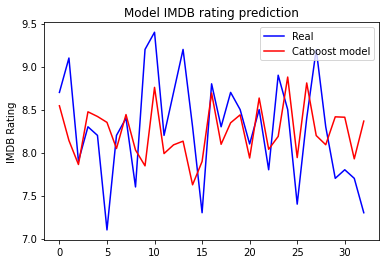

In [124]:
plt.plot(Y_test, color = 'blue', label = 'Real')
plt.plot(pred_cat, color = 'red', label = 'Catboost model')
plt.title('Model IMDB rating prediction')
plt.ylabel('IMDB Rating')
plt.legend()
plt.show()

In [125]:
errors = abs(pred_cat - Y_test)

In [126]:
errors

array([0.15573563, 0.9594244 , 0.03877902, 0.17422983, 0.21985997,
       1.25118293, 0.15297516, 0.04198274, 0.42942339, 1.35450887,
       0.64132155, 0.21148659, 0.61037508, 1.06738639, 0.67510377,
       0.59646903, 0.10740045, 0.20374754, 0.35357343, 0.06127672,
       0.16328331, 0.13444516, 0.2378923 , 0.7121884 , 0.37867995,
       0.54137997, 0.40995567, 1.00231534, 0.20901559, 0.71579202,
       0.61116027, 0.22694846, 1.06619222])

In [127]:
stddev_cat_test = np.std(errors)
print ('Standard deviation Error Catboost Regression test: ', stddev_cat_test)

Standard deviation Error Catboost Regression test:  0.36710754597966877


In [128]:
var_cat = np.var(pred_cat)
print ('Variância Catboost: ', var_cat)

Variância Catboost:  0.09312952877104477


In [129]:
mean_cat = np.mean(pred_cat)
print ('Média Cat: ', mean_cat)

Média Cat:  8.244112019540237


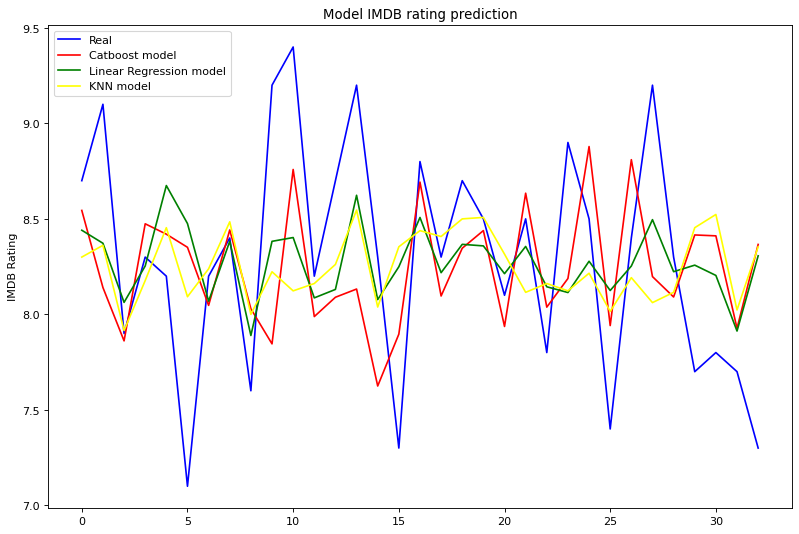

In [130]:
from matplotlib.pyplot import figure

figure(figsize=(12, 8), dpi=80)
plt.plot(Y_test, color = 'blue', label = 'Real')
plt.plot(pred_cat, color = 'red', label = 'Catboost model')
plt.plot(pred_linear, color = 'green', label = 'Linear Regression model')
plt.plot(pred_KNN, color = 'yellow', label = 'KNN model')
plt.title('Model IMDB rating prediction')
plt.ylabel('IMDB Rating')
plt.legend()
plt.show()

In [131]:
#verificando a variância e min/max das predições
print('KNN:', 'min:', min(pred_KNN), ', max:',  max(pred_KNN), 'variance: ', np.var(pred_KNN))
print('linear:', 'min:', min(pred_linear), ', max:',  max(pred_linear), 'variance: ', np.var(pred_linear))
print('Catboost:', 'min:', min(pred_cat), ', max:',  max(pred_cat), 'variance: ', np.var(pred_cat))

KNN: min: [7.91538462] , max: [8.54615385] variance:  0.030654908417146298
linear: min: [7.88940807] , max: [8.67454775] variance:  0.03234270621726011
Catboost: min: 7.624896228180854 , max: 8.878679945175463 variance:  0.09312952877104477
